In [2]:
from functions.utils.func import *

from prep_factor import PrepFactor

live = False
stock = read_stock(get_large_dir(live) / 'permno_to_train_fund.csv')
start='2006-01-01'
end='2022-01-01'

In [3]:
ret = PrepFactor(factor_name='factor_ret', interval='D', kind='price', stock=stock, div=False, start=start, end=end, save=False).prep()
sb_fama = PrepFactor(factor_name='factor_sb_fama', interval='D', kind='price', stock=stock, div=False, start=start, end=end, save=False).prep()

Creating factor_ret ---------------------------------------- | ✔
Shape: (2128883, 11)
Creating factor_sb_fama ------------------------------------ | ✔
Shape: (2128883, 14)


In [4]:
sb_macro = PrepFactor(factor_name='factor_sb_macro', interval='D', kind='price', stock=stock, div=False, start=start, end=end, save=False).prep()

Creating factor_sb_macro ----------------------------------- | ✔
Shape: (2797856, 28)


In [5]:
volatility = PrepFactor(factor_name='factor_volatility', interval='D', kind='price', stock=stock, div=False, start=start, end=end, save=False).prep()

Creating factor_volatility --------------------------------- | ✔
Shape: (2128883, 11)


# Looking at the underlying Stupid WRDS Data

In [10]:
dates_with_counts = ret.groupby(level='date').size()
filtered_dates = dates_with_counts[dates_with_counts < 10].index.tolist()
filtered_df = ret[ret.index.get_level_values('date').isin(filtered_dates)]
for date, group in filtered_df.groupby(level='date'):
    tickers = group.index.get_level_values('ticker').tolist()
    print(f"Date: {date} | Tickers: {tickers}")

In [47]:
def remove_date(df, threshold):
    dates_with_counts = df.groupby(level='date').size()
    valid_dates = dates_with_counts[dates_with_counts >= threshold].index.tolist()
    return df[df.index.get_level_values('date').isin(valid_dates)]

In [12]:
x = remove_date(ret, 10)

In [14]:
x.loc[x.index.get_level_values(1)=='2021-12-06']

,,RET_01,RET_02,RET_03,RET_04,RET_05,RET_10,RET_20,RET_40,RET_60,RET_120,RET_210
permno,date,,,,,,,,,,,
10104,2021-12-06,0.007933,-0.011668,-0.009025,-0.019837,-0.043039,-0.053528,-0.063296,-0.057739,-0.008252,0.153866,0.398428
10107,2021-12-06,0.009845,-0.010015,-0.011785,-0.013310,-0.031013,-0.049314,-0.029370,0.106291,0.103074,0.267348,0.346780
10138,2021-12-06,0.008845,-0.021763,0.006632,-0.013103,-0.046807,-0.062743,-0.107387,0.010084,-0.088966,0.007454,0.234393
10145,2021-12-06,0.013514,0.011029,0.034249,0.019828,-0.006790,-0.056021,-0.087632,-0.052595,-0.072492,-0.058176,0.016410
10516,2021-12-06,0.009276,0.011378,0.020867,0.014467,-0.026231,-0.034129,-0.021399,-0.002844,0.053765,-0.013752,0.184053
...,...,...,...,...,...,...,...,...,...,...,...,...
93114,2021-12-06,0.010819,0.000635,0.016691,0.004007,-0.016766,-0.028378,-0.028121,0.039408,0.020739,0.076976,0.163220
93132,2021-12-06,-0.035599,-0.067293,-0.043307,-0.120653,-0.149315,-0.147353,-0.144055,-0.049256,-0.059422,0.268250,0.878312
93142,2021-12-06,-0.002881,0.001930,0.002252,0.000642,0.002145,-0.000642,-0.011215,-0.003518,-0.020951,-0.010377,-0.028280


In [51]:
dates_with_counts = x.groupby(level='date').size()
filtered_dates = dates_with_counts[dates_with_counts < 10].index.tolist()
filtered_df = x[x.index.get_level_values('date').isin(filtered_dates)]
for date, group in filtered_df.groupby(level='date'):
    tickers = group.index.get_level_values('ticker').tolist()
    print(f"Date: {date} | Tickers: {tickers}")

# Testing EWO

In [9]:
n_splits = (get_timeframe_length(ret)) // 21

def ewo(data, n_splits, lookahead, train_period_length, test_period_length):
    unique_dates = data.index.get_level_values('date').unique()
    days = sorted(unique_dates)
    split_idx = []

    for i in range(n_splits):
        # Training window starts from the first available data point and expands
        train_start_idx = 0
        train_end_idx = i * test_period_length + train_period_length - 1
        
        # Test window immediately follows training data
        test_start_idx = train_end_idx + lookahead
        test_end_idx = test_start_idx + test_period_length - 1

        # Ensure test_end_idx does not go beyond available data
        if test_end_idx >= len(days):
            break
        
        split_idx.append([train_start_idx, train_end_idx, test_start_idx, test_end_idx])
    print(split_idx)
    dates = data.reset_index()[['date']]
    for train_start, train_end, test_start, test_end in split_idx:
        train_idx = dates[(days[train_start] <= dates.date) & (dates.date <= days[train_end])].index
        test_idx = dates[(days[test_start] <= dates.date) & (dates.date <= days[test_end])].index
        yield train_idx, test_idx

In [10]:
len(ret.index.get_level_values('date').unique())

4031

In [20]:
exp = ewo(ret, n_splits, 1, 504, 21)

for i in exp:
    break

[[0, 503, 504, 524], [0, 524, 525, 545], [0, 545, 546, 566], [0, 566, 567, 587], [0, 587, 588, 608], [0, 608, 609, 629], [0, 629, 630, 650], [0, 650, 651, 671], [0, 671, 672, 692], [0, 692, 693, 713], [0, 713, 714, 734], [0, 734, 735, 755], [0, 755, 756, 776], [0, 776, 777, 797], [0, 797, 798, 818], [0, 818, 819, 839], [0, 839, 840, 860], [0, 860, 861, 881], [0, 881, 882, 902], [0, 902, 903, 923], [0, 923, 924, 944], [0, 944, 945, 965], [0, 965, 966, 986], [0, 986, 987, 1007], [0, 1007, 1008, 1028], [0, 1028, 1029, 1049], [0, 1049, 1050, 1070], [0, 1070, 1071, 1091], [0, 1091, 1092, 1112], [0, 1112, 1113, 1133], [0, 1133, 1134, 1154], [0, 1154, 1155, 1175], [0, 1175, 1176, 1196], [0, 1196, 1197, 1217], [0, 1217, 1218, 1238], [0, 1238, 1239, 1259], [0, 1259, 1260, 1280], [0, 1280, 1281, 1301], [0, 1301, 1302, 1322], [0, 1322, 1323, 1343], [0, 1343, 1344, 1364], [0, 1364, 1365, 1385], [0, 1385, 1386, 1406], [0, 1406, 1407, 1427], [0, 1427, 1428, 1448], [0, 1448, 1449, 1469], [0, 1469, 14

# Testing WFO

In [28]:
n_splits = (get_timeframe_length(ret) - 504) // 21

def wfo(data, n_splits, lookahead, train_period_length, test_period_length):
    unique_dates = data.index.get_level_values('date').unique()
    days = sorted(unique_dates)
    split_idx = []

    for i in range(n_splits):
        train_start_idx = i * test_period_length
        train_end_idx = train_start_idx + train_period_length - 1
        test_start_idx = train_end_idx + lookahead
        test_end_idx = test_start_idx + test_period_length - 1

        split_idx.append([train_start_idx, train_end_idx, test_start_idx, test_end_idx])

    dates = data.reset_index()[['date']]
    print(split_idx)
    for train_start, train_end, test_start, test_end in split_idx:
        train_idx = dates[(days[train_start] <= dates.date) & (dates.date <= days[train_end])].index
        test_idx = dates[(days[test_start] <= dates.date) & (dates.date <= days[test_end])].index
        yield train_idx, test_idx

In [29]:
walk = wfo(ret, n_splits, 1, 504, 21)

for i in walk:
    print(i[0][:505])

[[0, 503, 504, 524], [21, 524, 525, 545], [42, 545, 546, 566], [63, 566, 567, 587], [84, 587, 588, 608], [105, 608, 609, 629], [126, 629, 630, 650], [147, 650, 651, 671], [168, 671, 672, 692], [189, 692, 693, 713], [210, 713, 714, 734], [231, 734, 735, 755], [252, 755, 756, 776], [273, 776, 777, 797], [294, 797, 798, 818], [315, 818, 819, 839], [336, 839, 840, 860], [357, 860, 861, 881], [378, 881, 882, 902], [399, 902, 903, 923], [420, 923, 924, 944], [441, 944, 945, 965], [462, 965, 966, 986], [483, 986, 987, 1007], [504, 1007, 1008, 1028], [525, 1028, 1029, 1049], [546, 1049, 1050, 1070], [567, 1070, 1071, 1091], [588, 1091, 1092, 1112], [609, 1112, 1113, 1133], [630, 1133, 1134, 1154], [651, 1154, 1155, 1175], [672, 1175, 1176, 1196], [693, 1196, 1197, 1217], [714, 1217, 1218, 1238], [735, 1238, 1239, 1259], [756, 1259, 1260, 1280], [777, 1280, 1281, 1301], [798, 1301, 1302, 1322], [819, 1322, 1323, 1343], [840, 1343, 1344, 1364], [861, 1364, 1365, 1385], [882, 1385, 1386, 1406], [

Int64Index([ 483,  484,  485,  486,  487,  488,  489,  490,  491,  492,
            ...
             978,  979,  980,  981,  982,  983,  984,  985,  986, 4511],
           dtype='int64', length=505)
Int64Index([ 504,  505,  506,  507,  508,  509,  510,  511,  512,  513,
            ...
             999, 1000, 1001, 1002, 1003, 1004, 1005, 1006, 1007, 4532],
           dtype='int64', length=505)
Int64Index([ 525,  526,  527,  528,  529,  530,  531,  532,  533,  534,
            ...
            1020, 1021, 1022, 1023, 1024, 1025, 1026, 1027, 1028, 4553],
           dtype='int64', length=505)
Int64Index([ 546,  547,  548,  549,  550,  551,  552,  553,  554,  555,
            ...
            1041, 1042, 1043, 1044, 1045, 1046, 1047, 1048, 1049, 4574],
           dtype='int64', length=505)
Int64Index([ 567,  568,  569,  570,  571,  572,  573,  574,  575,  576,
            ...
            1062, 1063, 1064, 1065, 1066, 1067, 1068, 1069, 1070, 4595],
           dtype='int64', length=505)
Int64

Int64Index([1365, 1366, 1367, 1368, 1369, 1370, 1371, 1372, 1373, 1374,
            ...
            1860, 1861, 1862, 1863, 1864, 1865, 1866, 5393, 5394, 5395],
           dtype='int64', length=505)
Int64Index([1386, 1387, 1388, 1389, 1390, 1391, 1392, 1393, 1394, 1395,
            ...
            1881, 1882, 1883, 1884, 1885, 1886, 1887, 5414, 5415, 5416],
           dtype='int64', length=505)
Int64Index([1407, 1408, 1409, 1410, 1411, 1412, 1413, 1414, 1415, 1416,
            ...
            1902, 1903, 1904, 1905, 1906, 1907, 1908, 5435, 5436, 5437],
           dtype='int64', length=505)
Int64Index([1428, 1429, 1430, 1431, 1432, 1433, 1434, 1435, 1436, 1437,
            ...
            1923, 1924, 1925, 1926, 1927, 1928, 1929, 5456, 5457, 5458],
           dtype='int64', length=505)
Int64Index([1449, 1450, 1451, 1452, 1453, 1454, 1455, 1456, 1457, 1458,
            ...
            1944, 1945, 1946, 1947, 1948, 1949, 1950, 5477, 5478, 5479],
           dtype='int64', length=505)
Int64

Int64Index([2329, 2330, 2331, 2332, 2333, 2334, 2335, 2336, 2337, 2338,
            ...
            2824, 2825, 2826, 2827, 2828, 2829, 2830, 2831, 2832, 6357],
           dtype='int64', length=505)
Int64Index([2350, 2351, 2352, 2353, 2354, 2355, 2356, 2357, 2358, 2359,
            ...
            2845, 2846, 2847, 2848, 2849, 2850, 2851, 2852, 2853, 6378],
           dtype='int64', length=505)
Int64Index([2371, 2372, 2373, 2374, 2375, 2376, 2377, 2378, 2379, 2380,
            ...
            2866, 2867, 2868, 2869, 2870, 2871, 2872, 2873, 2874, 6399],
           dtype='int64', length=505)
Int64Index([2392, 2393, 2394, 2395, 2396, 2397, 2398, 2399, 2400, 2401,
            ...
            2887, 2888, 2889, 2890, 2891, 2892, 2893, 2894, 2895, 6420],
           dtype='int64', length=505)
Int64Index([2413, 2414, 2415, 2416, 2417, 2418, 2419, 2420, 2421, 2422,
            ...
            2908, 2909, 2910, 2911, 2912, 2913, 2914, 2915, 2916, 6441],
           dtype='int64', length=505)
Int64

Int64Index([3315, 3316, 3317, 3318, 3319, 3320, 3321, 3322, 3323, 3324,
            ...
            3810, 3811, 3812, 3813, 3814, 3815, 3816, 3817, 3818, 7343],
           dtype='int64', length=505)
Int64Index([3336, 3337, 3338, 3339, 3340, 3341, 3342, 3343, 3344, 3345,
            ...
            3831, 3832, 3833, 3834, 3835, 3836, 3837, 3838, 3839, 7364],
           dtype='int64', length=505)
Int64Index([3357, 3358, 3359, 3360, 3361, 3362, 3363, 3364, 3365, 3366,
            ...
            3852, 3853, 3854, 3855, 3856, 3857, 3858, 3859, 3860, 7385],
           dtype='int64', length=505)
Int64Index([3378, 3379, 3380, 3381, 3382, 3383, 3384, 3385, 3386, 3387,
            ...
            3873, 3874, 3875, 3876, 3877, 3878, 3879, 3880, 3881, 7406],
           dtype='int64', length=505)
Int64Index([3399, 3400, 3401, 3402, 3403, 3404, 3405, 3406, 3407, 3408,
            ...
            3894, 3895, 3896, 3897, 3898, 3899, 3900, 3901, 3902, 7427],
           dtype='int64', length=505)
Int64

# Plotting Scatter plots of factors to returns

Text(0, 0.5, 'Y Axis')

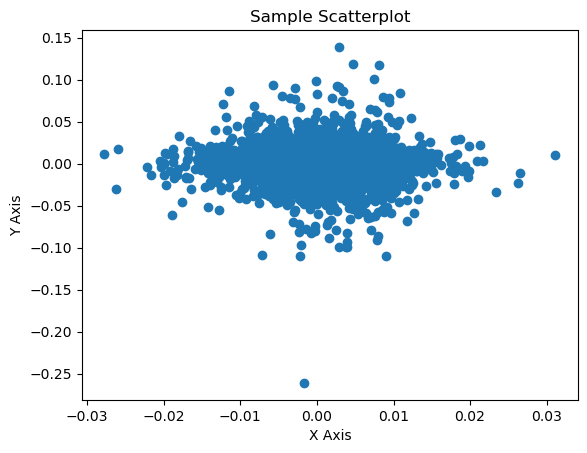

In [56]:
plt.scatter(get_ticker_data(sb_fama, 'A')['SMB_FAMA_30'], get_ticker_data(ret, 'A')['RET_01'].shift(-1))
plt.title("Sample Scatterplot")
plt.xlabel("X Axis")
plt.ylabel("Y Axis")

Text(0, 0.5, 'Y Axis')

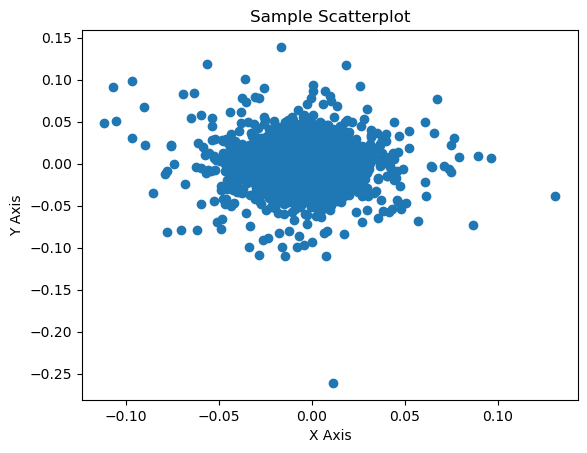

In [57]:
plt.scatter(get_ticker_data(sb_fama, 'A')['PRED_FAMA_30'], get_ticker_data(ret, 'A')['RET_01'].shift(-1))
plt.title("Sample Scatterplot")
plt.xlabel("X Axis")
plt.ylabel("Y Axis")

Text(0, 0.5, 'Y Axis')

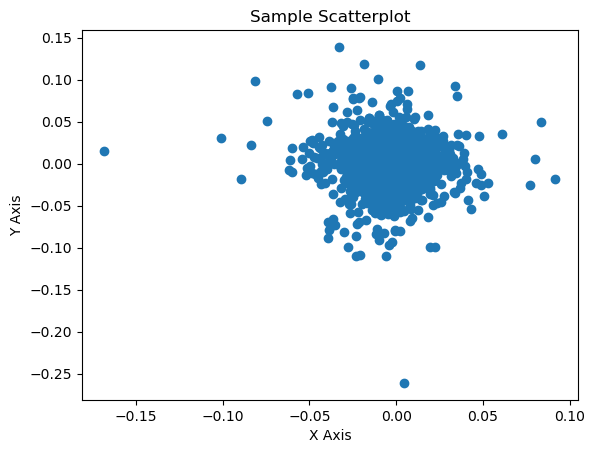

In [70]:
plt.scatter(get_ticker_data(sb_macro, 'A')['PRED_MACRO_60'], get_ticker_data(ret, 'A')['RET_01'].shift(-1))
plt.title("Sample Scatterplot")
plt.xlabel("X Axis")
plt.ylabel("Y Axis")

Text(0, 0.5, 'Y Axis')

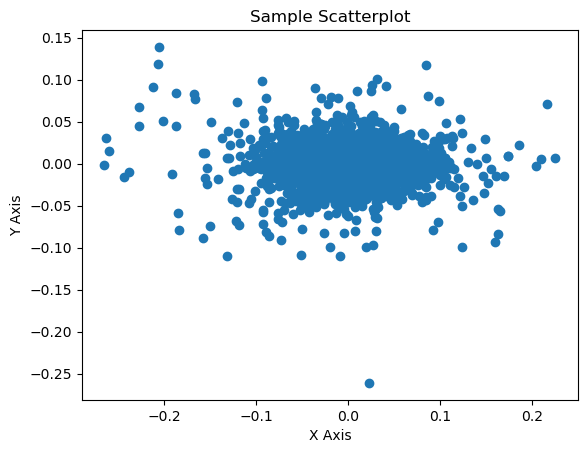

In [66]:
plt.scatter(get_ticker_data(ret, 'A')['RET_05'], get_ticker_data(ret, 'A')['RET_01'].shift(-1))
plt.title("Sample Scatterplot")
plt.xlabel("X Axis")
plt.ylabel("Y Axis")

Text(0, 0.5, 'Y Axis')

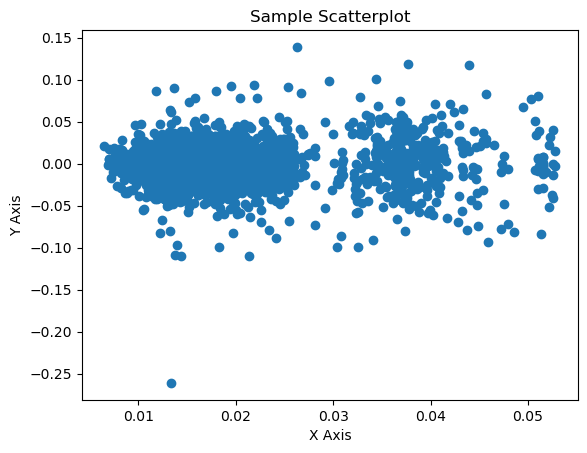

In [78]:
plt.scatter(get_ticker_data(volatility, 'A')['Volatility_01'], get_ticker_data(ret, 'A')['RET_01'].shift(-1))
plt.title("Sample Scatterplot")
plt.xlabel("X Axis")
plt.ylabel("Y Axis")

# Testing self coded rolling regression vs RollingOLS

In [40]:
factor_data = pd.read_parquet(get_load_data_parquet_dir() / 'data_price.parquet.brotli')
fama_data = pd.read_parquet(get_load_data_parquet_dir() / 'data_fama.parquet.brotli')
bond_df = yf.download(['TLT', 'TIP', 'SHY', 'AGG'], start='2006-01-01', end='2023-01-01')
bond_df = bond_df.stack().swaplevel().sort_index()
bond_df.index.names = ['ticker', 'date']
bond_df = bond_df.astype(float)
T = [1, 6, 30]
bond_df = create_return(bond_df, T)
bond_df = bond_df.drop(['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume'], axis=1)
bond_df = bond_df.unstack('ticker').swaplevel(axis=1)
bond_df.columns = ['_'.join(col).strip() for col in bond_df.columns.values]
bond_data = bond_df
bond_data = pd.concat([bond_data, fama_data['RF']], axis=1)
bond_data = bond_data.loc['2006-01-01':'2023-01-01']
bond_data = bond_data.fillna(0)
factor_col = bond_data.columns[:-1]

[*********************100%%**********************]  4 of 4 completed


In [41]:
factor_data = set_timeframe(factor_data, '2006-01-01', '2023-01-01')

In [42]:
factor_data = create_return(factor_data, windows=[1])
factor_data = factor_data.fillna(0)

In [49]:
ret = 'RET_01'
window = 20
name = 'BOND'

In [44]:
correlation_matrix = bond_data.corr()

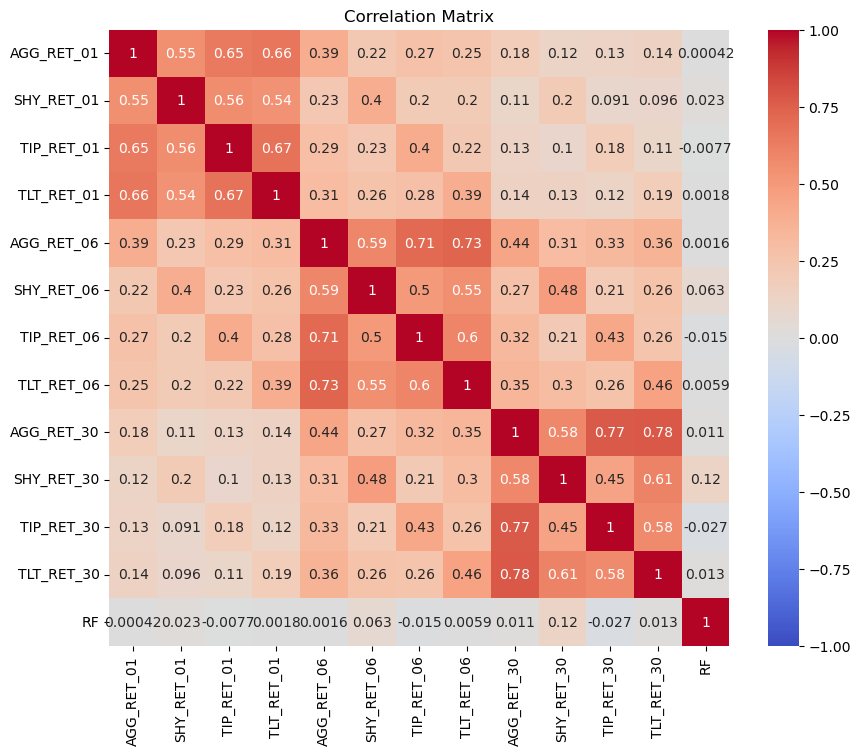

In [46]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Correlation Matrix")
plt.show()

In [264]:
def rolling_ols_beta_res_syn(price, factor_data, factor_col, window, name, ret):
    betas = []
    for stock, df in price.groupby(price.index.names[0], group_keys=False):
        model_data = df[[ret]].merge(factor_data, on='date').dropna()
        model_data[ret] -= model_data.RF
        rolling_ols = RollingOLS(endog=model_data[ret],
                                 exog=sm.add_constant(model_data[factor_col]), window=window)
        factor_model = rolling_ols.fit(params_only=True).params.rename(columns={'const': 'ALPHA'})
    
        # Compute predictions of stock's return
        alpha = factor_model['ALPHA']
        beta_coef = factor_model[factor_col]
        factor_ret = model_data[factor_col]
        stock_ret = df.reset_index(price.index.names[0]).drop(columns=price.index.names[0], axis=1)[ret]
    
        predictions = []
        epsilons = []
        for index, row in factor_ret.iterrows():
            prediction = row @ beta_coef.loc[index] + alpha.loc[index]
            epsilon = stock_ret.loc[index] - prediction
            predictions.append(prediction)
            epsilons.append(epsilon)
    
        result = factor_model.assign(**{price.index.names[0]: stock}).set_index(price.index.names[0], append=True).swaplevel()
        result['PRED'] = predictions
        result['EPSIL'] = epsilons
        # result['EPSIL_Z'] = result['EPSIL'].rolling(window=window).sum() / result['EPSIL'].rolling(window=window).std()
        result['IDIO_VOL'] = result['EPSIL'].rolling(window=window).std()
        betas.append(result)
        betas.append(result)
        print('---------------------------')
        print(result.index[0])
    
    return pd.concat(betas).rename(columns=lambda x: f'{x}_{name}_{window:02}')

In [50]:
def rolling_ols_beta_res_syn(price, factor_data, factor_col, window, name, ret):
    betas = []
    # Prepare the design matrix with constant term (for intercept)
    X = np.column_stack([factor_data[factor_col].values, np.ones(len(factor_data))])
    # Rolling view for X (independent variable)
    X_view = np.lib.stride_tricks.sliding_window_view(X, (window, X.shape[1]))
    X_view = X_view.squeeze(1)

    for stock, df in price.groupby(price.index.names[0]):   
        model_data = df[[ret]].merge(factor_data, on='date').dropna()
        model_data[ret] -= model_data.RF
        y = model_data[ret].values
        
        # Rolling view for y (dependent variable)
        y_view = np.lib.stride_tricks.sliding_window_view(y, (window,))
        # Compute rolling betas using matrix operations
        betas_matrix = np.linalg.inv(X_view.transpose(0, 2, 1) @ X_view) @ (X_view.transpose(0, 2, 1) @ y_view[:, :, np.newaxis])
        betas_matrix = betas_matrix.squeeze(axis=-1)
        # Extract all beta coefficients
        betas = [pd.Series(betas_matrix[:, i], index=model_data.index[window - 1:], name=f"BETA_{col}") for i, col in enumerate(factor_col)]
        # Extract y-intercept
        alpha = pd.Series(betas_matrix[:, -1], index=model_data.index[window - 1:], name=f"ALPHA")
        # Calculate predictions
        predictions = sum([model_data[col].iloc[window - 1:] * beta for col, beta in zip(factor_col, betas)]) + alpha
        # Calculate Epsilon
        epsilons = model_data[ret].iloc[window - 1:] - predictions
        # Combine all series into a single DataFrame
        result = pd.concat([alpha] + betas + [pd.Series(predictions, name="PRED"), pd.Series(epsilons, name="EPSIL")], axis=1)
        result['IDIO_VOL'] = result['EPSIL'].rolling(window=window).std()
        # Add stock index back
        result[df.index.names[0]] = stock
        result = result.set_index('permno', append=True).swaplevel()
        betas.append(result)
        print('---------------------------')
        print(result.index[0])

    return pd.concat(betas).rename(columns=lambda x: f'{x}_{name}_{window:02}')

In [51]:
y = rolling_ols_beta_res_syn(factor_data, bond_data, factor_col, window, name, ret)

LinAlgError: Singular matrix

# Checking YFinance Data

In [57]:
start, end = '2007-01-01', '2023-01-01'

In [30]:
# sector_df = yf.download(['XLSR', 'XLC', 'XLY', 'XLP', 'XLE', 'XLF', 'XLV', 'XLI', 'XLB', 'XLRE', 'XLK', 'XLU'], start=start, end=end)
sector_df = yf.download(['XLY', 'XLP', 'XLE', 'XLF', 'XLV', 'XLI', 'XLB', 'XLK', 'XLU'], start=start, end=end)
sector_df = sector_df.stack().swaplevel().sort_index()
sector_df.index.names = ['ticker', 'date']
sector_df = sector_df.astype(float)
T = [1]
sector_df = create_return(sector_df, T)
sector_df = sector_df.drop(['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume'], axis=1)
sector_df = sector_df.unstack('ticker').swaplevel(axis=1)
sector_df.columns = ['_'.join(col).strip() for col in sector_df.columns.values]

[*********************100%%**********************]  9 of 9 completed


In [31]:
sector_df

,XLB_RET_01,XLE_RET_01,XLF_RET_01,XLI_RET_01,XLK_RET_01,XLP_RET_01,XLU_RET_01,XLV_RET_01,XLY_RET_01
date,,,,,,,,,
2006-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006-01-04,0.006145,0.002846,-0.000932,0.002529,0.011732,0.003413,0.001562,0.009966,0.000909
2006-01-05,-0.001607,-0.012677,0.003419,-0.001577,0.004638,-0.005102,-0.006552,-0.002467,0.000908
2006-01-06,0.010625,0.024530,0.005886,0.003790,0.015697,0.004274,0.010678,0.006492,0.008167
2006-01-09,-0.000319,-0.001122,0.002772,0.008181,0.003182,0.004681,-0.006215,0.004607,0.010201
...,...,...,...,...,...,...,...,...,...
2022-12-23,0.006925,0.031883,0.005628,0.005930,0.001044,0.005215,0.010258,0.000588,0.006846
2022-12-27,0.000891,0.010682,-0.000295,0.003049,-0.009470,0.004789,0.006205,-0.002572,-0.016225
2022-12-28,-0.015269,-0.022389,-0.003536,-0.013071,-0.016124,-0.012444,-0.009530,-0.006483,-0.008403


In [67]:
ind_df = yf.download(['KBE', 'XBI', 'KCE', 'KIE', 'XME', 'XOP', 'XPH', 'XRT', 'XSD'], start=start, end=end)
ind_df = ind_df.stack().swaplevel().sort_index()
ind_df.index.names = ['ticker', 'date']
ind_df = ind_df.astype(float)
T = [1]
ind_df = create_return(ind_df, T)
ind_df = ind_df.drop(['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume'], axis=1)
ind_df = ind_df.unstack('ticker').swaplevel(axis=1)
ind_df.columns = ['_'.join(col).strip() for col in ind_df.columns.values]

[*********************100%%**********************]  12 of 12 completed


In [22]:
ave = yf.download(['HHH', 'IYR', 'IYT', 'OIH', 'RKH', 'RTH', 'SMH', 'UTH', 'XLE', 'XLF',
                         'XLI', 'XLK', 'XLP', 'XLV', 'XLY'], start=start, end=end)
ave = ave.stack().swaplevel().sort_index()
ave.index.names = ['ticker', 'date']
ave = ave.astype(float)
T = [1]
ave = create_return(ave, T)
ave = ave.drop(['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume'], axis=1)
ave = ave.unstack('ticker').swaplevel(axis=1)
ave.columns = ['_'.join(col).strip() for col in ave.columns.values]

[*********************100%%**********************]  15 of 15 completed


In [23]:
ave

,HHH_RET_01,IYR_RET_01,IYT_RET_01,OIH_RET_01,RKH_RET_01,RTH_RET_01,SMH_RET_01,UTH_RET_01,XLE_RET_01,XLF_RET_01,XLI_RET_01,XLK_RET_01,XLP_RET_01,XLV_RET_01,XLY_RET_01
date,,,,,,,,,,,,,,,
2008-10-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2008-10-13,NaN,0.074749,0.071947,0.217798,0.059659,0.072181,0.096059,NaN,0.164746,0.078146,0.107052,0.116981,0.046610,0.120547,0.039313
2008-10-14,NaN,-0.064874,-0.008839,-0.005527,0.052869,-0.013098,-0.078652,NaN,0.001187,0.064496,-0.000384,-0.033784,0.002024,0.020333,0.006087
2008-10-15,NaN,-0.141667,-0.087084,-0.174564,-0.065288,-0.077638,-0.068293,NaN,-0.144438,-0.108482,-0.094050,-0.075175,-0.034343,-0.097826,-0.116249
2008-10-16,NaN,0.062864,0.041209,0.031956,0.035415,0.049352,0.046073,NaN,0.038106,0.022654,0.020339,0.052300,0.009623,0.052209,0.066015
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-23,0.029867,0.008591,0.008048,0.037797,NaN,0.008458,-0.000098,NaN,0.031883,0.005628,0.005930,0.001044,0.005215,0.000588,0.006846
2022-12-27,0.002072,-0.000710,-0.003969,0.005893,NaN,-0.002754,-0.017889,NaN,0.010682,-0.000295,0.003049,-0.009470,0.004789,-0.002572,-0.016225
2022-12-28,-0.038630,-0.016929,-0.017745,-0.031665,NaN,-0.013431,-0.012710,NaN,-0.022389,-0.003536,-0.013071,-0.016124,-0.012444,-0.006483,-0.008403


# Determining Bin Size for Ind Mom Factors

In [40]:
columns = ['atq', 'lctq', 'cheq', 'ivstq', 'ltq', 'ceqq', 'niq', 'saleq', 'cogsq', 'invtq', 'apq', 'prccq', 'cshoq', 'dpq', 'xintq', 'piq', 'revtq']
fund_raw = pd.read_parquet(get_load_data_parquet_dir() / 'data_fund_raw.parquet.brotli', columns=columns)
fund_raw['current_ratio'] = fund_raw['atq'] / fund_raw['lctq']
fund_raw['quick_ratio'] = (fund_raw['cheq'] + fund_raw['ivstq']) / fund_raw['lctq']
fund_raw['cash_ratio'] = fund_raw['cheq'] / fund_raw['lctq']
fund_raw['debt_equity_ratio'] = fund_raw['ltq'] / fund_raw['ceqq']
fund_raw['equity_multiplier'] = fund_raw['atq'] / fund_raw['ceqq']
fund_raw['return_on_assets'] = fund_raw['niq'] / fund_raw['atq']
fund_raw['return_on_equity'] = fund_raw['niq'] / fund_raw['ceqq']
fund_raw['gross_profit_margin'] = (fund_raw['saleq'] - fund_raw['cogsq']) / fund_raw['saleq']
fund_raw['net_profit_margin'] = fund_raw['niq'] / fund_raw['saleq']
fund_raw['asset_turnover'] = fund_raw['saleq'] / fund_raw['atq']
fund_raw['inventory_turnover'] = fund_raw['cogsq'] / fund_raw['invtq']
fund_raw['payable_turnover'] = fund_raw['cogsq'] / fund_raw['apq']
fund_raw['book_to_market'] = fund_raw['ceqq'] / (fund_raw['prccq'] * fund_raw['cshoq'])
fund_raw['price_to_earnings'] = fund_raw['prccq'] / (fund_raw['niq'] / fund_raw['cshoq'])
fund_raw['ev_to_ebitda'] = (fund_raw['ltq'] + fund_raw['ceqq'] + (fund_raw['prccq'] * fund_raw['cshoq'])) / (fund_raw['niq'] + fund_raw['dpq'] + fund_raw['xintq'])
fund_raw['debt_ratio'] = fund_raw['ltq'] / fund_raw['atq']
fund_raw['roic'] = fund_raw['niq'] / (fund_raw['ceqq'] + fund_raw['ltq'])
fund_raw['financial_leverage'] = fund_raw['atq'] / fund_raw['ceqq']
fund_raw['interest_coverage_ratio'] = fund_raw['piq'] / fund_raw['xintq']
fund_raw['roe'] = fund_raw['niq'] / fund_raw['ceqq']
fund_raw['roa'] = fund_raw['niq'] / fund_raw['atq']
fund_raw['gross_margin'] = (fund_raw['saleq'] - fund_raw['cogsq']) / fund_raw['saleq']
fund_raw['net_margin'] = fund_raw['niq'] / fund_raw['revtq']
fund_raw['asset_utilization'] = fund_raw['saleq'] / fund_raw['atq']
fund_raw['days_of_inventory_on_hand'] = 365 / fund_raw['inventory_turnover']
fund_raw['payables_turnover'] = fund_raw['cogsq'] / fund_raw['apq']
fund_raw['days_of_payables_outstanding'] = 365 / fund_raw['payables_turnover']

# Handling division by zero and replacing inf with NaN
fund_raw = fund_raw.drop(columns, axis=1)
fund_raw = fund_raw.replace([np.inf, -np.inf], np.nan)

# Ranking by each column
fund_rank = fund_raw[['current_ratio']]
for col in fund_raw.columns:
    fund_rank[f'{col}_rank'] = fund_raw.groupby('date')[col].rank()

    bin_size = 3.4
    max_compressed_rank = (fund_rank[f'{col}_rank'].max() + bin_size - 1) // bin_size
    fund_rank[f'{col}_rank'] = np.ceil(fund_rank[f'{col}_rank'] / bin_size)
    fund_rank[f'{col}_rank'] = fund_rank[f'{col}_rank'].apply(lambda x: min(x, max_compressed_rank))
    fund_rank[f'{col}_rank'] = fund_rank[f'{col}_rank'].replace({np.nan: -1, np.inf: max_compressed_rank}).astype(int)

fund_rank = fund_rank.drop(['current_ratio'], axis=1)

In [41]:
fund_rank.describe()

,current_ratio_rank,quick_ratio_rank,cash_ratio_rank,debt_equity_ratio_rank,equity_multiplier_rank,return_on_assets_rank,return_on_equity_rank,gross_profit_margin_rank,net_profit_margin_rank,asset_turnover_rank,...,financial_leverage_rank,interest_coverage_ratio_rank,roe_rank,roa_rank,gross_margin_rank,net_margin_rank,asset_utilization_rank,days_of_inventory_on_hand_rank,payables_turnover_rank,days_of_payables_outstanding_rank
count,176977.000000,176977.000000,176977.000000,176977.000000,176977.000000,176977.000000,176977.000000,176977.000000,176977.000000,176977.000000,...,176977.000000,176977.000000,176977.000000,176977.000000,176977.000000,176977.000000,176977.000000,176977.000000,176977.000000,176977.000000
mean,79.714686,67.476565,79.676625,116.328986,116.337987,116.781661,116.133012,110.489516,110.840550,116.749148,...,116.337987,83.460794,116.133012,116.781661,110.489516,102.734576,116.749148,104.087350,111.191143,107.701526
std,63.617803,63.580208,63.616124,68.615905,68.614912,68.610051,68.609561,68.240832,68.243213,68.610306,...,68.614912,64.890936,68.609561,68.610051,68.240832,67.727694,68.610306,67.240092,68.575344,68.126338
min,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,17.000000,-1.000000,17.000000,57.000000,57.000000,58.000000,57.000000,51.000000,52.000000,58.000000,...,57.000000,21.000000,57.000000,58.000000,51.000000,43.000000,58.000000,34.000000,52.000000,48.000000
50%,76.000000,57.000000,76.000000,116.000000,116.000000,116.000000,115.000000,110.000000,110.000000,116.000000,...,116.000000,80.000000,115.000000,116.000000,110.000000,102.000000,116.000000,103.000000,110.000000,107.000000
75%,134.000000,122.000000,134.000000,174.000000,174.000000,175.000000,174.000000,169.000000,169.000000,175.000000,...,174.000000,138.000000,174.000000,175.000000,169.000000,160.000000,175.000000,162.000000,169.000000,166.000000
max,213.000000,207.000000,213.000000,253.000000,253.000000,254.000000,253.000000,245.000000,245.000000,254.000000,...,253.000000,219.000000,253.000000,254.000000,245.000000,237.000000,254.000000,239.000000,249.000000,242.000000


In [51]:
price_data = pd.read_parquet(get_load_data_parquet_dir() / 'data_price.parquet.brotli')
ind_data = pd.read_parquet(get_load_data_parquet_dir() / 'data_ind_fama.parquet.brotli')
combine = pd.concat([price_data, ind_data], axis=1)

T = [1, 2, 5, 10, 30, 60]
ret = create_return(combine, windows=T)
collect = []

for t in T:
    ret[f'IndMomFama_{t:02}'] = ret.groupby(['IndustryFama', 'date'])[f'RET_{t:02}'].transform('mean')
    ret[f'indMomFama_{t:02}_rank'] =  ret.groupby(['date'])[f'IndMomFama_{t:02}'].rank()

    bin_size = 3.5
    max_compressed_rank = (ret[f'indMomFama_{t:02}_rank'].max() + bin_size - 1) // bin_size
    ret[f'indMomFama_{t:02}_rank'] = np.ceil(ret[f'indMomFama_{t:02}_rank'] / bin_size)
    ret[f'indMomFama_{t:02}_rank'] = ret[f'indMomFama_{t:02}_rank'].apply(lambda x: min(x, max_compressed_rank))
    ret[f'indMomFama_{t:02}_rank'] = ret[f'indMomFama_{t:02}_rank'].replace({np.nan: -1, np.inf: max_compressed_rank}).astype(int)
    ind_mom = ret[[f'indMomFama_{t:02}_rank']]
    collect.append(ind_mom)
ind_fama = pd.concat(collect, axis=1)

In [52]:
ind_fama.describe()

,indMomFama_01_rank,indMomFama_02_rank,indMomFama_05_rank,indMomFama_10_rank,indMomFama_30_rank,indMomFama_60_rank
count,4.127732e+06,4.127732e+06,4.127732e+06,4.127732e+06,4.127732e+06,4.127732e+06
mean,1.029166e+02,1.028993e+02,1.028495e+02,1.027691e+02,1.024382e+02,1.019390e+02
std,7.364469e+01,7.365298e+01,7.367797e+01,7.372141e+01,7.389029e+01,7.414116e+01
min,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00
25%,3.600000e+01,3.600000e+01,3.600000e+01,3.500000e+01,3.500000e+01,3.400000e+01
50%,1.010000e+02,1.010000e+02,1.010000e+02,1.010000e+02,1.000000e+02,9.900000e+01
75%,1.660000e+02,1.660000e+02,1.660000e+02,1.660000e+02,1.660000e+02,1.660000e+02
max,2.510000e+02,2.510000e+02,2.510000e+02,2.510000e+02,2.510000e+02,2.510000e+02


In [53]:
price_data = pd.read_parquet(get_load_data_parquet_dir() / 'data_price.parquet.brotli')
ind_data = pd.read_parquet(get_load_data_parquet_dir() / 'data_ind_sub.parquet.brotli')
combine = pd.concat([price_data, ind_data], axis=1)

T = [1, 2, 5, 10, 30, 60]
ret = create_return(combine, windows=T)
collect = []

for t in T:
    ret[f'IndMomSub_{t:02}'] = ret.groupby(['Subindustry', 'date'])[f'RET_{t:02}'].transform('mean')
    ret[f'indMomSub_{t:02}_rank'] =  ret.groupby(['date'])[f'IndMomSub_{t:02}'].rank()

    bin_size = 3.5
    max_compressed_rank = (ret[f'indMomSub_{t:02}_rank'].max() + bin_size - 1) // bin_size
    ret[f'indMomSub_{t:02}_rank'] = np.ceil(ret[f'indMomSub_{t:02}_rank'] / bin_size)
    ret[f'indMomSub_{t:02}_rank'] = ret[f'indMomSub_{t:02}_rank'].apply(lambda x: min(x, max_compressed_rank))
    ret[f'indMomSub_{t:02}_rank'] = ret[f'indMomSub_{t:02}_rank'].replace({np.nan: -1, np.inf: max_compressed_rank}).astype(int)
    ind_mom = ret[[f'indMomSub_{t:02}_rank']]
    collect.append(ind_mom)

ind_sub = pd.concat(collect, axis=1)

In [54]:
ind_sub.describe()

,indMomSub_01_rank,indMomSub_02_rank,indMomSub_05_rank,indMomSub_10_rank,indMomSub_30_rank,indMomSub_60_rank
count,4.127732e+06,4.127732e+06,4.127732e+06,4.127732e+06,4.127732e+06,4.127732e+06
mean,1.028312e+02,1.028136e+02,1.027620e+02,1.026754e+02,1.023260e+02,1.017970e+02
std,7.371942e+01,7.372719e+01,7.375272e+01,7.379449e+01,7.396025e+01,7.420402e+01
min,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00
25%,3.600000e+01,3.600000e+01,3.500000e+01,3.500000e+01,3.500000e+01,3.300000e+01
50%,1.010000e+02,1.010000e+02,1.010000e+02,1.010000e+02,1.000000e+02,9.900000e+01
75%,1.660000e+02,1.660000e+02,1.660000e+02,1.660000e+02,1.660000e+02,1.650000e+02
max,2.510000e+02,2.510000e+02,2.510000e+02,2.510000e+02,2.510000e+02,2.510000e+02


In [55]:
price_data = pd.read_parquet(get_load_data_parquet_dir() / 'data_price.parquet.brotli')
ind_data = pd.read_parquet(get_load_data_parquet_dir() / 'data_ind.parquet.brotli')
combine = pd.concat([price_data, ind_data], axis=1)

T = [1, 2, 5, 10, 30, 60]
ret = create_return(combine, windows=T)
collect = []

for t in T:
    ret[f'IndMom_{t:02}'] = ret.groupby(['Industry', 'date'])[f'RET_{t:02}'].transform('mean')
    ret[f'indMom_{t:02}_rank'] =  ret.groupby(['date'])[f'IndMom_{t:02}'].rank()

    bin_size = 3.5
    max_compressed_rank = (ret[f'indMom_{t:02}_rank'].max() + bin_size - 1) // bin_size
    ret[f'indMom_{t:02}_rank'] = np.ceil(ret[f'indMom_{t:02}_rank'] / bin_size)
    ret[f'indMom_{t:02}_rank'] = ret[f'indMom_{t:02}_rank'].apply(lambda x: min(x, max_compressed_rank))
    ret[f'indMom_{t:02}_rank'] = ret[f'indMom_{t:02}_rank'].replace({np.nan: -1, np.inf: max_compressed_rank}).astype(int)
    ind_mom = ret[[f'indMom_{t:02}_rank']]
    collect.append(ind_mom)

ind_mom = pd.concat(collect, axis=1)

In [56]:
ind_mom.describe()

,indMom_01_rank,indMom_02_rank,indMom_05_rank,indMom_10_rank,indMom_30_rank,indMom_60_rank
count,4.127732e+06,4.127732e+06,4.127732e+06,4.127732e+06,4.127732e+06,4.127732e+06
mean,1.028316e+02,1.028151e+02,1.027646e+02,1.026829e+02,1.023506e+02,1.018514e+02
std,7.369838e+01,7.370774e+01,7.373376e+01,7.377596e+01,7.394508e+01,7.419318e+01
min,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00
25%,3.600000e+01,3.600000e+01,3.600000e+01,3.500000e+01,3.500000e+01,3.400000e+01
50%,1.010000e+02,1.010000e+02,1.010000e+02,1.010000e+02,1.000000e+02,9.900000e+01
75%,1.660000e+02,1.660000e+02,1.660000e+02,1.660000e+02,1.660000e+02,1.650000e+02
max,2.510000e+02,2.510000e+02,2.510000e+02,2.510000e+02,2.510000e+02,2.510000e+02


In [57]:
ind_data = pd.read_parquet(get_load_data_parquet_dir() / 'data_ind_sub.parquet.brotli')

In [59]:
len(ind_data.Subindustry.unique())

162

In [3]:
rank_volatility = PrepFactor(factor_name='factor_rank_volatility', group='permno', interval='D', kind='price', stock=stock, div=False, start=start, end=end, save=False).prep()

Creating factor_rank_volatility ---------------------------- | ✔
Shape: (3031703, 6)


# Testing resample to daily

In [5]:
# Resample from not daily to daily
date_data = pd.read_parquet(get_load_data_parquet_dir() / 'data_date.parquet.brotli')
stock = read_stock(get_large_dir(live) / 'permno_to_train_fund.csv')
start = '2006-01-01'
end = '2023-01-01'
date_data = set_timeframe(date_data, start, end)
data = pd.read_parquet(get_factor_dir(live) / 'factor_clust_fund_raw.parquet.brotli')

In [6]:
data = pd.merge(date_data.loc[stock], data, left_index=True, right_index=True, how='left')
data = data.loc[~data.index.duplicated(keep='first')]
collect = []

In [8]:
for _, df in data.groupby('permno'):
    df = df.reset_index().set_index('date')
    df = ffill_max_days(df, max_days=31)
    df = df.reset_index().set_index(['permno', 'date']).sort_index(level=['permno', 'date'])
    collect.append(df)
x = pd.concat(collect, axis=0)

In [9]:
x.shape

(3225984, 1)

In [11]:
x[~x.index.duplicated(keep='first')]

clust_fund_raw
permno  date                      
10078.0 2006-01-03             NaN
        2006-01-04             NaN
        2006-01-05             NaN
        2006-01-06             NaN
        2006-01-09             NaN
...                            ...
93436.0 2022-12-23             0.0
        2022-12-27             0.0
        2022-12-28             0.0
        2022-12-29             0.0
        2022-12-30             0.0

[3225984 rows x 1 columns]

# Testing getting subset of permnos from unstacked dataframe

In [226]:
stock = read_stock(get_large_dir(live) / 'permno_to_train_fund.csv')

In [227]:
factor_data = pd.read_parquet(get_load_data_parquet_dir() / 'data_price.parquet.brotli')
# Create returns and convert stock index to columns
window_size = 10
factor_data = create_smooth_return(factor_data, windows=[1], window_size=window_size)
factor_data = factor_data[[f'RET_01']]
factor_data = factor_data['RET_01'].unstack('permno')
factor_data.iloc[:window_size + 1] = factor_data.iloc[:window_size + 1].fillna(0)

In [ ]:
factor_data[stock]

In [239]:
columns = ['atq', 'lctq', 'cheq', 'ivstq', 'ltq', 'ceqq', 'niq', 'saleq', 'cogsq', 'invtq', 'apq', 'prccq', 'cshoq', 'dpq', 'xintq', 'piq', 'revtq']
fund_raw = pd.read_parquet(get_load_data_parquet_dir() / 'data_fund_raw.parquet.brotli', columns=columns)
fund_raw['current_ratio'] = fund_raw['atq'] / fund_raw['lctq']
fund_raw['quick_ratio'] = (fund_raw['cheq'] + fund_raw['ivstq']) / fund_raw['lctq']
fund_raw['cash_ratio'] = fund_raw['cheq'] / fund_raw['lctq']
fund_raw['debt_equity_ratio'] = fund_raw['ltq'] / fund_raw['ceqq']
fund_raw['equity_multiplier'] = fund_raw['atq'] / fund_raw['ceqq']
fund_raw['return_on_assets'] = fund_raw['niq'] / fund_raw['atq']
fund_raw['return_on_equity'] = fund_raw['niq'] / fund_raw['ceqq']
fund_raw['gross_profit_margin'] = (fund_raw['saleq'] - fund_raw['cogsq']) / fund_raw['saleq']
fund_raw['net_profit_margin'] = fund_raw['niq'] / fund_raw['saleq']
fund_raw['asset_turnover'] = fund_raw['saleq'] / fund_raw['atq']
fund_raw['inventory_turnover'] = fund_raw['cogsq'] / fund_raw['invtq']
fund_raw['payable_turnover'] = fund_raw['cogsq'] / fund_raw['apq']
fund_raw['book_to_market'] = fund_raw['ceqq'] / (fund_raw['prccq'] * fund_raw['cshoq'])
fund_raw['price_to_earnings'] = fund_raw['prccq'] / (fund_raw['niq'] / fund_raw['cshoq'])
fund_raw['ev_to_ebitda'] = (fund_raw['ltq'] + fund_raw['ceqq'] + (fund_raw['prccq'] * fund_raw['cshoq'])) / (fund_raw['niq'] + fund_raw['dpq'] + fund_raw['xintq'])
fund_raw['debt_ratio'] = fund_raw['ltq'] / fund_raw['atq']
fund_raw['roic'] = fund_raw['niq'] / (fund_raw['ceqq'] + fund_raw['ltq'])
fund_raw['financial_leverage'] = fund_raw['atq'] / fund_raw['ceqq']
fund_raw['interest_coverage_ratio'] = fund_raw['piq'] / fund_raw['xintq']
fund_raw['roe'] = fund_raw['niq'] / fund_raw['ceqq']
fund_raw['roa'] = fund_raw['niq'] / fund_raw['atq']
fund_raw['gross_margin'] = (fund_raw['saleq'] - fund_raw['cogsq']) / fund_raw['saleq']
fund_raw['net_margin'] = fund_raw['niq'] / fund_raw['revtq']
fund_raw['asset_utilization'] = fund_raw['saleq'] / fund_raw['atq']
fund_raw['days_of_inventory_on_hand'] = 365 / fund_raw['inventory_turnover']
fund_raw['payables_turnover'] = fund_raw['cogsq'] / fund_raw['apq']
fund_raw['days_of_payables_outstanding'] = 365 / fund_raw['payables_turnover']

# Handling division by zero and replacing inf with NaN
fund_raw = fund_raw.drop(columns, axis=1)
fund_raw = fund_raw.replace([np.inf, -np.inf], np.nan)

factor_data = fund_raw
factor_data = factor_data.unstack('permno')

In [246]:
factor_data.loc[:, (slice(None), stock)]

current_ratio                                                \
permno             10078     10104     10107 10138     10145     10147   
date                                                                     
2005-04-30           NaN       NaN       NaN   NaN       NaN       NaN   
2005-05-31           NaN  1.942224       NaN   NaN       NaN       NaN   
2005-06-30      3.053983  1.942224  4.106512   NaN  3.000606  5.165048   
2005-07-31      3.053983  1.942224  4.106512   NaN  3.000606  5.165048   
2005-08-31      3.053983  2.565670  4.106512   NaN  3.000606  5.165048   
...                  ...       ...       ...   ...       ...       ...   
2023-10-31           NaN  5.820009  3.955640   NaN  3.629731       NaN   
2023-11-30           NaN  5.389518  3.955640   NaN  3.629731       NaN   
2023-12-31           NaN  5.389518       NaN   NaN       NaN       NaN   
2024-01-31           NaN  5.389518       NaN   NaN       NaN       NaN   
2024-02-29           NaN       NaN       NaN   NaN       NaN       NaN   

                                                       ...  \
permno         10225      10258      10299      10324  ...   
date                                                   ...   
2005-04-30       NaN        NaN        NaN        NaN  ...   
2005-05-31       NaN        NaN        NaN        NaN  ...   
2005-06-30  4.018995   8.737277  11.732164  11.729017  ...   
2005-07-31  4.018995   8.737277  11.732164  11.729017  ...   
2005-08-31  4.018995   8.737277  11.732164  11.729017  ...   
...              ...        ...        ...        ...  ...   
2023-10-31       NaN  19.130193        NaN        NaN  ...   
2023-11-30       NaN  19.130193        NaN        NaN  ...   
2023-12-31       NaN        NaN        NaN        NaN  ...   
2024-01-31       NaN        NaN        NaN        NaN  ...   
2024-02-29       NaN        NaN        NaN        NaN  ...   

           days_of_payables_outstanding                               \
permno                            93126 93150 93152 93159      93296   
date                                                                   
2005-04-30                          NaN   NaN   NaN   NaN        NaN   
2005-05-31                          NaN   NaN   NaN   NaN        NaN   
2005-06-30                          NaN   NaN   NaN   NaN        NaN   
2005-07-31                          NaN   NaN   NaN   NaN        NaN   
2005-08-31                          NaN   NaN   NaN   NaN        NaN   
...                                 ...   ...   ...   ...        ...   
2023-10-31                          NaN   NaN   NaN   NaN  273.40874   
2023-11-30                          NaN   NaN   NaN   NaN  273.40874   
2023-12-31                          NaN   NaN   NaN   NaN        NaN   
2024-01-31                          NaN   NaN   NaN   NaN        NaN   
2024-02-29                          NaN   NaN   NaN   NaN        NaN   

                                                                
permno          93299      93312 93384       93429       93436  
date                                                            
2005-04-30        NaN        NaN   NaN         NaN         NaN  
2005-05-31        NaN        NaN   NaN         NaN         NaN  
2005-06-30        NaN        NaN   NaN         NaN         NaN  
2005-07-31        NaN        NaN   NaN         NaN         NaN  
2005-08-31        NaN        NaN   NaN         NaN         NaN  
...               ...        ...   ...         ...         ...  
2023-10-31  50.808913  30.087482   NaN  132.930565  289.742464  
2023-11-30  50.808913  30.087482   NaN  132.930565  289.742464  
2023-12-31        NaN        NaN   NaN         NaN         NaN  
2024-01-31        NaN        NaN   NaN         NaN         NaN  
2024-02-29        NaN        NaN   NaN         NaN         NaN  

[227 rows x 28458 columns]

In [248]:
factor_data.columns.get_level_values(0)

Index(['current_ratio', 'current_ratio', 'current_ratio', 'current_ratio',
       'current_ratio', 'current_ratio', 'current_ratio', 'current_ratio',
       'current_ratio', 'current_ratio',
       ...
       'days_of_payables_outstanding', 'days_of_payables_outstanding',
       'days_of_payables_outstanding', 'days_of_payables_outstanding',
       'days_of_payables_outstanding', 'days_of_payables_outstanding',
       'days_of_payables_outstanding', 'days_of_payables_outstanding',
       'days_of_payables_outstanding', 'days_of_payables_outstanding'],
      dtype='object', length=28458)

# TrendFactor

In [249]:
start = '2005-01-01'
end = '2017-01-01'

In [250]:
factor_data = pd.read_parquet(get_load_data_parquet_dir() / 'data_price.parquet.brotli')
lag_data = factor_data.copy(deep=True)
# Create Lag Price Rolling Mean Predictors
T = [3, 5, 10, 20, 50, 100, 200, 400, 600, 800, 1000]
for lag in T:
    # Calculate rolling mean
    rolling_mean = lag_data.groupby('permno')['Close'].rolling(window=lag).mean().reset_index(level=0, drop=True)
    # Normalize the rolling mean by the daily closing price
    normalized_rolling_mean = rolling_mean / lag_data['Close']
    # Store the normalized rolling mean in the dataframe
    lag_data[f'ma_{lag}'] = normalized_rolling_mean
    
lag_data = lag_data.replace([np.inf, -np.inf], np.nan)
lag_data = lag_data.drop(['Close', 'High', 'Low', 'Open', 'Volume'], axis=1)
columns = lag_data.columns
lag_data = set_timeframe(lag_data, start, end)
lag_data = lag_data.unstack('permno')

factor_data = create_return(factor_data, windows=[1])
factor_data = factor_data[[f'RET_01']]
factor_data = set_timeframe(factor_data, start, end)
factor_data = factor_data['RET_01'].unstack('permno')
factor_data = factor_data.fillna(0)

In [252]:
# betas = {}
# dates = factor_data.index

# # Iterate over each moving average column
# for ma_column in columns:
#     betas_for_ma = []

#     # For each date in our dataset
#     for date in dates[1:]:  # starting from the second date since we're using lagged values
#         # Extract the dependent variable (returns) for the given date
#         y = factor_data.loc[date]

#         # Extract the independent variable (lagged moving average) for the previous day
#         X = lag_data[ma_column].shift(1).loc[date]

#         # Run the cross-sectional regression with missing data dropped
#         model = sm.OLS(y, sm.add_constant(X), missing='drop').fit()
#         betas_for_ma.append(model.params[date])

#     # Store the betas in the dictionary
#     betas[ma_column] = betas_for_ma

# # Convert the dictionary to a DataFrame
# rolling_betas = pd.DataFrame(betas, index=dates[1:])

In [ ]:
betas = {}
dates = factor_data.index

# Iterate over each moving average column
for ma_column in columns:
    betas_for_ma = []

    # For each date in our dataset
    for date in dates:
        # Extract the dependent variable (returns) for the given date
        y = factor_data.loc[date]
        X = lag_data[ma_column].loc[date]
        model = sm.OLS(y, sm.add_constant(X), missing='drop').fit()
        betas_for_ma.append(model.params[date])

    # Store the betas in the dictionary
    betas[ma_column] = betas_for_ma

In [ ]:
# Convert the dictionary to a DataFrame
rolling_betas = pd.DataFrame(betas, index=dates)

In [ ]:
rolling_betas = rolling_betas.rolling(window=60).mean()

In [ ]:
total = []
for col in rolling_betas.columns:
    result = lag_data[col].multiply(rolling_betas[col], axis=0).stack().swaplevel().to_frame()
    result.columns = [col]
    total.append(result)
total = pd.concat(total, axis=1)
total = total.sort_index(level=['permno', 'date'])

In [202]:
total['TrendFactor'] = total.sum(axis=1)

In [204]:
total['TrendFactor'] = total['TrendFactor'] - total['TrendFactor'].mean()

In [30]:
open_asset = pd.read_parquet(get_load_data_parquet_dir() / 'data_open_asset.parquet.brotli')

<AxesSubplot:xlabel='permno,date'>

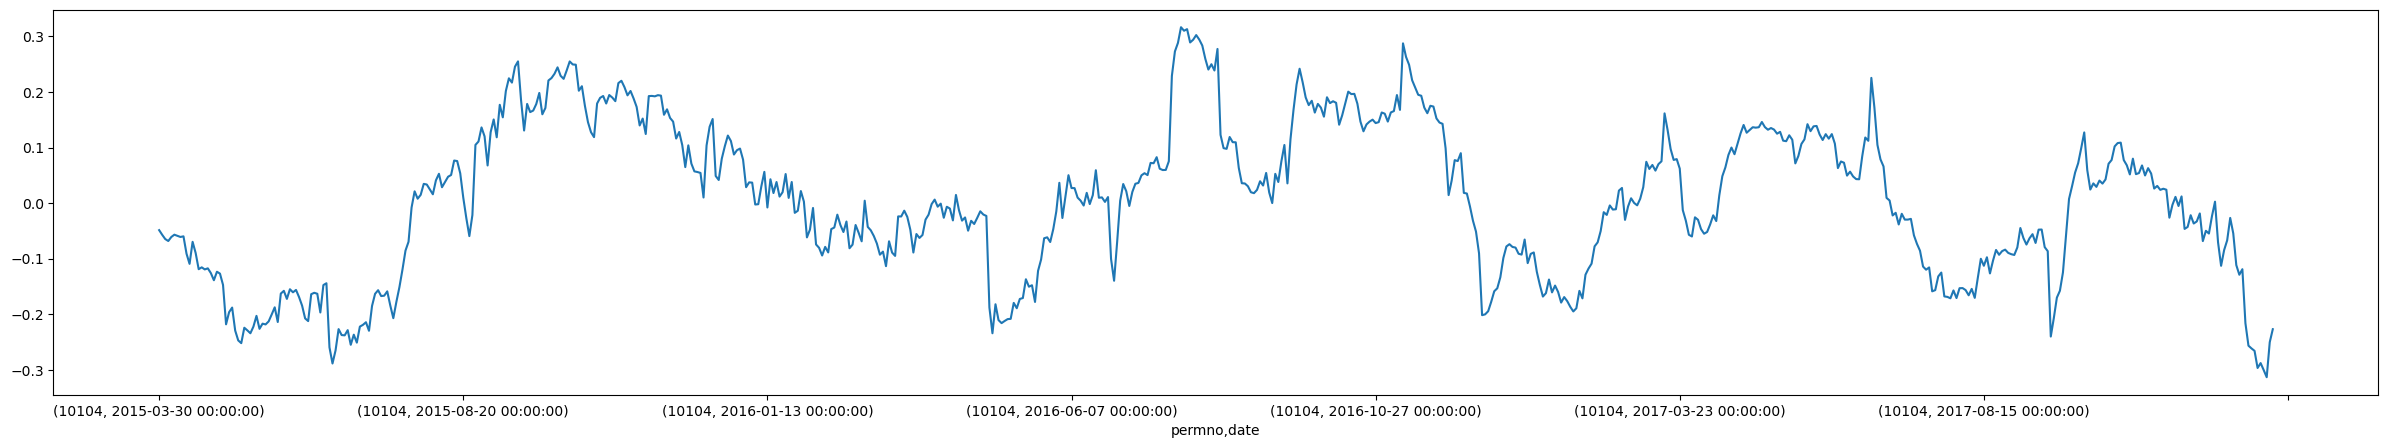

In [209]:
get_stock_data(total, 10104).TrendFactor.plot(figsize=(30,5))

<AxesSubplot:xlabel='permno,date'>

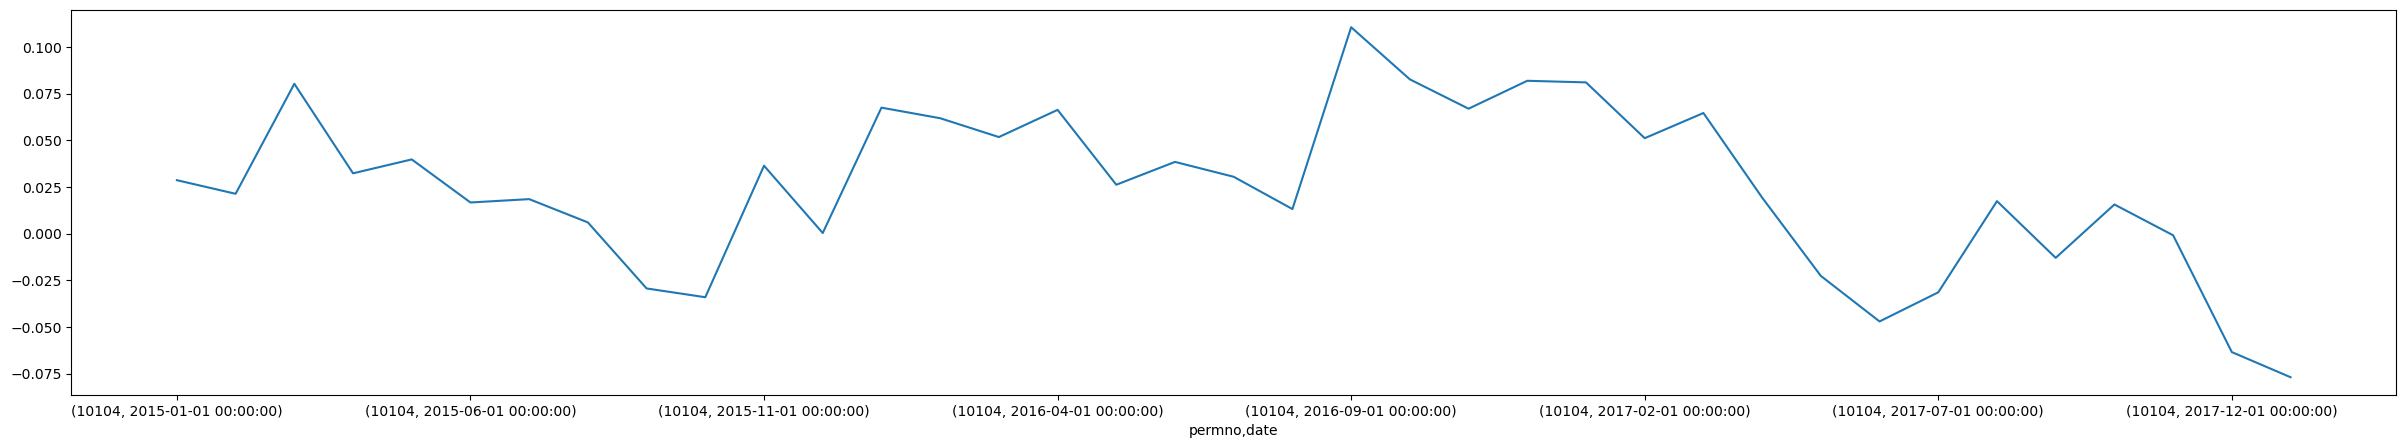

In [186]:
set_timeframe(get_stock_data(open_asset, 10104), start, end).TrendFactor.plot(figsize=(30,5))

# Testing ffill for max amount of days

In [162]:
open_asset = pd.read_parquet(get_load_data_parquet_dir() / 'data_open_asset.parquet.brotli')

In [163]:
data = pd.read_parquet(get_factor_dir(live) / 'factor_net_debt_finance.parquet.brotli')

<AxesSubplot:xlabel='permno,date'>

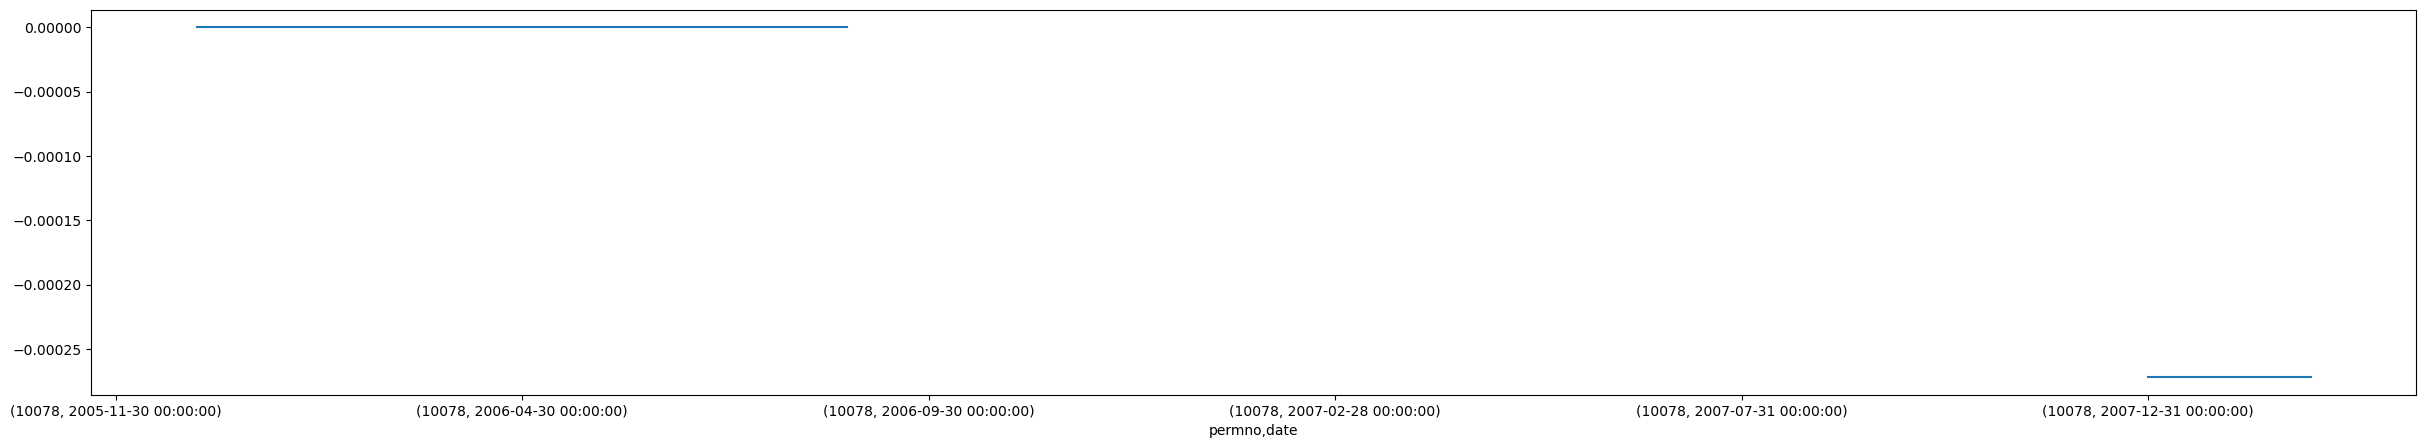

In [164]:
get_stock_data(data, 10078).NetDebtFinance.plot(figsize=(30,5))

In [165]:
date_data = pd.read_parquet(get_load_data_parquet_dir() / 'data_date.parquet.brotli')
date_data = set_timeframe(date_data, start, end)
data = pd.merge(date_data.loc[stock], data, left_index=True, right_index=True, how='left')
data = data.loc[~data.index.duplicated(keep='first')]

In [186]:
df = get_stock_data(data, 10078)

<AxesSubplot:xlabel='permno,date'>

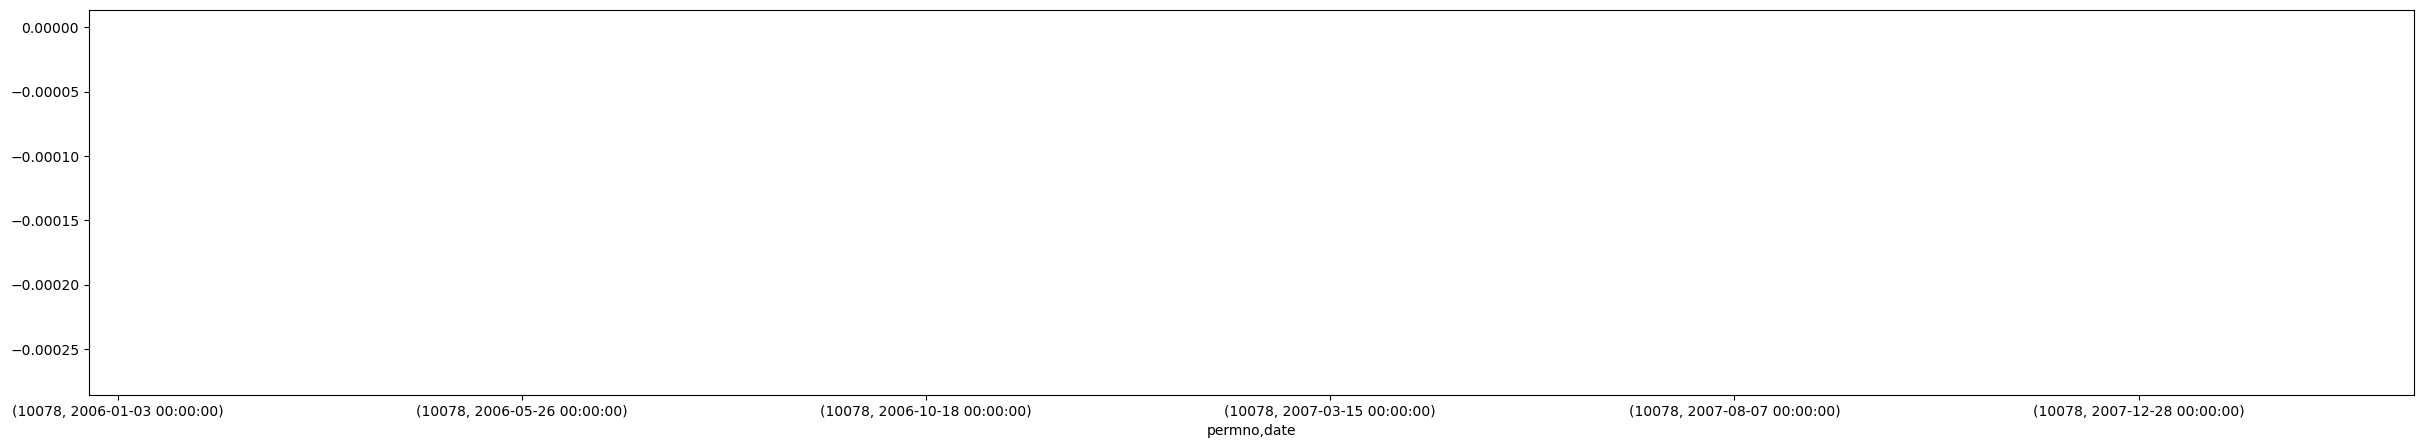

In [187]:
get_stock_data(df, 10078).NetDebtFinance.plot(figsize=(30,5))

In [188]:
def ffill_max_days(df, max_days):
    # Create a new dataframe to store the filled values
    df_filled = df.copy()
    
    # Loop through all columns in the dataframe
    for col in df.columns:
        last_valid_idx = None
        
        for idx in df_filled.index:
            # If the current row contains a NaN value
            if pd.isna(df_filled.at[idx, col]):
                # If we've seen a valid index before and the gap is within max_days
                if (last_valid_idx is not None and 
                    (idx - last_valid_idx).days <= max_days):
                    df_filled.at[idx, col] = df_filled.at[last_valid_idx, col]
            else:
                last_valid_idx = idx
                
    return df_filled

In [189]:
def ffill_max_days(df, max_days):
    # Resample to daily and forward fill
    df_daily = df.resample('D').ffill()

    # Find where gaps in the original data are larger than max_days
    mask = df.index.to_series().diff().fillna(pd.Timedelta(days=0)) > pd.Timedelta(days=max_days)
    excluded_dates = df.index[mask]

    # Filter out rows that exceed the max_days from the daily DataFrame
    for date in excluded_dates:
        start_date = date - pd.Timedelta(days=max_days)
        df_daily.loc[start_date:date] = np.nan

    # Return the DataFrame with the original dates
    return df_daily.reindex(df.index)

In [190]:
df = df.reset_index().set_index('date')
df = ffill_max_days(df, max_days=21)
df = df.reset_index().set_index(['permno', 'date']).sort_index(level=['permno', 'date'])

In [176]:
# df = df.fillna(method='ffill', limit=30)

<AxesSubplot:xlabel='permno,date'>

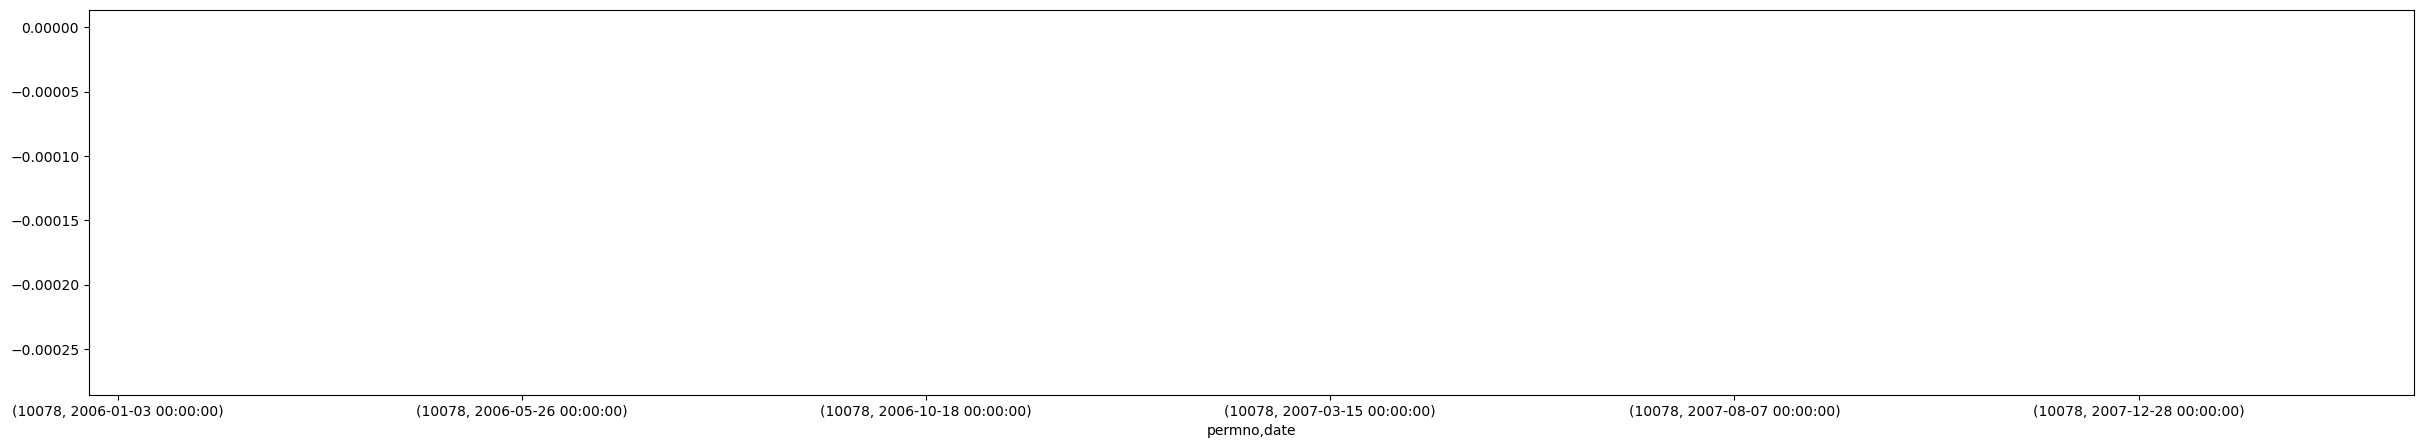

In [191]:
df.NetDebtFinance.plot(figsize=(30,5))

# Compt Dept

Creating factor_comp_debt ---------------------------------- | ✔
Shape: (3272531, 1)


<AxesSubplot:xlabel='permno,date'>

-

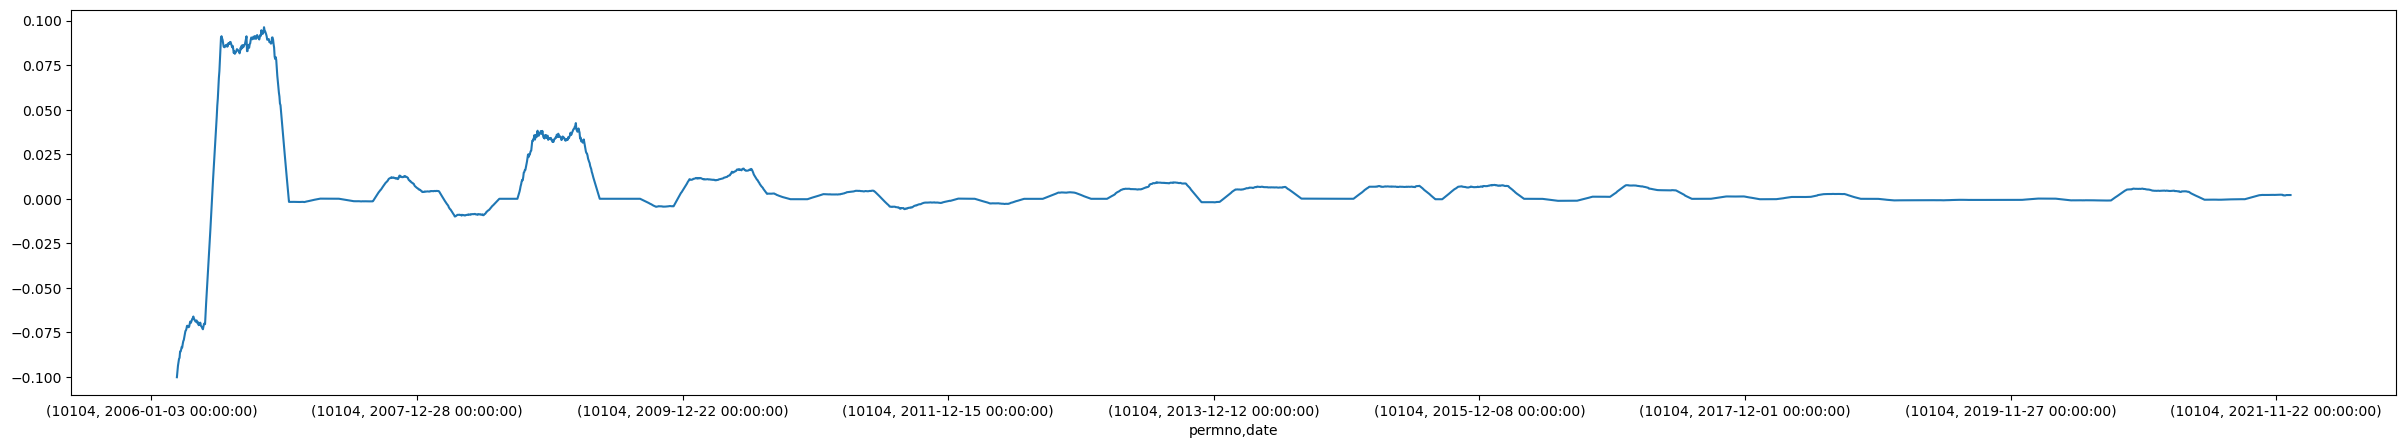

-

In [282]:
comp_debt = PrepFactor(factor_name='factor_comp_debt', group='permno', interval='M', kind='fundamental', stock=stock, div=False, start=start, end=end, save=False).prep()
get_stock_data(comp_debt, 10104).CompositeDebtIssuance.plot(figsize=(30,5))

<AxesSubplot:xlabel='permno,date'>

\

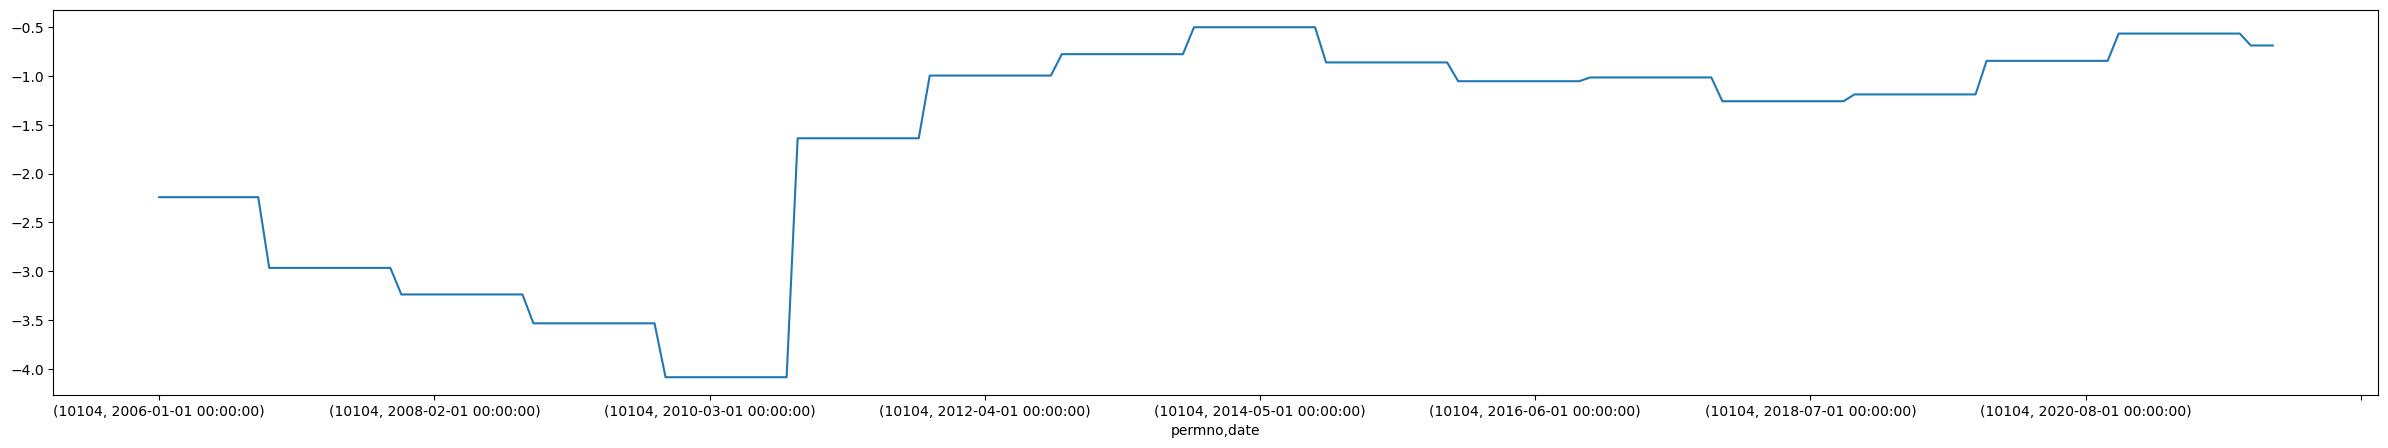

-

In [283]:
set_timeframe(get_stock_data(open_asset, 10104), start, end).CompositeDebtIssuance.plot(figsize=(30,5))

# MS

Creating factor_ms ----------------------------------------- | ✔
Shape: (3272531, 1)


<AxesSubplot:xlabel='permno,date'>

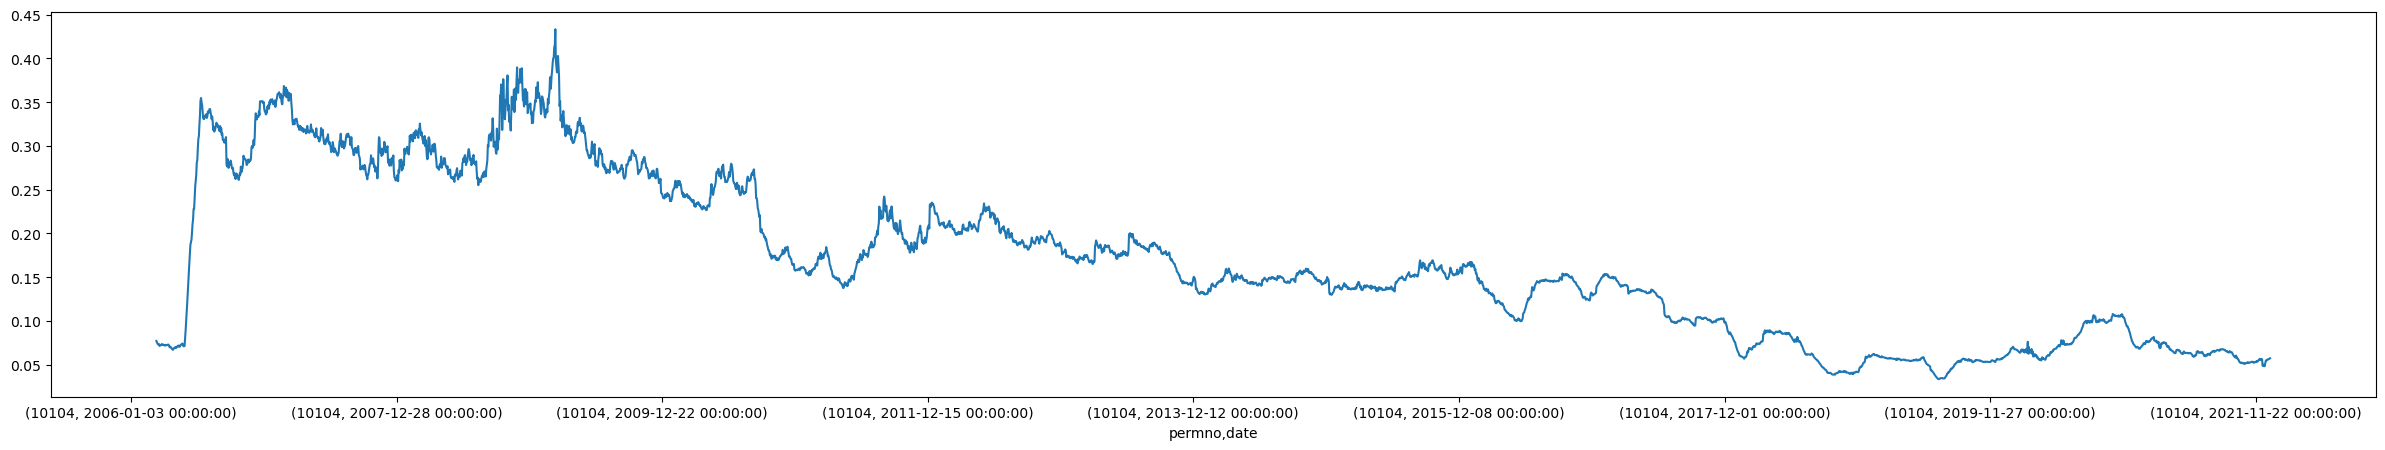

In [276]:
ms = PrepFactor(factor_name='factor_ms', group='permno', interval='M', kind='fundamental', stock=stock, div=False, start=start, end=end, save=False).prep()
get_stock_data(ms, 10104).MS.plot(figsize=(30,5))

<AxesSubplot:xlabel='permno,date'>

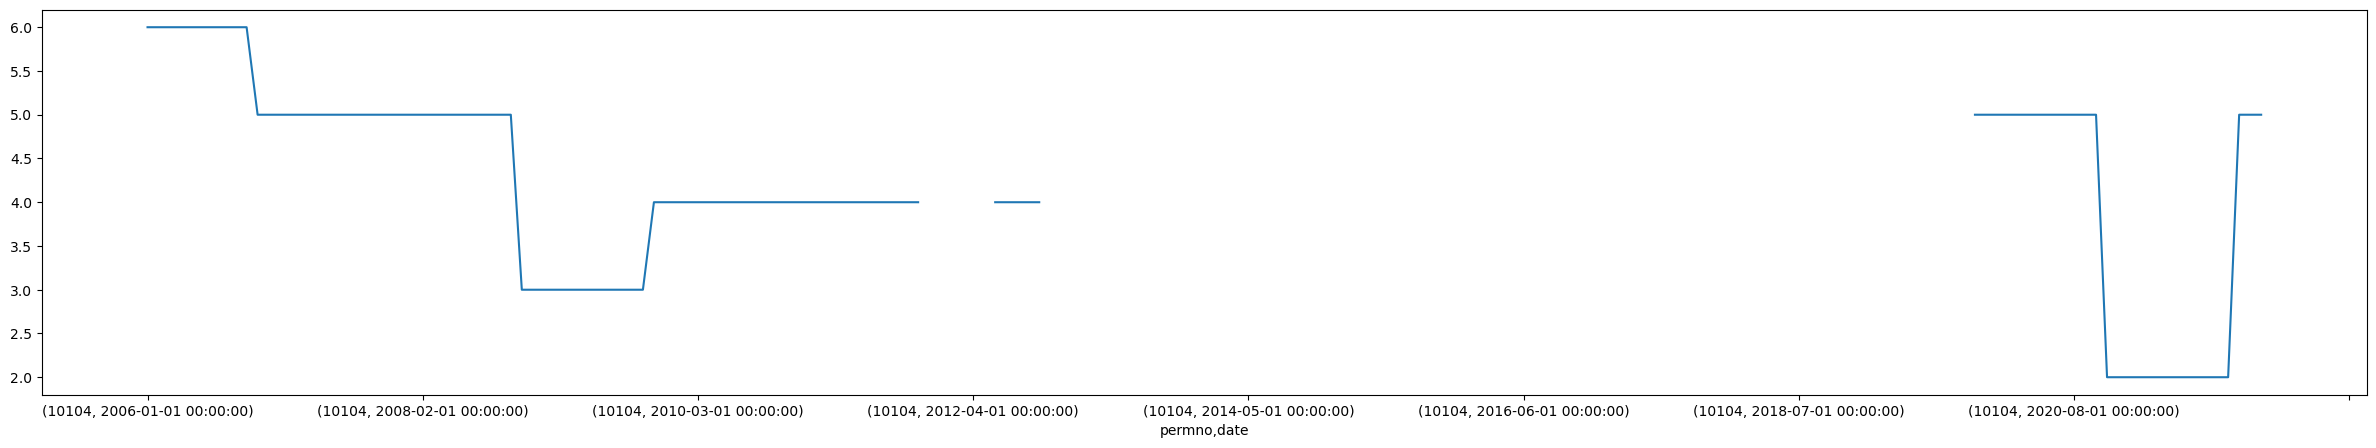

In [277]:
set_timeframe(get_stock_data(open_asset, 10104), start, end).MS.plot(figsize=(30,5))

# NOA

Creating factor_noa ---------------------------------------- | ✔
Shape: (3272531, 1)


<AxesSubplot:xlabel='permno,date'>

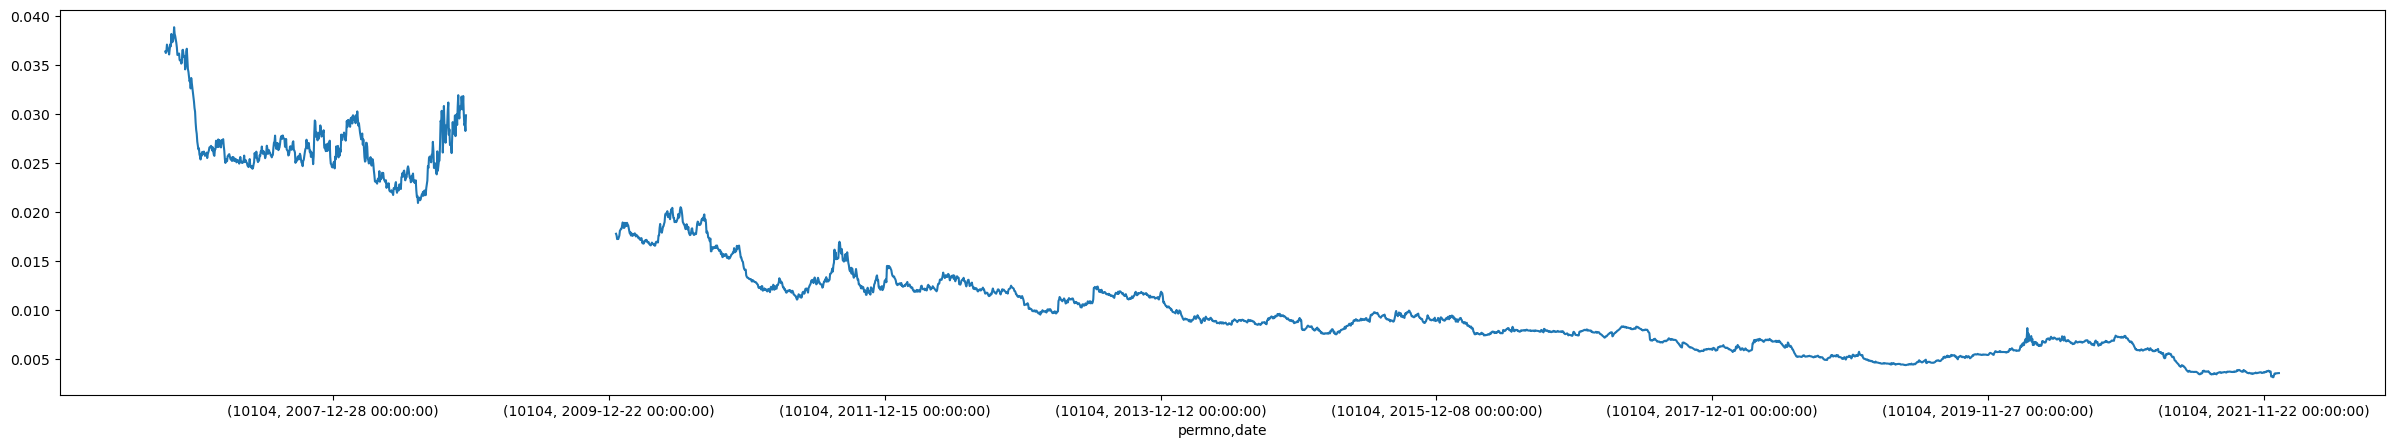

In [250]:
noa = PrepFactor(factor_name='factor_noa', group='permno', interval='M', kind='fundamental', stock=stock, div=False, start=start, end=end, save=False).prep()
get_stock_data(noa, 10104).NOA.plot(figsize=(30,5))

<AxesSubplot:xlabel='permno,date'>

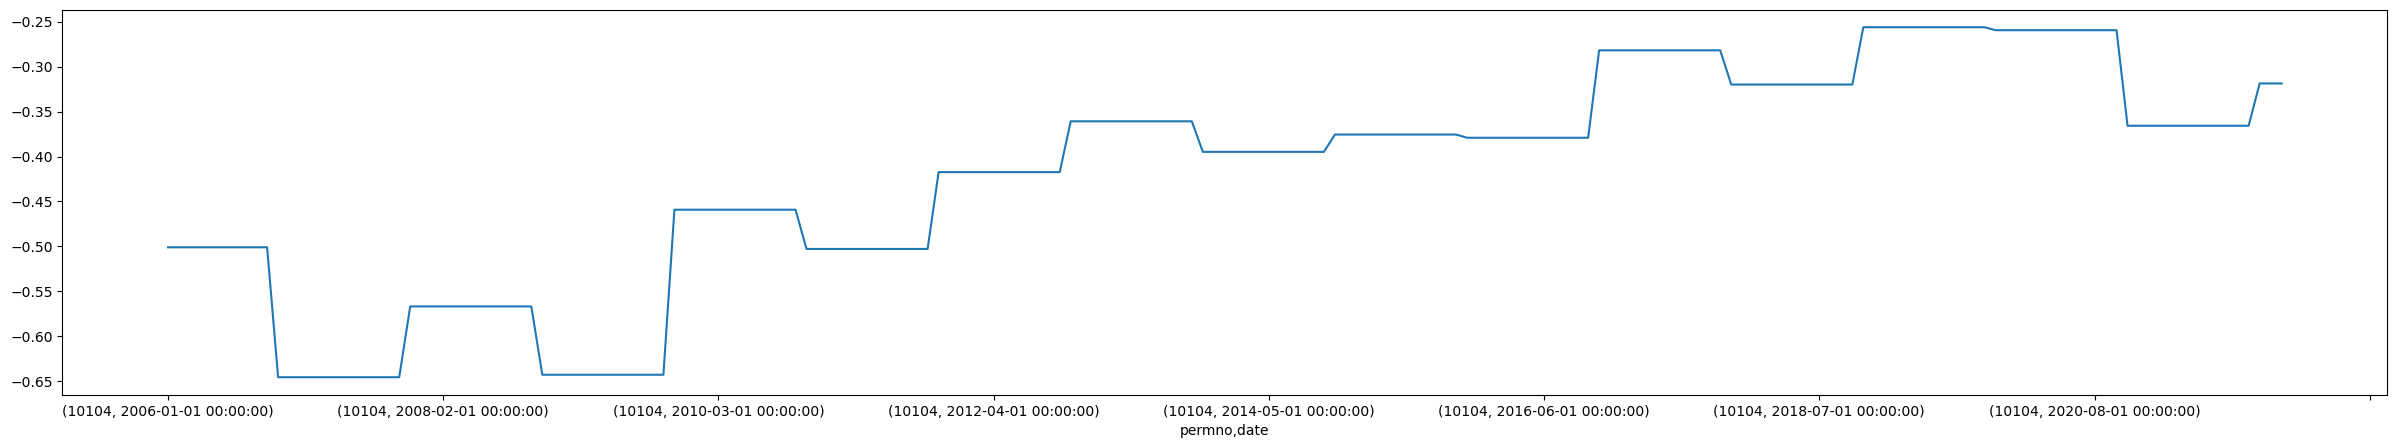

In [251]:
set_timeframe(get_stock_data(open_asset, 10104), start, end).NOA.plot(figsize=(30,5))

# Asset Growth

Creating factor_asset_growth ------------------------------- | ✔
Shape: (3272531, 1)


<AxesSubplot:xlabel='permno,date'>

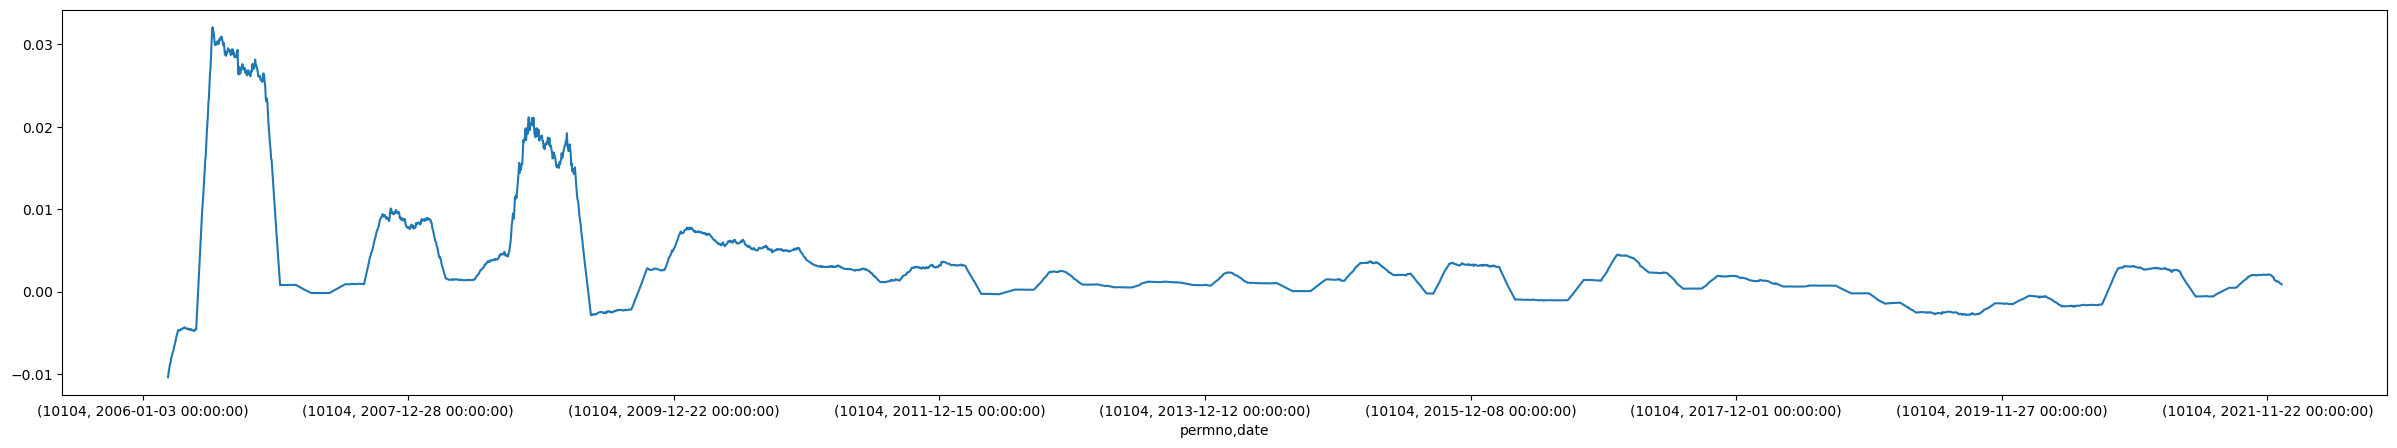

In [248]:
asset_growth = PrepFactor(factor_name='factor_asset_growth', group='permno', interval='M', kind='fundamental', stock=stock, div=False, start=start, end=end, save=False).prep()
get_stock_data(asset_growth, 10104).AssetGrowth.plot(figsize=(30,5))

<AxesSubplot:xlabel='permno,date'>

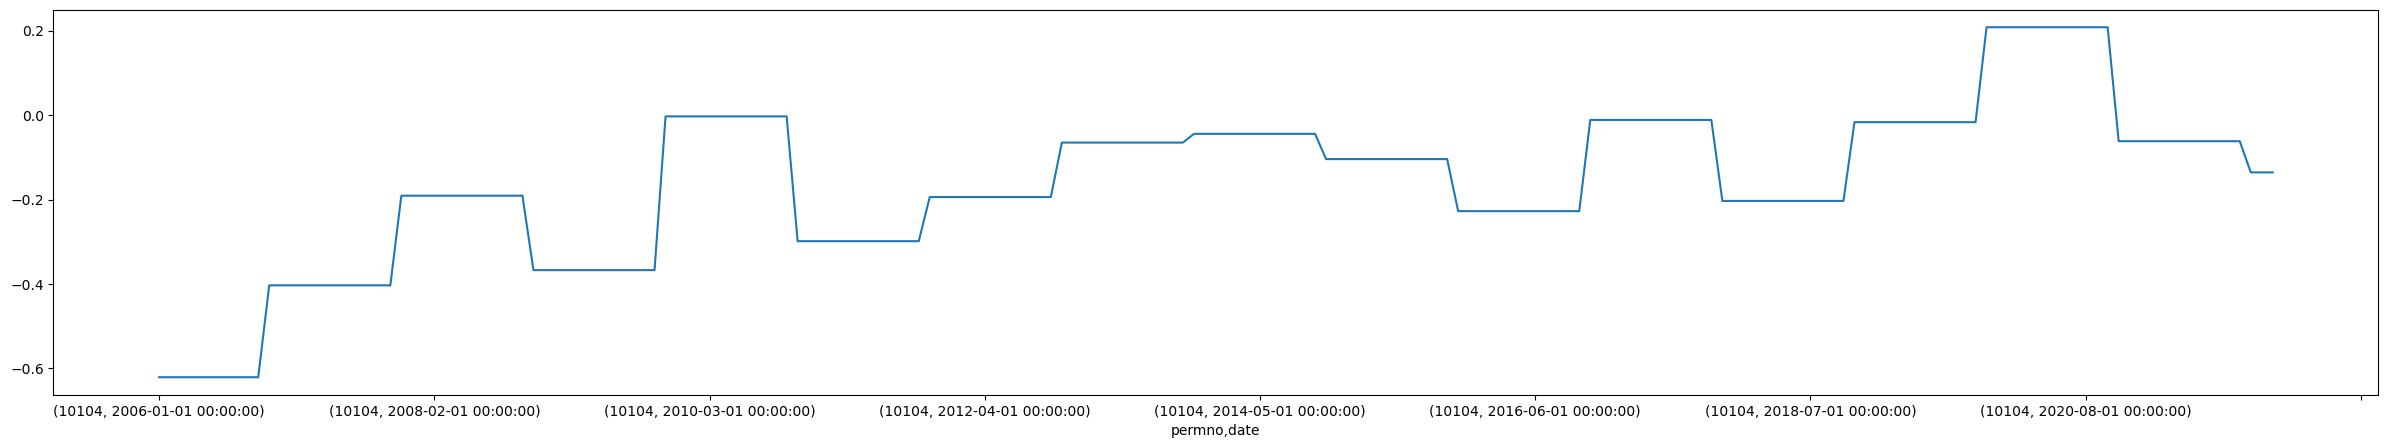

In [249]:
set_timeframe(get_stock_data(open_asset, 10104), start, end).AssetGrowth.plot(figsize=(30,5))

# Accural

Creating factor_accrual ------------------------------------ | ✔
Shape: (3272531, 1)


<AxesSubplot:xlabel='permno,date'>

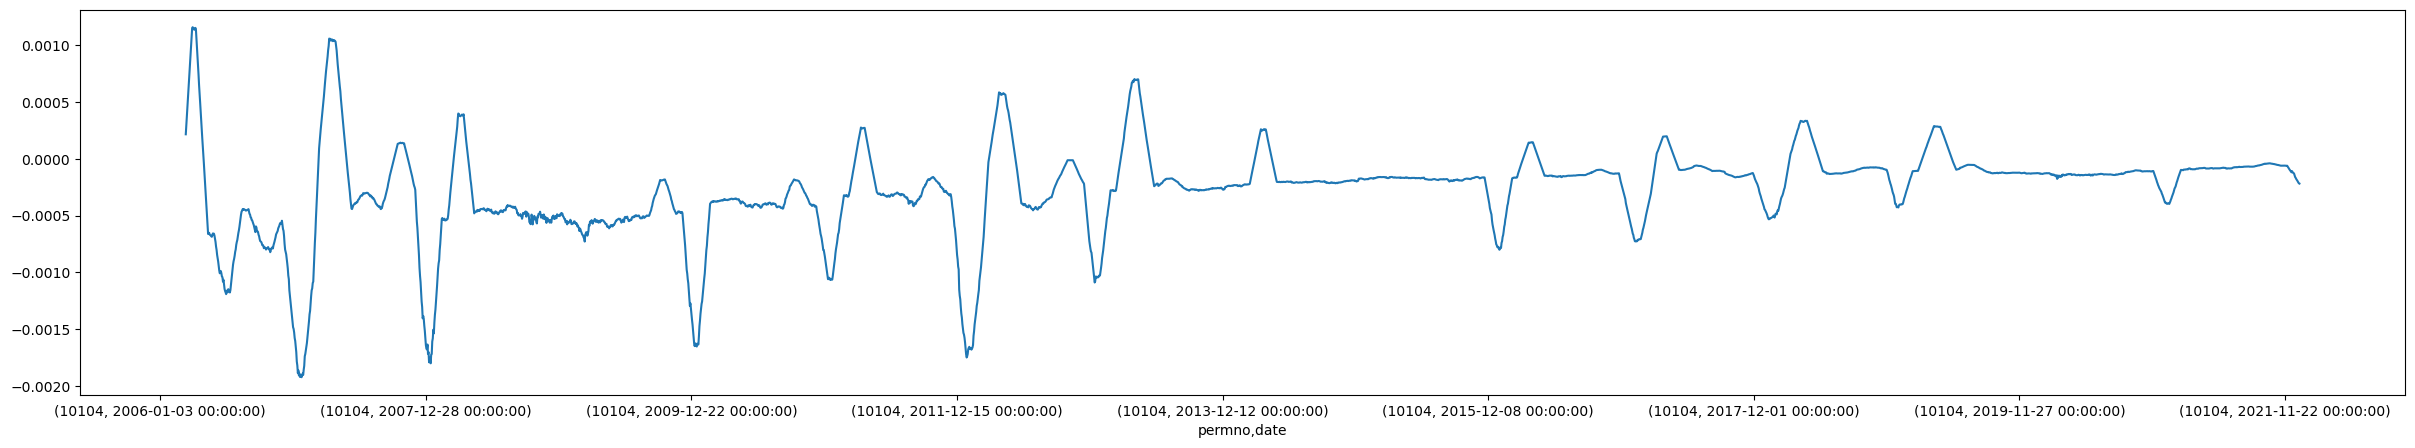

In [256]:
accrual = PrepFactor(factor_name='factor_accrual', group='permno', interval='M', kind='fundamental', stock=stock, div=True, start=start, end=end, save=False).prep()
get_stock_data(accrual, 10104).Accruals.plot(figsize=(30,5))

<AxesSubplot:xlabel='permno,date'>

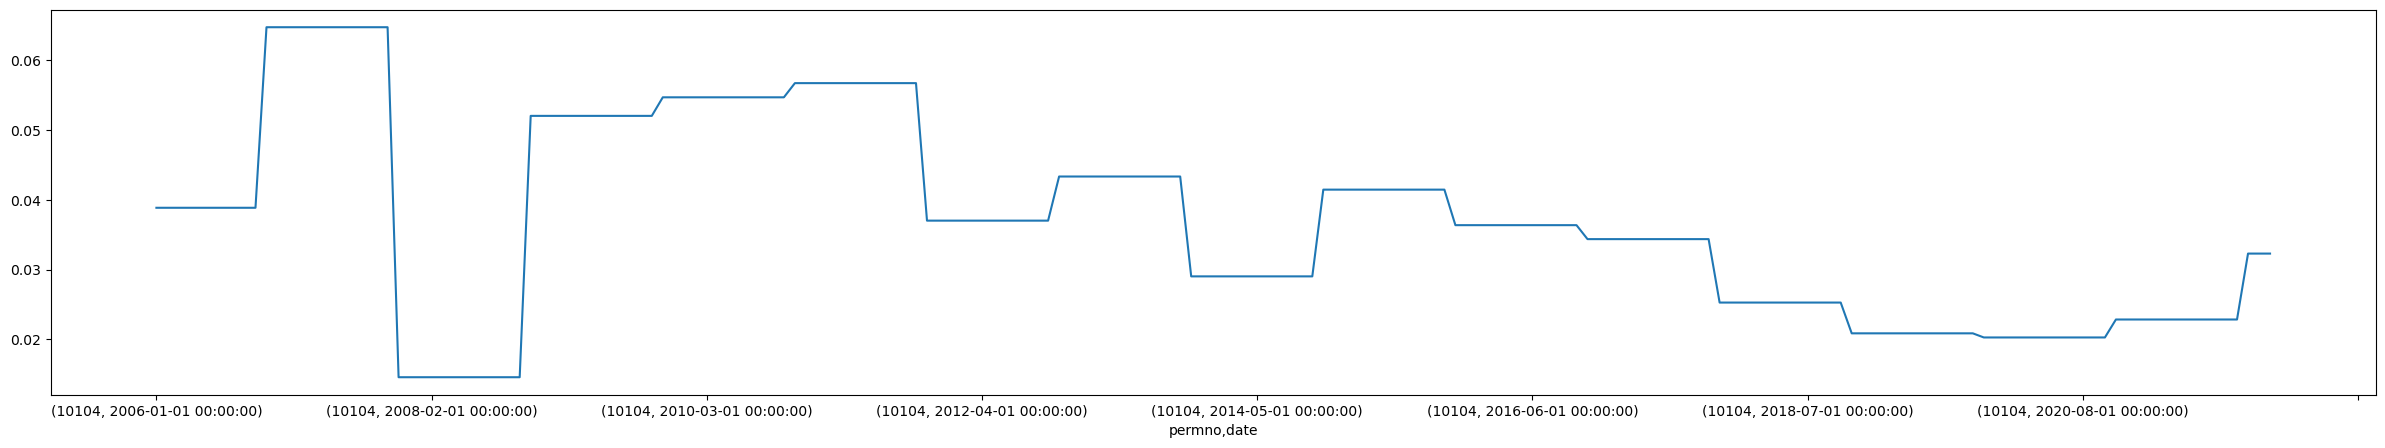

In [260]:
set_timeframe(get_stock_data(open_asset, 10104), start, end).Accruals.plot(figsize=(30,5))

# XFIN

Creating factor_xfin --------------------------------------- | ✔
Shape: (3272531, 1)
\

<AxesSubplot:xlabel='permno,date'>

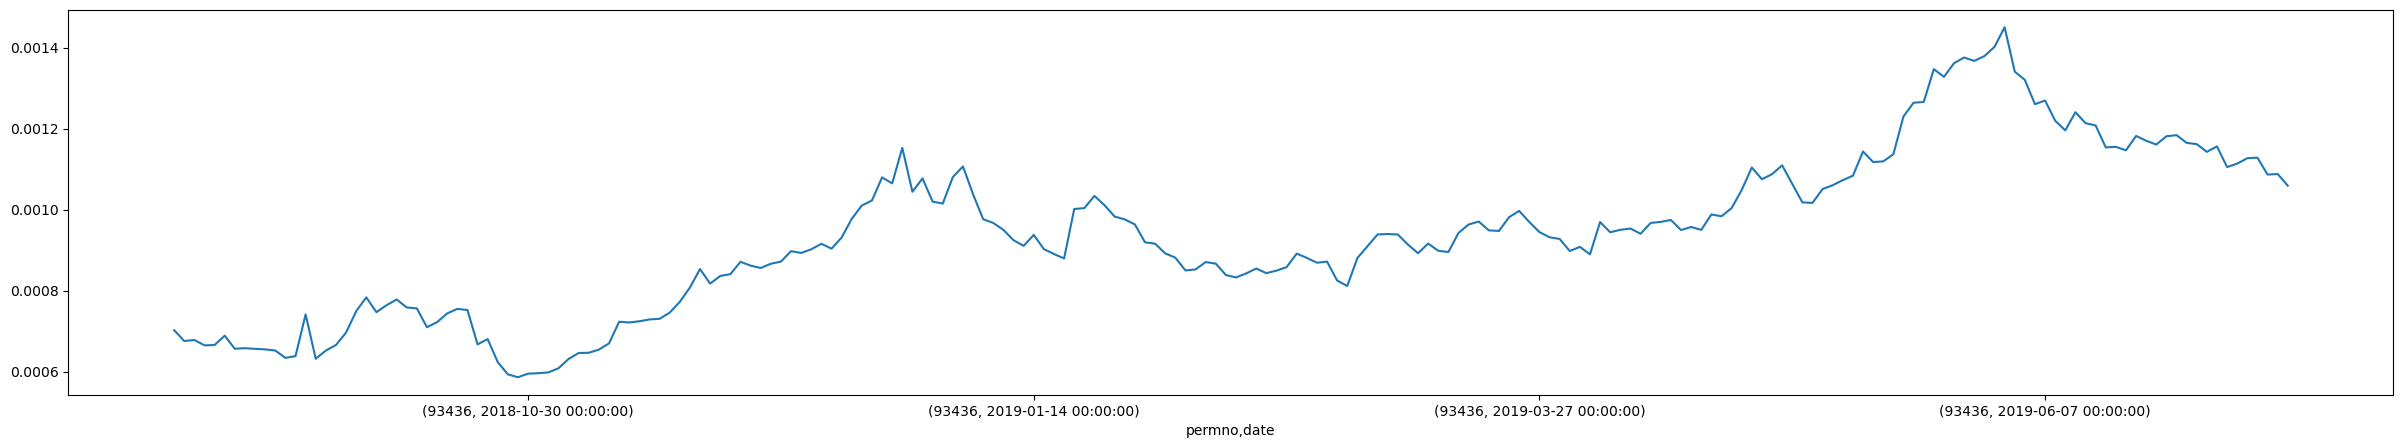

/

In [303]:
xfin = PrepFactor(factor_name='factor_xfin', group='permno', interval='M', kind='fundamental', stock=stock, div=True, start=start, end=end, save=False).prep()
get_stock_data(xfin, 93436).xfin.plot(figsize=(30,5))

<AxesSubplot:xlabel='permno,date'>

-

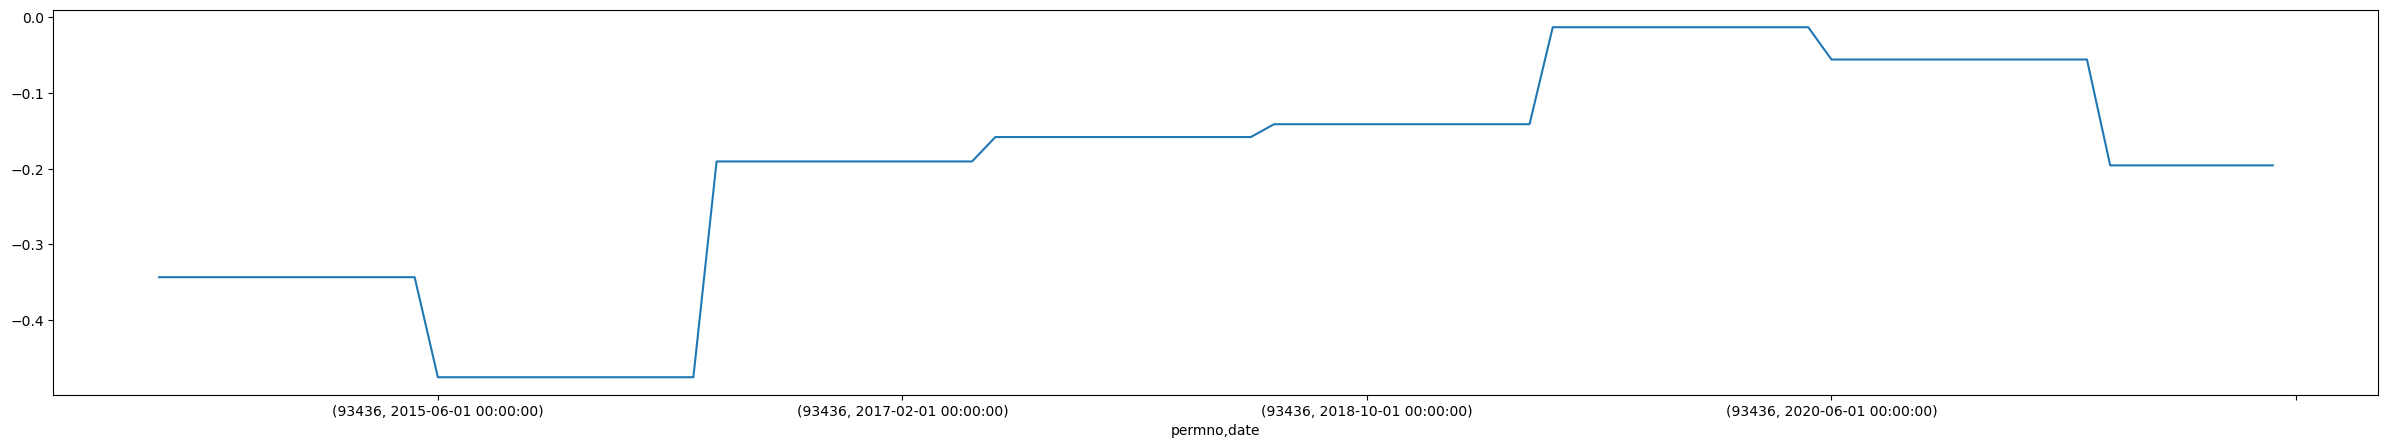

-

In [304]:
set_timeframe(get_stock_data(open_asset, 93436), start, end).XFIN.plot(figsize=(30,5))

# Invest PPE

Creating factor_invest_ppe_inv ----------------------------- | ✔
Shape: (3272531, 1)


<AxesSubplot:xlabel='permno,date'>

-

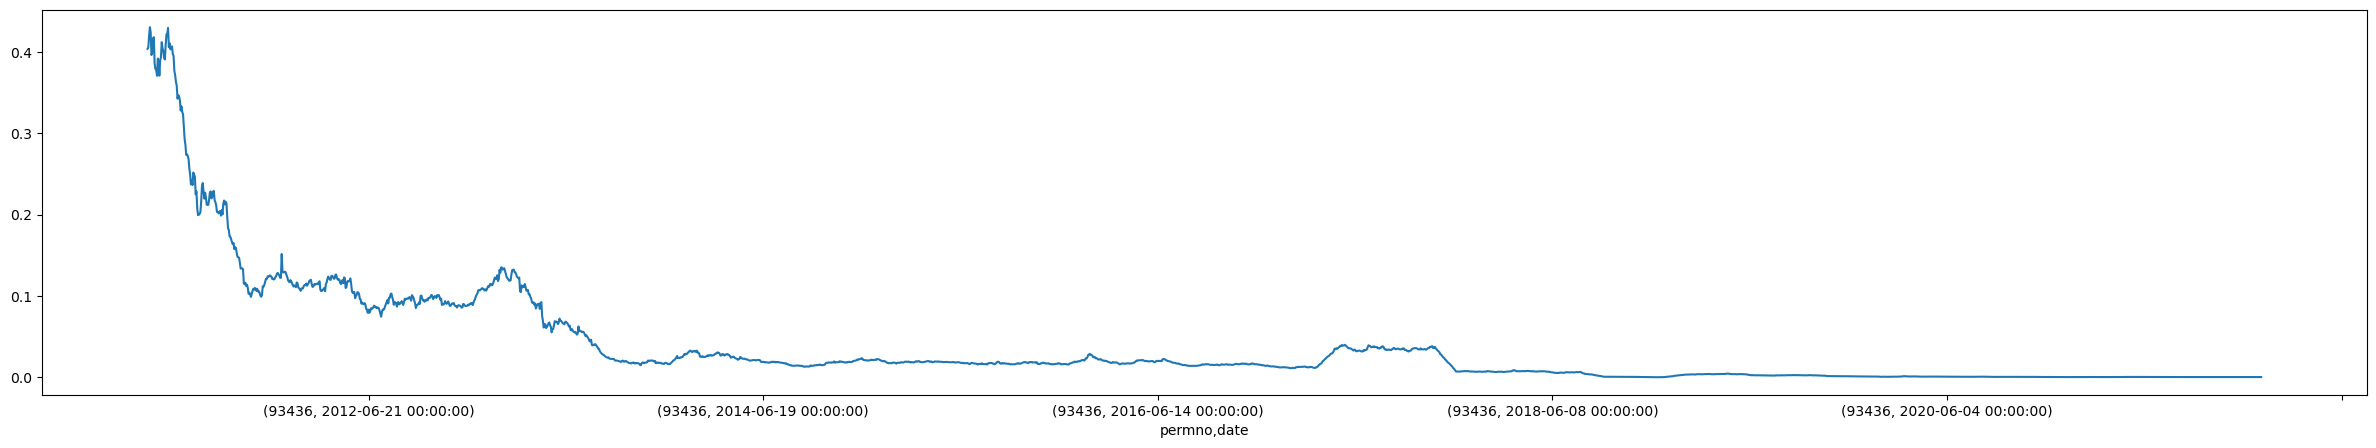

/

In [309]:
invest_ppe = PrepFactor(factor_name='factor_invest_ppe_inv', group='permno', interval='M', kind='fundamental', stock=stock, div=True, start=start, end=end, save=False).prep()
get_stock_data(invest_ppe, 93436).InvestPPEInv.plot(figsize=(30,5))

\

<AxesSubplot:xlabel='permno,date'>

-

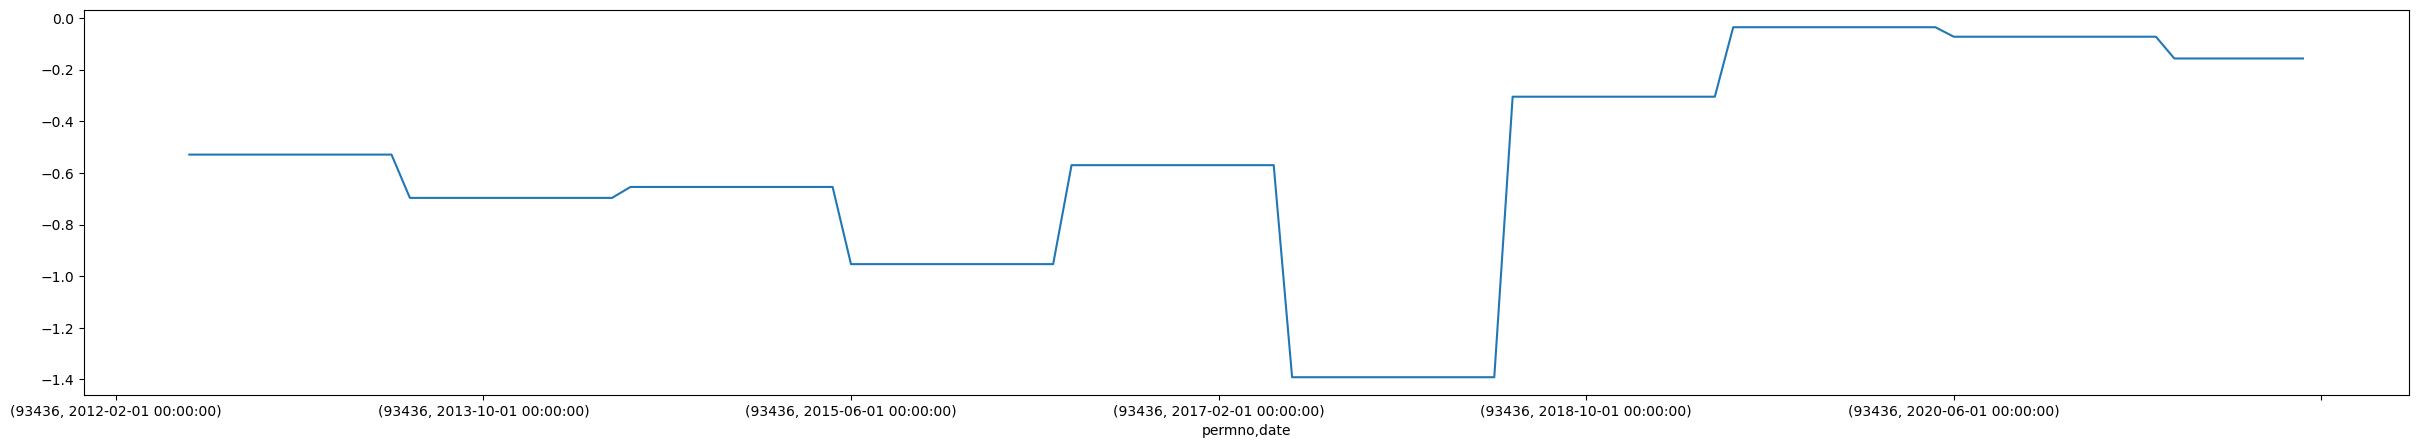

\

In [310]:
set_timeframe(get_stock_data(open_asset, 93436), start, end).InvestPPEInv.plot(figsize=(30,5))

# Inv Growth

Creating factor_inv_growth ---------------------------------/| ✔
Shape: (3272531, 1)


<AxesSubplot:xlabel='permno,date'>

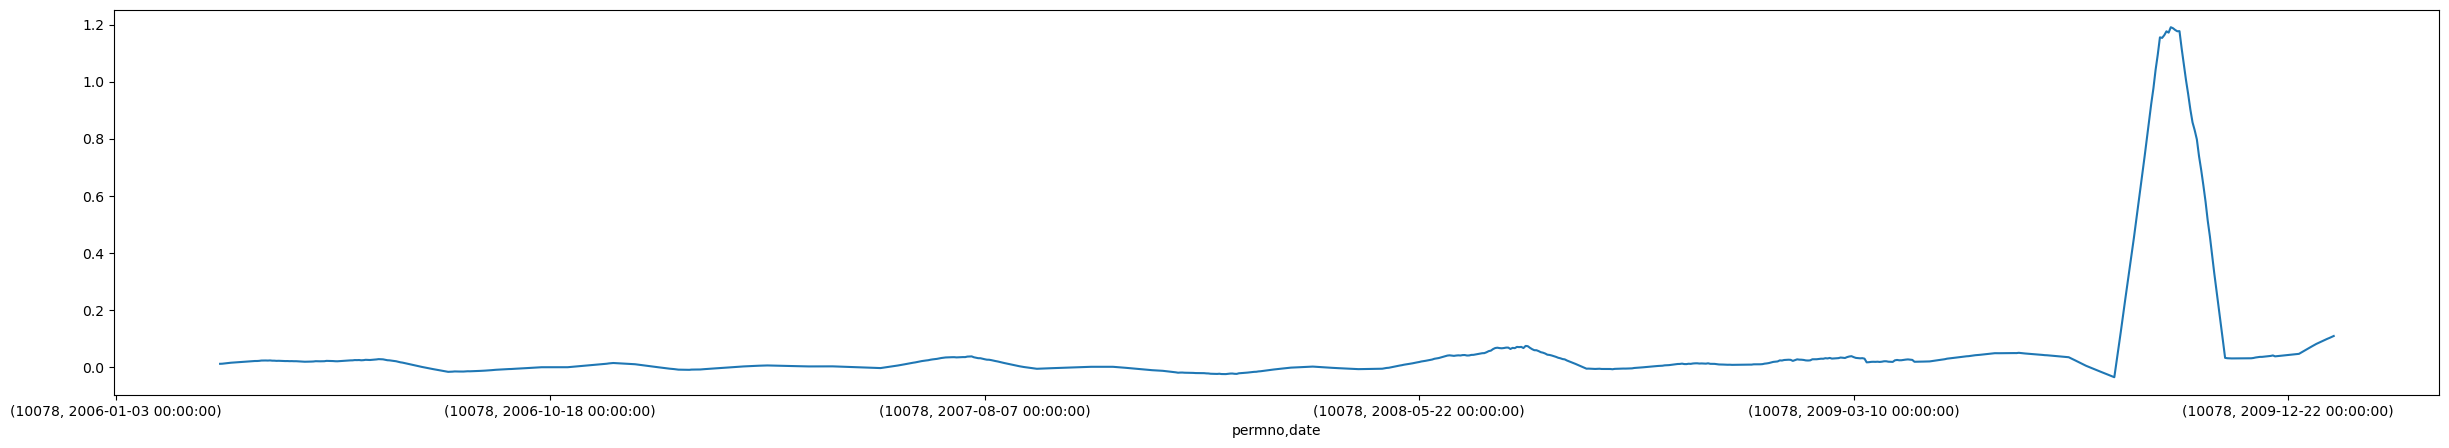

-\

In [318]:
inv_growth = PrepFactor(factor_name='factor_inv_growth', group='permno', interval='M', kind='fundamental', stock=stock, div=True, start=start, end=end, save=False).prep()
get_stock_data(inv_growth, 10078).InvGrowth.plot(figsize=(30,5))

<AxesSubplot:xlabel='permno,date'>

\|

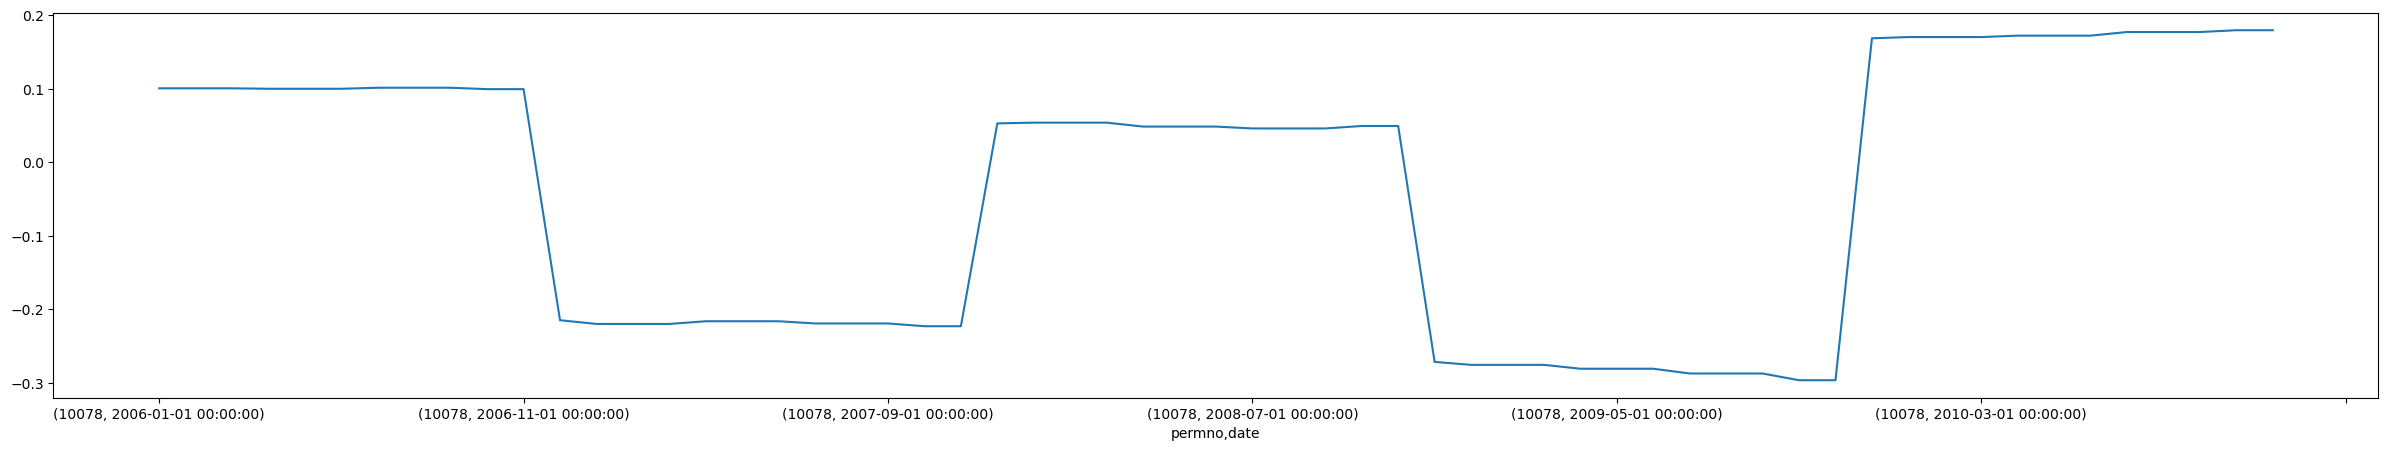

|/

In [319]:
set_timeframe(get_stock_data(open_asset, 10078), start, end).InvGrowth.plot(figsize=(30,5))

# Net Debt Finance

In [261]:
columns = ['dlcchy', 'dltisy', 'dltry', 'atq']
net_debt = pd.read_parquet(get_load_data_parquet_dir() / 'data_fund_raw.parquet.brotli', columns=columns)

In [264]:
net_debt.dropna()

dlcchy    dltisy     dltry        atq
permno date                                             
10078  2005-12-31     0.0     0.000     0.000  14474.000
       2006-01-31     0.0     0.000     0.000  14474.000
       2006-02-28     0.0     0.000     0.000  14474.000
       2006-03-31     0.0     0.000     0.000  14308.000
       2006-04-30     0.0     0.000     0.000  14308.000
...                   ...       ...       ...        ...
93436  2018-10-31   -17.5  3043.227  2517.416  27910.000
       2018-11-30   -17.5  3043.227  2517.416  27910.000
       2018-12-31  -100.0  3946.575  3560.195  29262.713
       2019-01-31  -100.0  3946.575  3560.195  29262.713
       2019-02-28  -100.0  3946.575  3560.195  29262.713

[92988 rows x 4 columns]

In [278]:
net_debt_finance

NetDebtFinance
permno date                      
10078  2006-01-03             NaN
       2006-01-04             NaN
       2006-01-05             NaN
       2006-01-06             NaN
       2006-01-09             NaN
...                           ...
93436  2021-12-27             NaN
       2021-12-28             NaN
       2021-12-29             NaN
       2021-12-30             NaN
       2021-12-31             NaN

[3272531 rows x 1 columns]

Creating factor_net_debt_finance --------------------------- | ✔
Shape: (3272531, 1)


<AxesSubplot:xlabel='permno,date'>

/

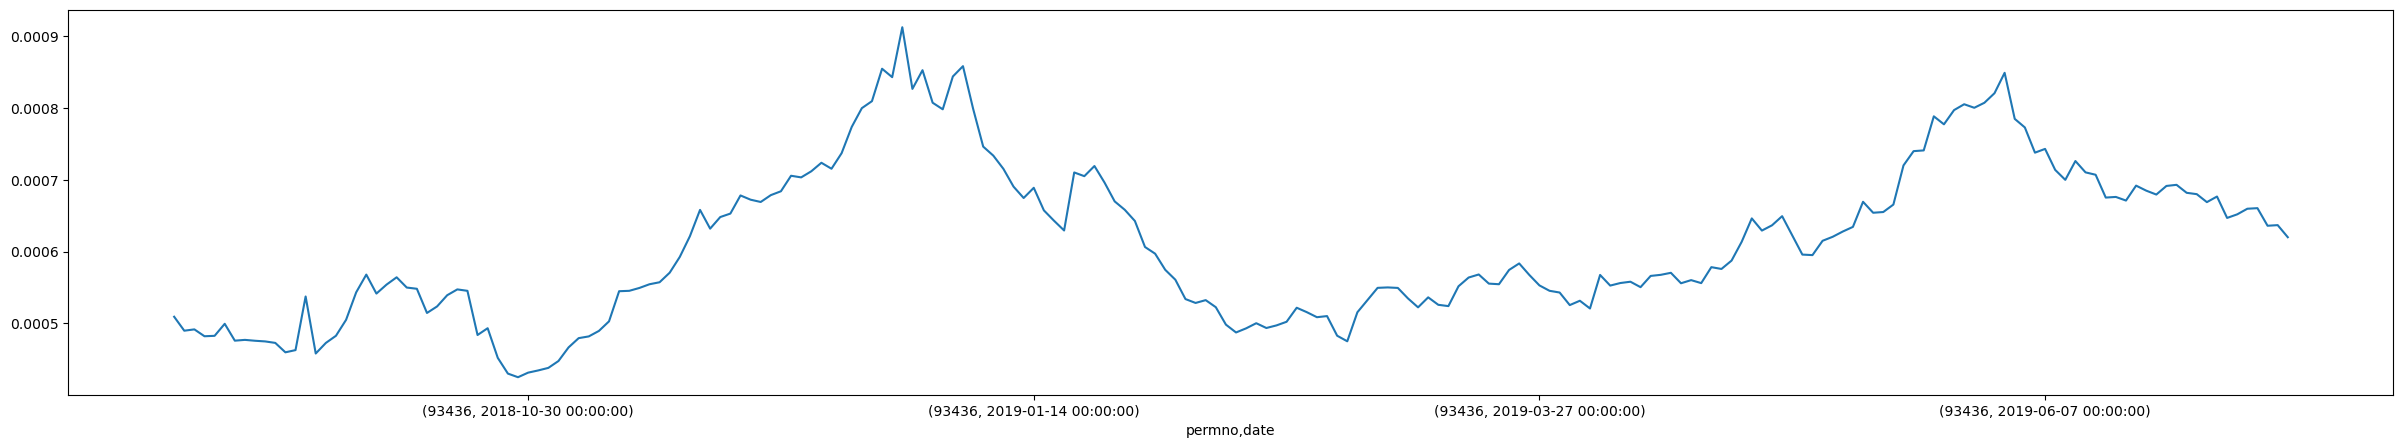

|

In [300]:
net_debt_finance = PrepFactor(factor_name='factor_net_debt_finance', group='permno', interval='M', kind='fundamental', stock=stock, div=True, start=start, end=end, save=False).prep()
get_stock_data(net_debt_finance, 93436).NetDebtFinance.plot(figsize=(30,5))

<AxesSubplot:xlabel='permno,date'>

/

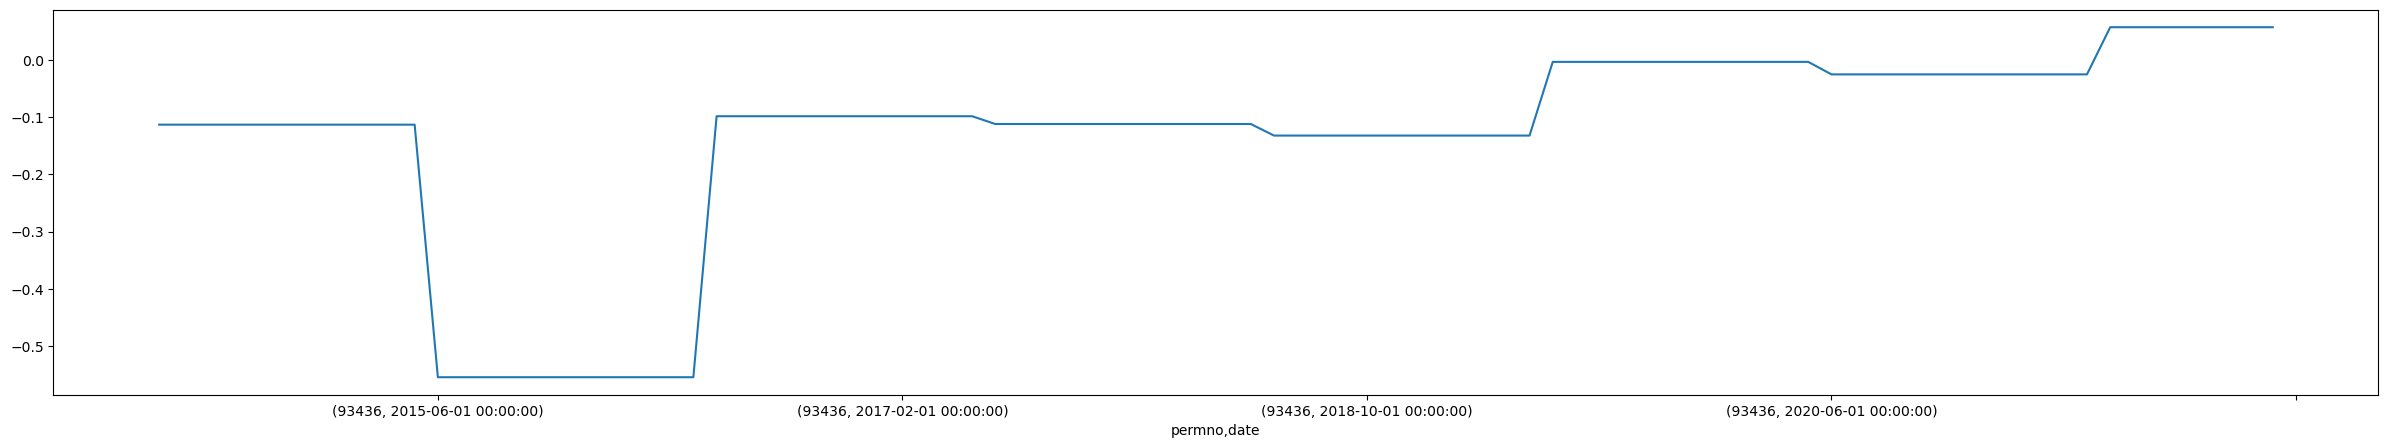

/

In [299]:
set_timeframe(get_stock_data(open_asset, 93436), start, end).NetDebtFinance.plot(figsize=(30,5))

# ChTax

In [225]:
open_asset = pd.read_parquet(get_load_data_parquet_dir() / 'data_open_asset.parquet.brotli')

In [226]:
chtax = PrepFactor(factor_name='factor_chtax', group='permno', interval='M', kind='fundamental', stock=stock, div=False, start=start, end=end, save=False).prep()

Creating factor_chtax -------------------------------------- | ✔
Shape: (3272531, 1)


<AxesSubplot:xlabel='permno,date'>

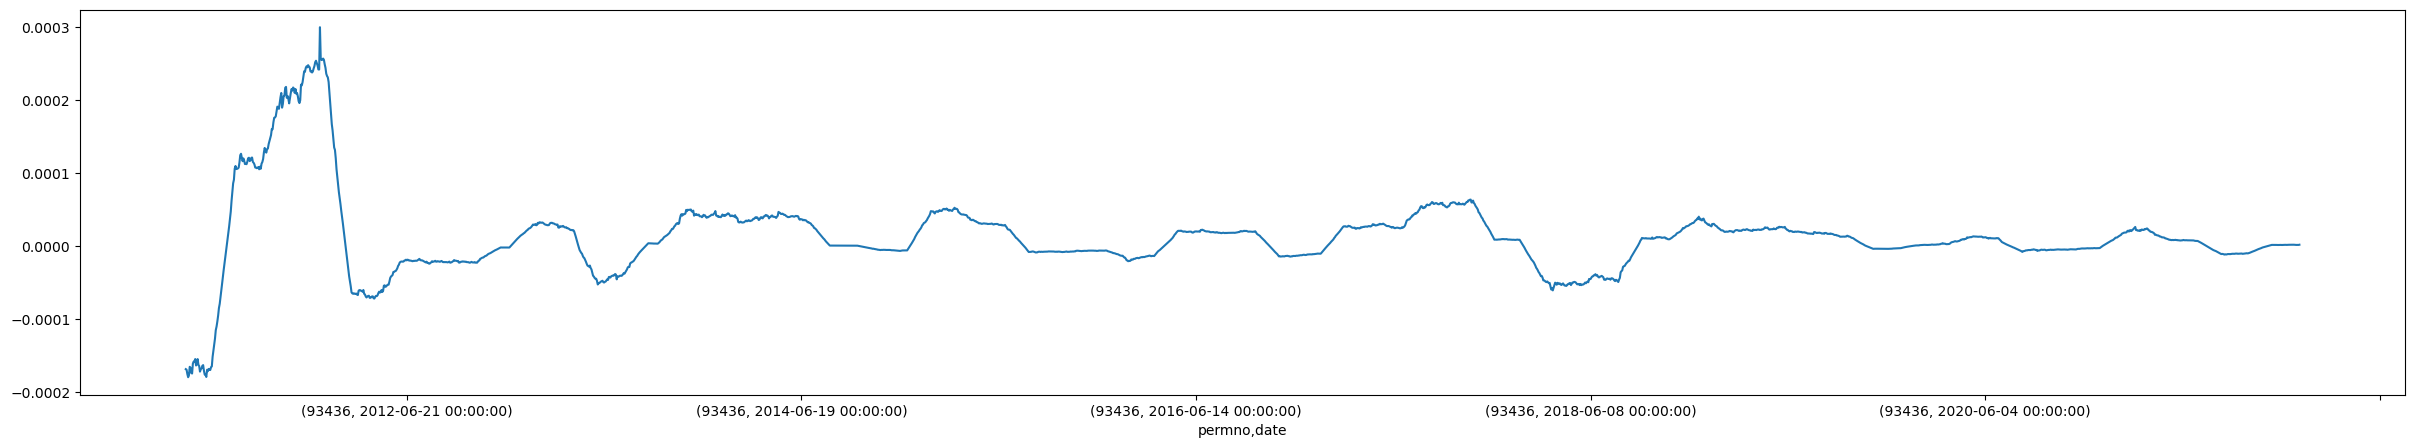

In [227]:
get_stock_data(chtax, 93436).ChTax.plot(figsize=(30,5))

<AxesSubplot:xlabel='permno,date'>

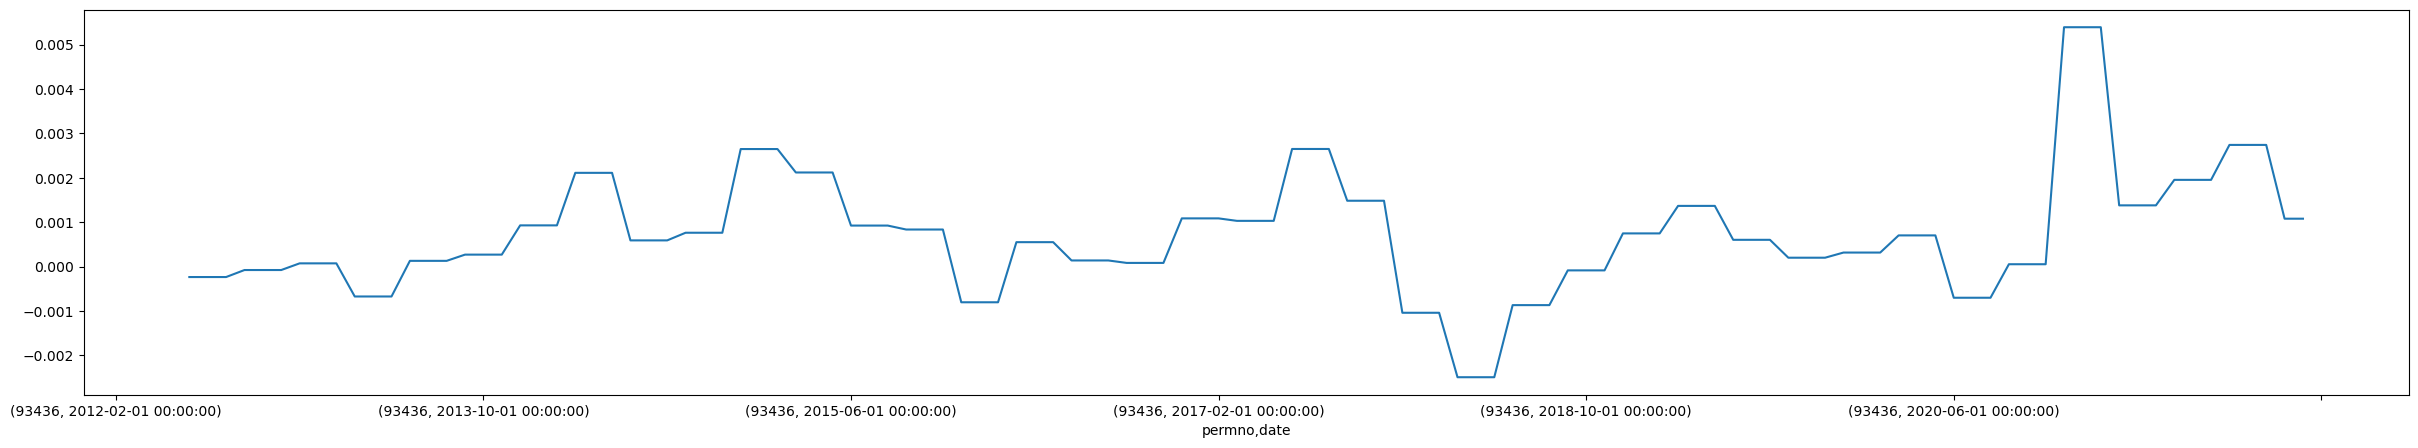

In [228]:
set_timeframe(get_stock_data(open_asset, 93436), start, end).ChTax.plot(figsize=(30,5))

# Emmult

In [288]:
columns = ['dlttq', 'dlcq', 'cheq', 'oibdpq', 'drcq']
finance = pd.read_parquet(get_load_data_parquet_dir() / 'data_fund_raw.parquet.brotli', columns=columns)
outstanding = ['outstanding']
price_data = pd.read_parquet(get_load_data_parquet_dir() / 'data_crsp.parquet.brotli', columns=outstanding)
finance = finance.sort_index()
price_data = price_data.sort_index()
price_data_reindexed = price_data.reindex(finance.index, method='ffill')
finance = finance.merge(price_data_reindexed, left_index=True, right_index=True)
finance = get_stocks_data(finance, stock)
finance['EntMult'] = ((finance['outstanding']/1000) + finance['dlttq'] + finance['dlcq'] + finance['drcq'] - finance['cheq']) / finance['oibdpq']

-

In [290]:
finance['EntMult']

permno  date      
10078   2005-06-30    31.000000
        2005-07-31    31.000000
        2005-08-31    31.000344
        2005-09-30    17.111969
        2005-10-31    17.111969
                        ...    
93436   2023-07-31    -3.059096
        2023-08-31    -3.059096
        2023-09-30    -3.177103
        2023-10-31    -3.177103
        2023-11-30    -3.177103
Name: EntMult, Length: 176977, dtype: float64

\

In [ ]:
finance

In [292]:
open_asset = pd.read_parquet(get_load_data_parquet_dir() / 'data_open_asset.parquet.brotli')

|

In [293]:
emmult = PrepFactor(factor_name='factor_emmult', group='permno', interval='M', kind='fundamental', stock=stock, div=True, start=start, end=end, save=False).prep()

Creating factor_emmult ------------------------------------- | ✔
Shape: (3272531, 1)


/

<AxesSubplot:xlabel='permno,date'>

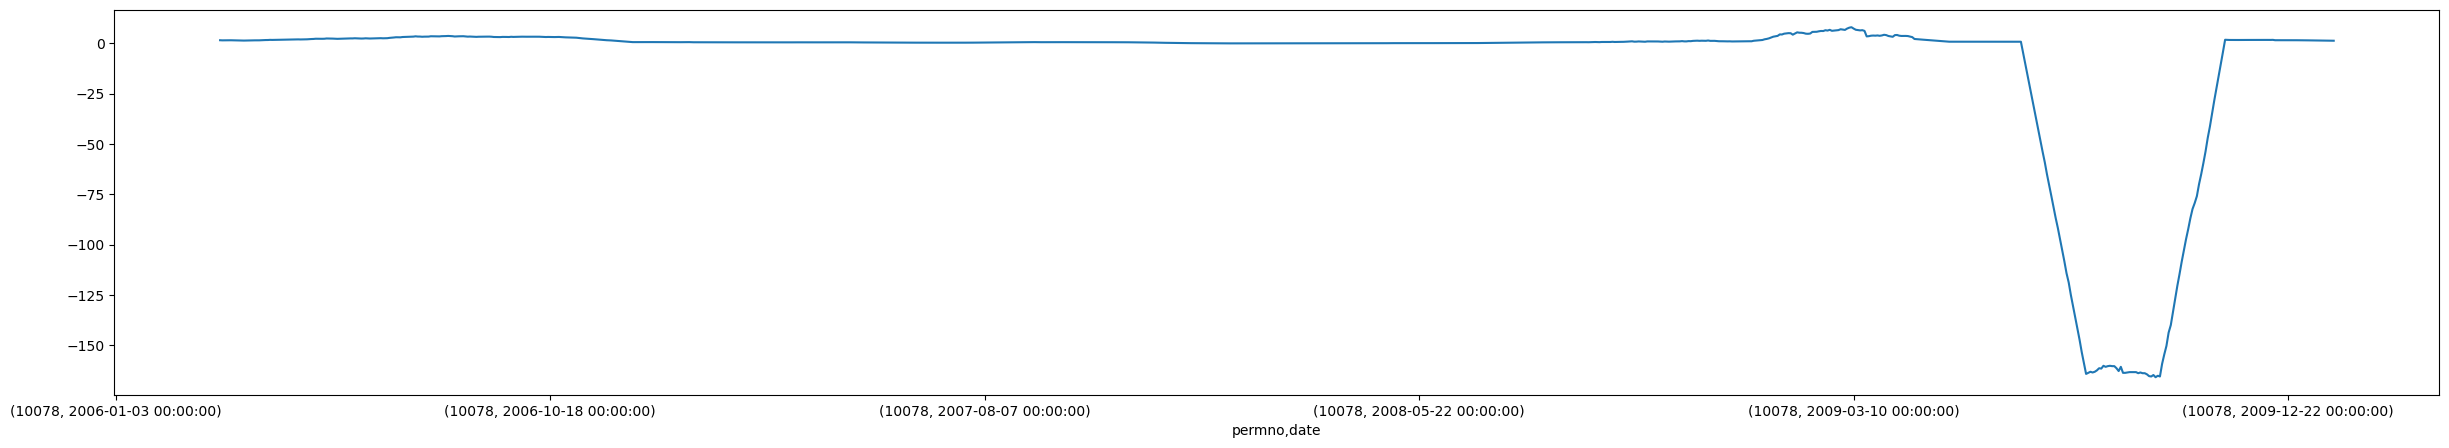

/

In [295]:
get_stock_data(emmult, 10078).EntMult.plot(figsize=(30,5))

-

<AxesSubplot:xlabel='permno,date'>

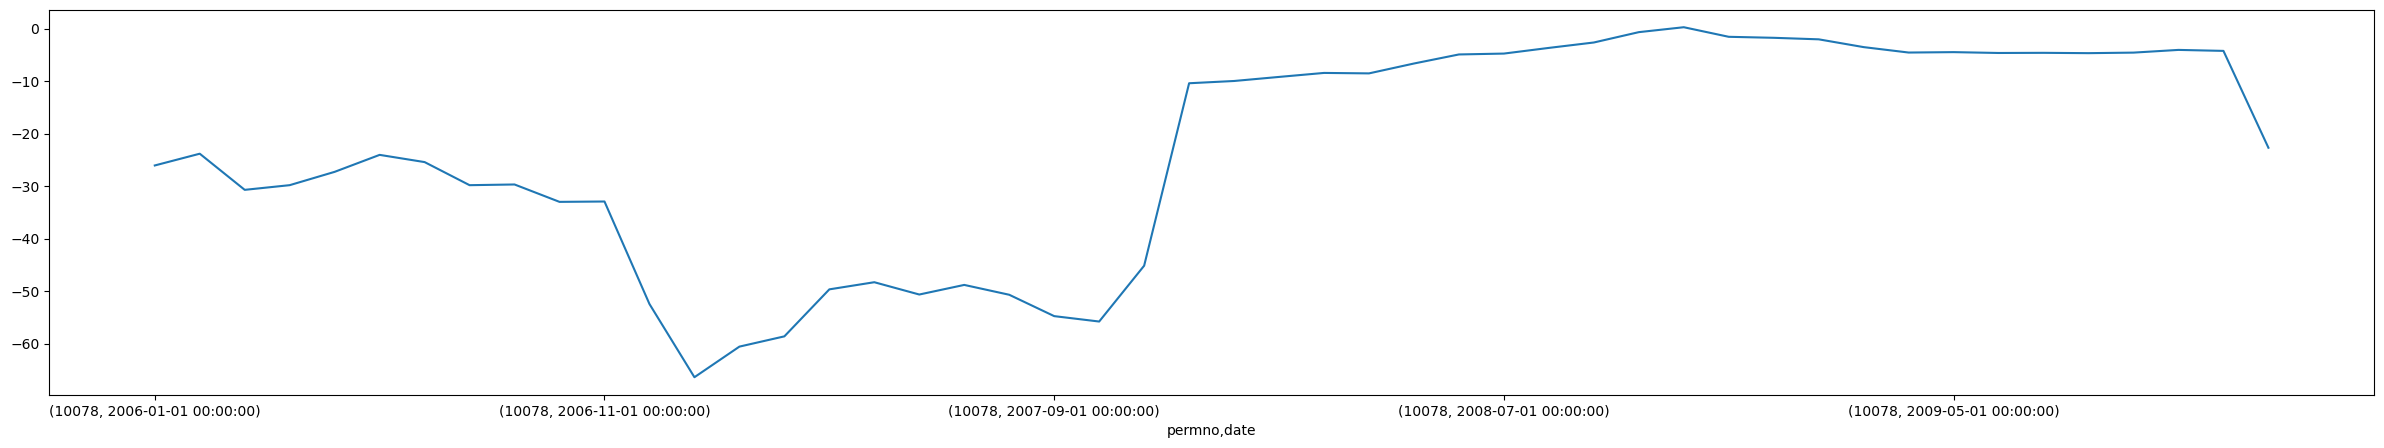

-

In [296]:
set_timeframe(get_stock_data(open_asset, 10078), start, end).EntMult.plot(figsize=(30,5))

# Earning Streak

In [236]:
open_asset = pd.read_parquet(get_load_data_parquet_dir() / 'data_open_asset.parquet.brotli')

In [237]:
earning_streak = PrepFactor(factor_name='factor_earning_streak', group='permno', interval='M', kind='fundamental', stock=stock, div=True, start=start, end=end, save=False).prep()

Creating factor_earning_streak ----------------------------- | ✔
Shape: (3272531, 1)


<AxesSubplot:xlabel='permno,date'>

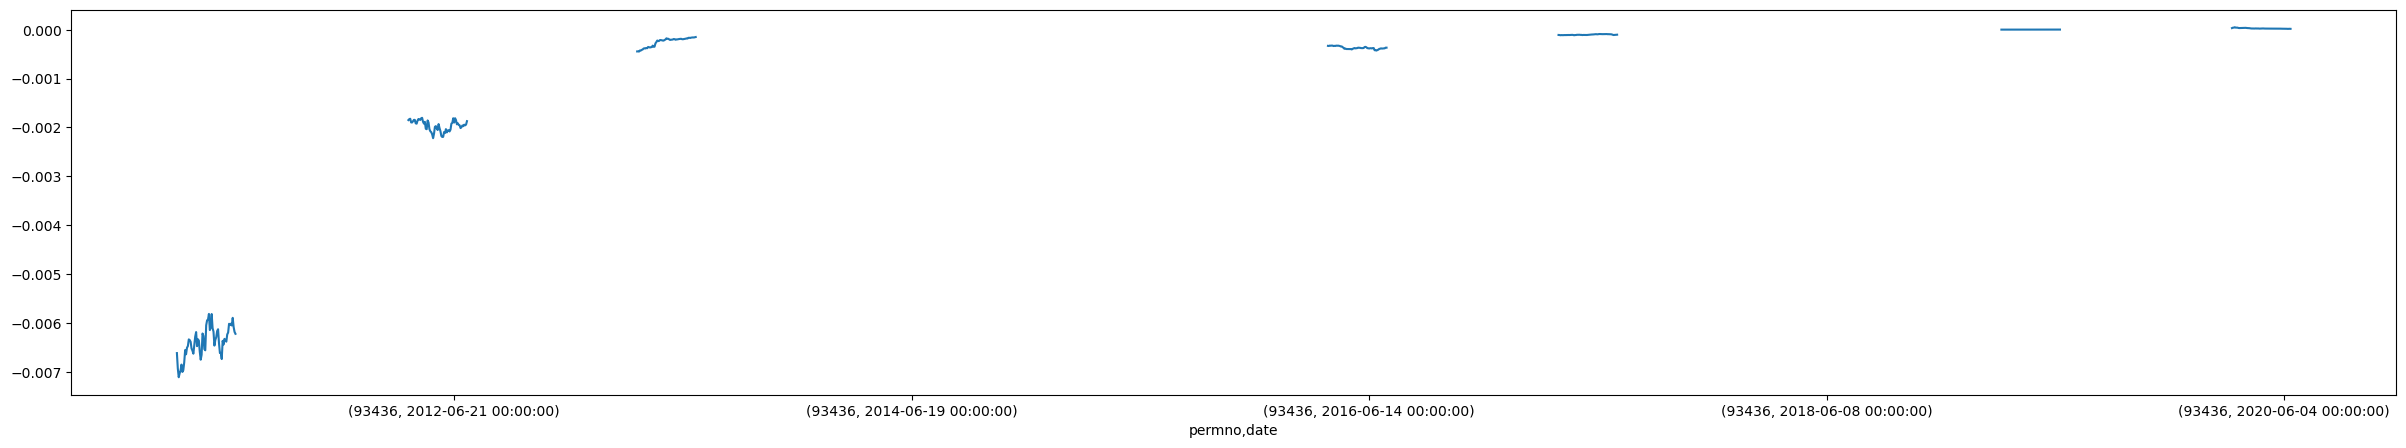

In [243]:
get_stock_data(earning_streak, 93436).EarningsStreak.plot(figsize=(30,5))

<AxesSubplot:xlabel='permno,date'>

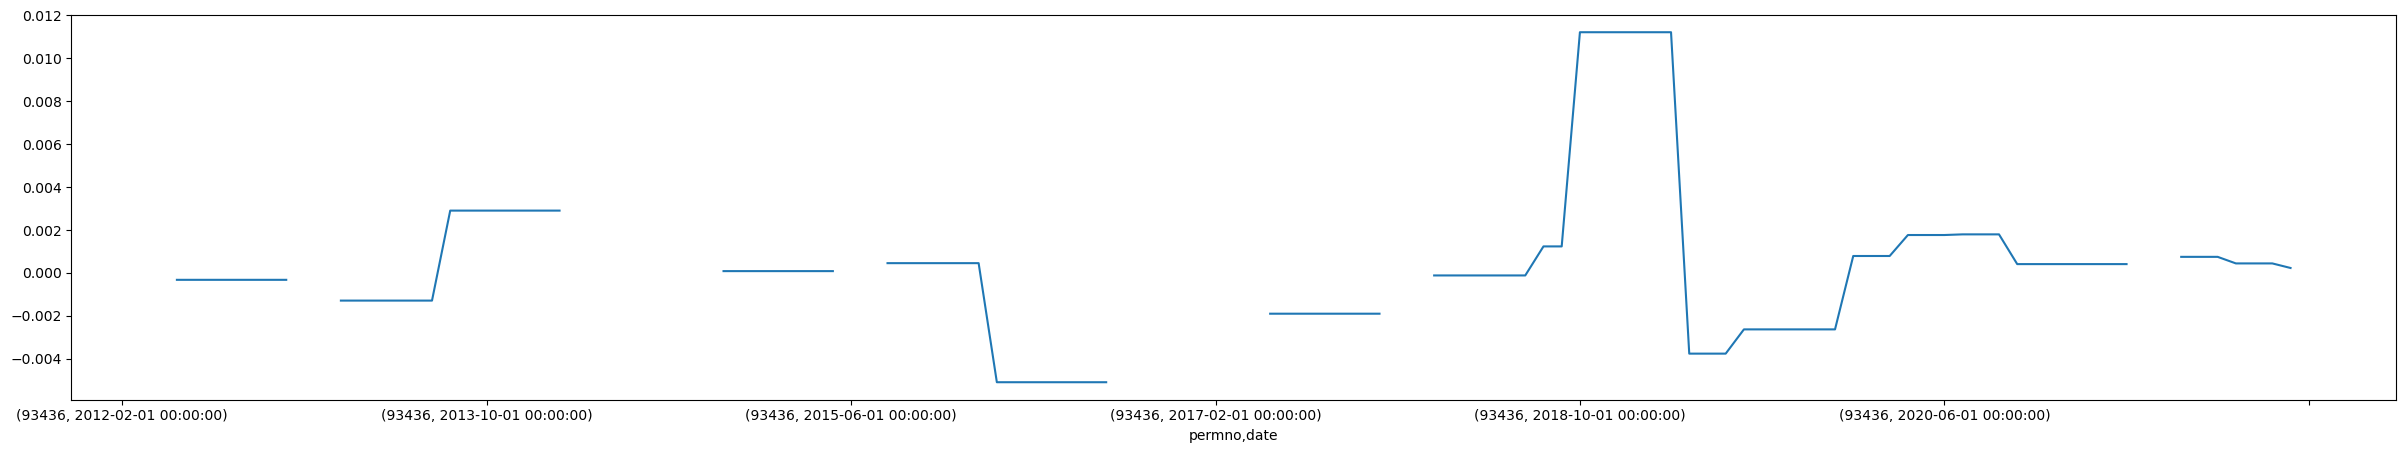

In [242]:
set_timeframe(get_stock_data(open_asset, 93436), start, end).EarningsStreak.plot(figsize=(30,5))

# Fund Raw

In [219]:
fund_raw = PrepFactor(factor_name='factor_fund_raw', group='permno', interval='M', kind='fundamental', stock=stock, div=True, start=start, end=end, save=False).prep()

Creating factor_fund_raw -----------------------------------| ✔
Shape: (3272531, 27)


In [220]:
x = pd.read_parquet(get_factor_dir(live) / 'factor_fund_raw.parquet.brotli')

<AxesSubplot:xlabel='permno,date'>

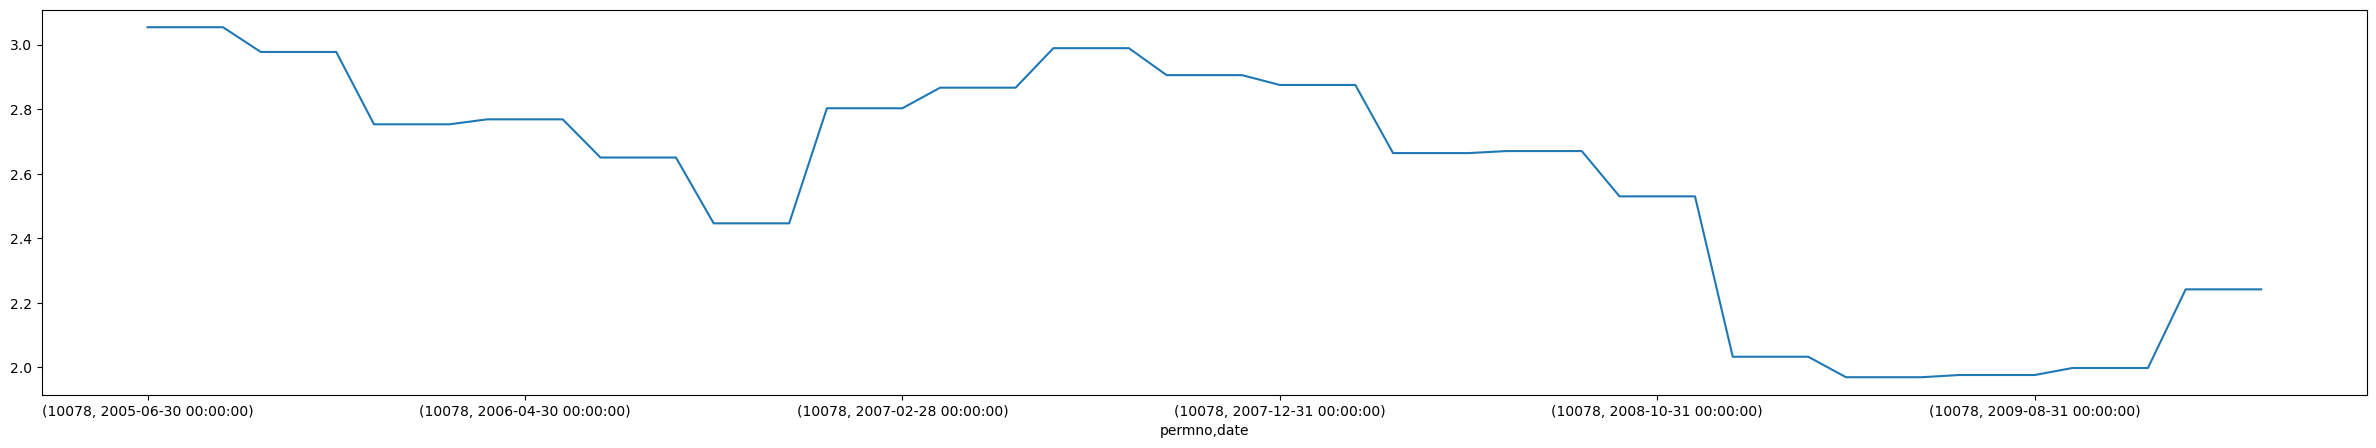

In [221]:
get_stock_data(x, 10078).current_ratio.plot(figsize = (30,5))

<AxesSubplot:xlabel='permno,date'>

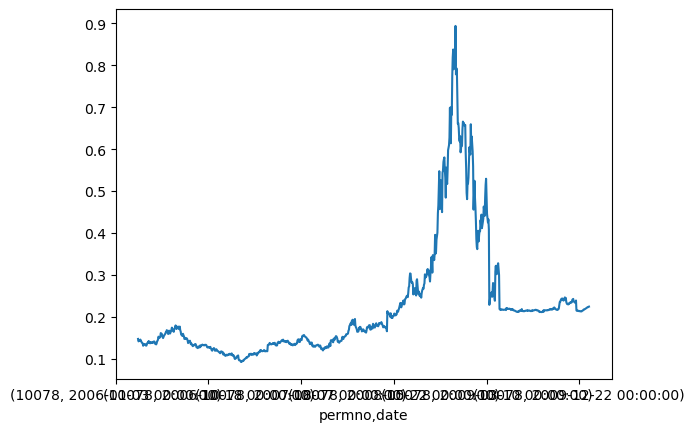

In [222]:
get_stock_data(fund_raw, 10078).current_ratio.plot()

# Frontier

In [244]:
open_asset = pd.read_parquet(get_load_data_parquet_dir() / 'data_open_asset.parquet.brotli')

In [245]:
frontier = PrepFactor(factor_name='factor_frontier', group='permno', interval='M', kind='fundamental', stock=stock, div=False, start=start, end=end, save=False).prep()

Creating factor_frontier ----------------------------------- | ✔
Shape: (3272531, 1)


<AxesSubplot:xlabel='permno,date'>

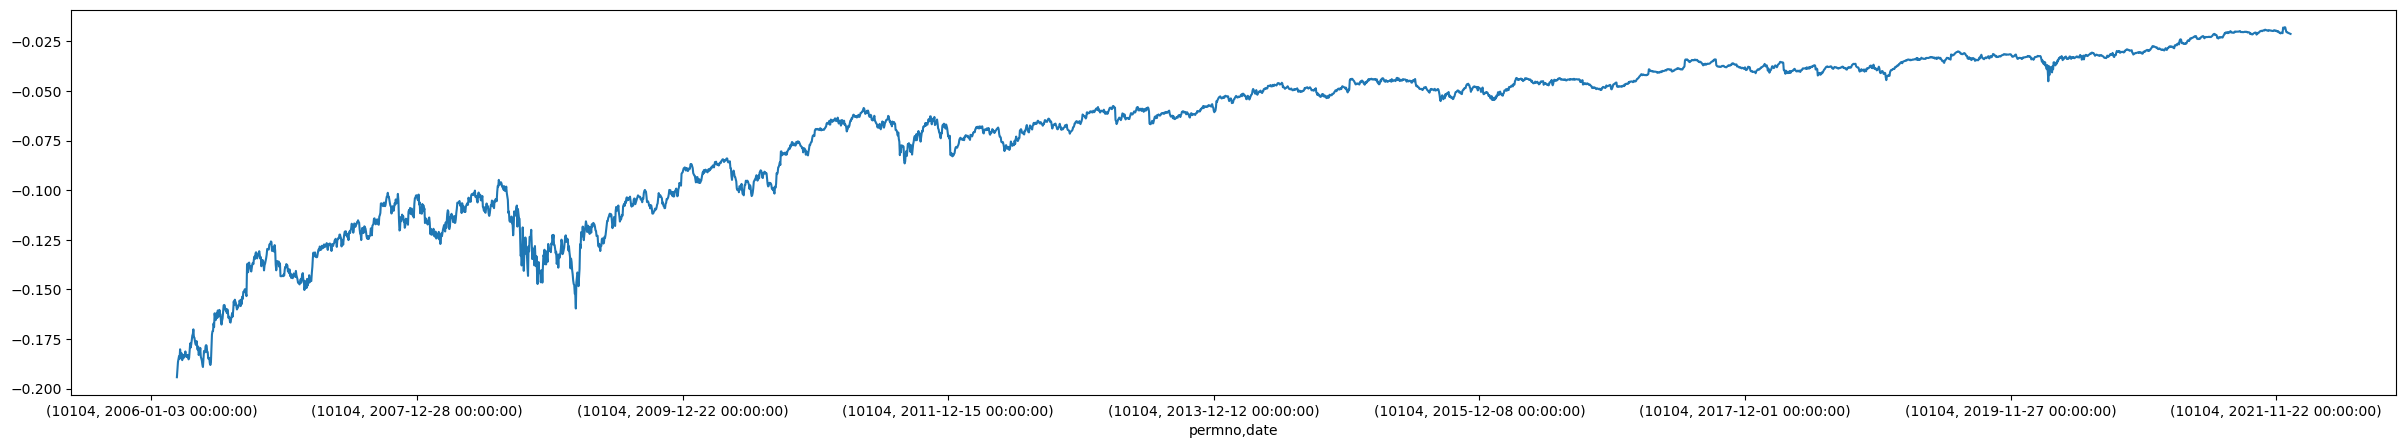

In [246]:
get_stock_data(frontier, 10104).Frontier.plot(figsize=(30,5))

<AxesSubplot:xlabel='permno,date'>

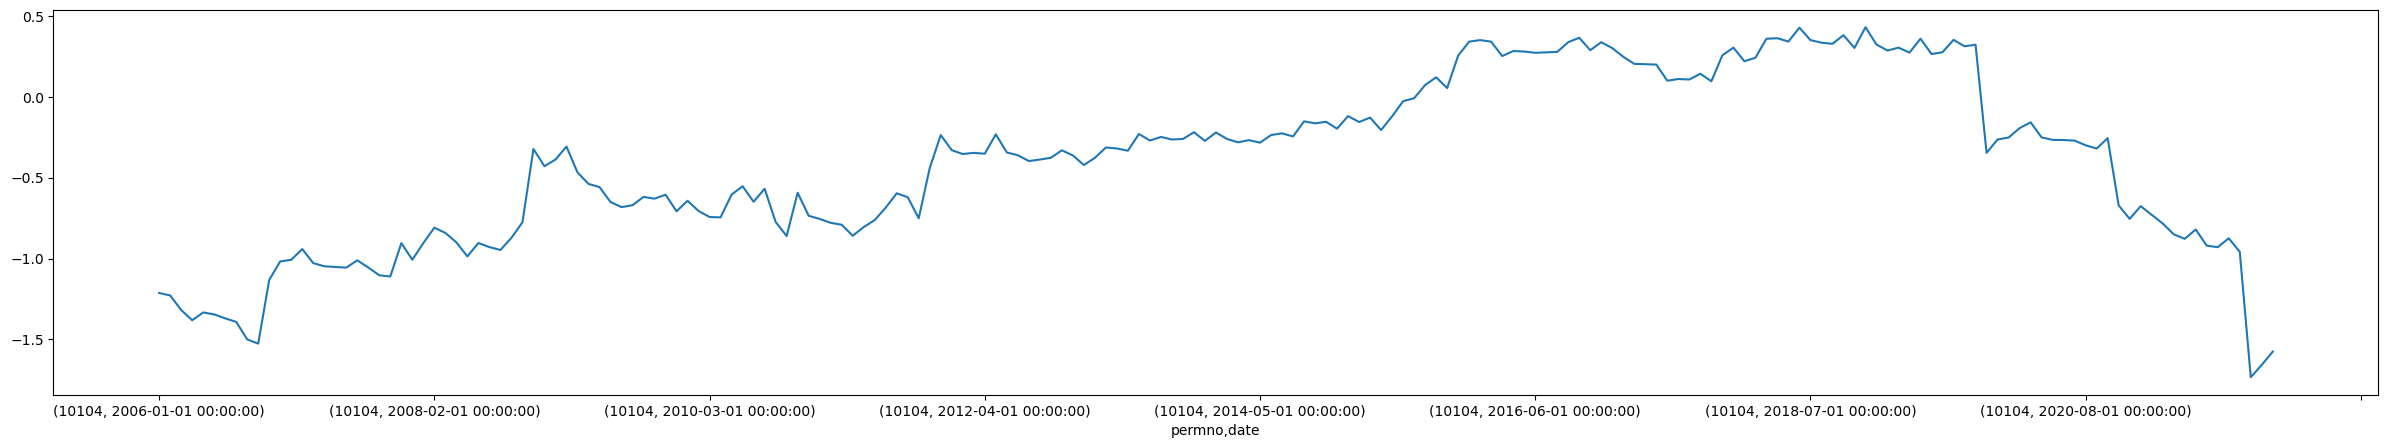

In [247]:
set_timeframe(get_stock_data(open_asset, 10104), start, end).Frontier.plot(figsize=(30,5))

# Check Returns

In [59]:
ret = PrepFactor(factor_name='factor_ret', group='permno', interval='D', kind='price', stock=stock, div=False, start=start, end=end, save=False).prep()

Creating factor_ret ---------------------------------------- | ✔
Shape: (3272531, 11)


In [65]:
ticker = pd.read_parquet(get_load_data_parquet_dir() / 'data_ticker.parquet.brotli')

In [64]:
ret.loc[ret.RET_01==ret.RET_01.max()]

,,RET_01,RET_02,RET_03,RET_04,RET_05,RET_10,RET_20,RET_40,RET_60,RET_120,RET_210
permno,date,,,,,,,,,,,
92345,2019-06-10,8.748428,8.6875,9.032362,8.972656,9.048622,10.071429,6.380952,1.872232,1.166772,1.48,0.28524


# MomVol

In [265]:
factor_data = pd.read_parquet(get_load_data_parquet_dir() / 'data_price.parquet.brotli')
T = [1]
factor_data = create_return(factor_data, windows=T)
factor_data = factor_data.fillna(0)

def compute_momentum(x):
    return ((1 + x['RET_01'].shift(1)) * (1 + x['RET_01'].shift(2)) * (1 + x['RET_01'].shift(3))
            * (1 + x['RET_01'].shift(4)) * (1 + x['RET_01'].shift(5)) - 1)
factor_data['Mom6m'] = factor_data.groupby('permno').apply(compute_momentum).reset_index(level=0, drop=True)
factor_data = factor_data.fillna(0)

In [266]:
factor_data['catMom'] = factor_data.groupby('date')['Mom6m'].transform(lambda x: pd.qcut(x, 10, labels=False, duplicates='drop'))

In [267]:
factor_data['temp'] = factor_data.groupby(group)['Volume'].transform(lambda x: x.rolling(window=6, min_periods=5).mean())
factor_data['catVol'] = factor_data.groupby('date')['temp'].transform(lambda x: pd.qcut(x, 3, labels=False, duplicates='drop'))
factor_data['MomVol'] = factor_data.apply(lambda x: x['catMom'] if x['catVol'] == 2 else None, axis=1)
factor_data['MomVol'] = factor_data.groupby(['permno', 'date']).cumcount().where(lambda x: x >= 24, factor_data['MomVol'])
factor_data = factor_data[['MomVol']]

NameError: name 'group' is not defined

# Abnormal Accruals

In [35]:
from scipy.stats.mstats import winsorize
columns = ['fopty', 'oancfy', 'actq', 'cheq', 'dlcq', 'lctq', 'ibq', 'saleq', 'atq', 'ppegtq', 'sic', 'fyearq', 'niq']
accrual = pd.read_parquet(get_load_data_parquet_dir() / 'data_fund_raw.parquet.brotli', columns=columns)
accrual = get_stocks_data(accrual, stock)
# Define a function to compute temp columns based on permno grouping
def compute_temp_cols(group):
    group['tempCFO'] = group['oancfy'].fillna(group['fopty'] - (group['actq'] - group['actq'].shift(1))
                                             + (group['cheq'] - group['cheq'].shift(1))
                                             - (group['lctq'] - group['lctq'].shift(1))
                                             + (group['dlcq'] - group['dlcq'].shift(1)))

    group['tempAccruals'] = (group['ibq'] - group['tempCFO']) / group['atq'].shift(1)
    group['tempInvTA'] = 1 / group['atq'].shift(1)
    group['tempDelRev'] = (group['saleq'] - group['saleq'].shift(1)) / group['atq'].shift(1)
    group['tempPPE'] = group['ppegtq'] / group['atq'].shift(1)
    return group

# Apply the function
merged_data = accrual.groupby('permno').apply(compute_temp_cols).reset_index(level=0, drop=True)
merged_data = merged_data.sort_values(by='fyearq')

# # Winsorize Data
# for column in merged_data.columns:
#     if column.startswith('temp'):
#         merged_data[column] = winsorize(merged_data[column], limits=[0.001, 0.001])

merged_data['sic2'] = merged_data['sic'] // 100

In [45]:
def run_regression(group):
    # Check if the group size is too small or if there are missing values
    if group.shape[0] < 2 or group[['tempAccruals', 'tempInvTA', 'tempDelRev', 'tempPPE']].isnull().any().any():
        group['fitted'] = None
        return group

    X = group[['tempInvTA', 'tempDelRev', 'tempPPE']]
    X = sm.add_constant(X)  # Adds a constant column for intercept
    y = group['tempAccruals']
    
    # Run regression only if there's no missing data
    if not X.isnull().values.any() and not y.isnull().values.any():
        model = sm.OLS(y, X, missing='drop').fit()
        group['AbnormalAccruals'] = model.fittedvalues
    else:
        group['AbnormalAccruals'] = None

    return group

result = merged_data.groupby(['fyearq', 'sic2']).apply(run_regression).reset_index(level=[0, 1], drop=True)

MissingDataError: exog contains inf or nans

In [42]:
group_counts = result.groupby(['fyearq', 'sic2']).size()
drop_indices = group_counts[group_counts < 6].index
for idx in drop_indices:
    result = result.drop(result[(result['fyearq'] == idx[0]) & (result['sic2'] == idx[1])].index)

result = result.rename(columns={'_residuals': 'AbnormalAccruals'})
# Drop duplicates
result = result.sort_values(by=['permno', 'fyearq'])
result = result.reset_index()
result = result.drop_duplicates(subset=['permno', 'fyearq'], keep='first')

In [43]:
# Compute AbnormalAccrualsPercent
result['AbnormalAccrualsPercent'] = result['AbnormalAccruals'] * result['atq'].shift(1) / abs(result['niq'])
result = result.sort_index(level=['permno', 'date'])
result = result.reset_index()

# Expanding to monthly
result = result.loc[result.index.repeat(12)]
result['date'] = result.groupby('permno').date.transform(lambda x: pd.date_range(start=x.iat[0], periods=len(x), freq='M'))
result.set_index(['permno', 'date'], inplace=True)
result = result.groupby(['permno', 'date']).last()
result = result.sort_index(level=['permno', 'date'])

In [44]:
result[['AbnormalAccrualsPercent']].dropna()

AbnormalAccrualsPercent
permno date                               
13353  2014-05-31                -2.966827
       2014-06-30                -2.966827
       2014-07-31                -2.966827
       2014-08-31                -2.966827
       2014-09-30                -2.966827
...                                    ...
93101  2024-12-31                 1.210046
       2025-01-31                 1.210046
       2025-02-28                 1.210046
       2025-03-31                 1.210046
       2025-04-30                 1.210046

[4572 rows x 1 columns]

Creating factor_inv_growth ---------------------------------/| ✔
Shape: (3272531, 1)


<AxesSubplot:xlabel='permno,date'>

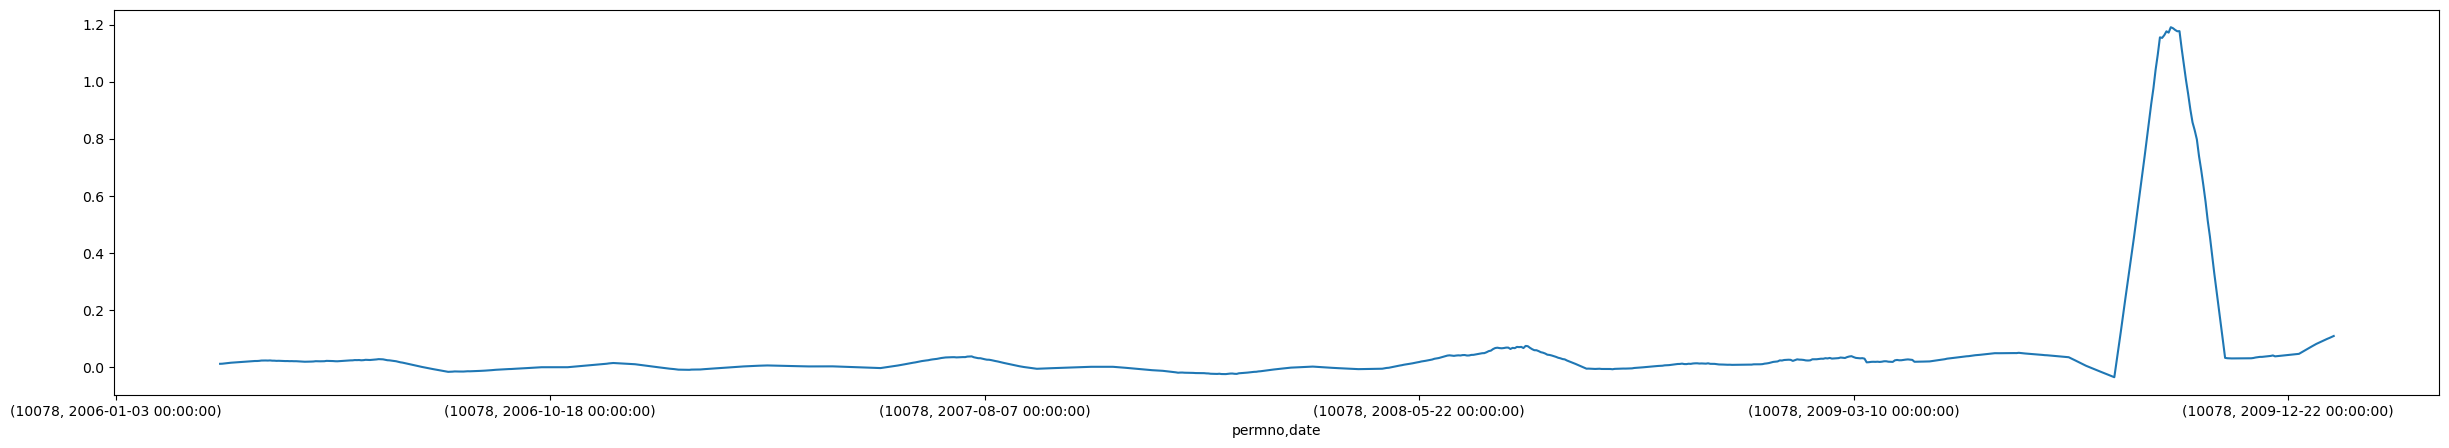

-\

|

<AxesSubplot:xlabel='permno,date'>

\

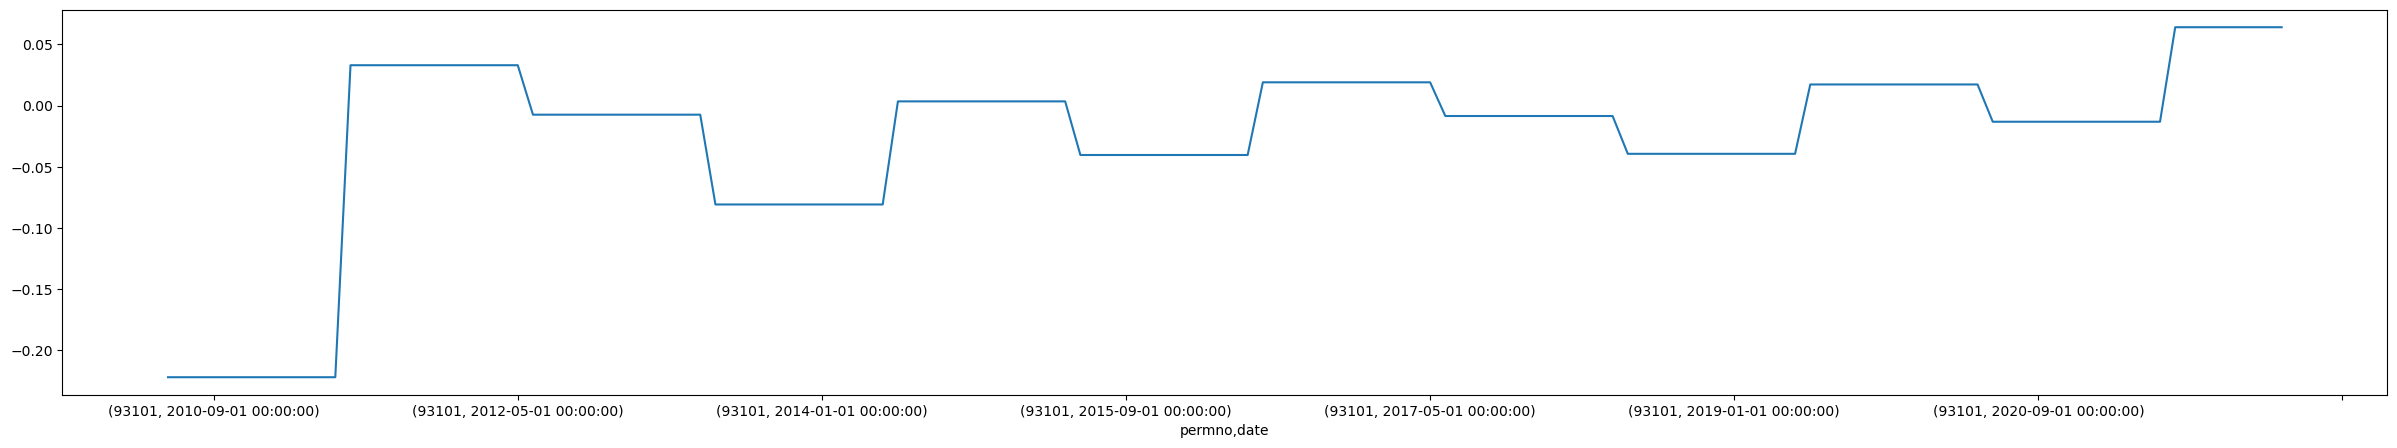

-/

In [347]:
set_timeframe(get_stock_data(open_asset, 93101), start, end).AbnormalAccruals.plot(figsize=(30,5))

# Testing Bin Size

In [356]:
price_data = pd.read_parquet(get_load_data_parquet_dir() / 'data_price.parquet.brotli')
ind_data = pd.read_parquet(get_load_data_parquet_dir() / 'data_ind_sub.parquet.brotli')
price_data = get_stocks_data(price_data, stock)
ind_data = get_stocks_data(ind_data, stock)

combine = pd.concat([price_data, ind_data], axis=1)

T = [1, 2, 5, 10, 30, 60]
ret = create_return(combine, windows=T)
collect = []

for t in T:
    ret[f'IndMomSub_{t:02}'] = ret.groupby(['Subindustry', 'date'])[f'RET_{t:02}'].transform('mean')
    ret[f'indMomSub_{t:02}_rank'] =  ret.groupby(['Subindustry', 'date'])[f'IndMomSub_{t:02}'].rank()

    bin_size = 1.2
    max_compressed_rank = (ret[f'indMomSub_{t:02}_rank'].max() + bin_size - 1) // bin_size
    ret[f'indMomSub_{t:02}_rank'] = np.ceil(ret[f'indMomSub_{t:02}_rank'] / bin_size)
    ret[f'indMomSub_{t:02}_rank'] = ret[f'indMomSub_{t:02}_rank'].apply(lambda x: min(x, max_compressed_rank))
    ret[f'indMomSub_{t:02}_rank'] = ret[f'indMomSub_{t:02}_rank'].replace({np.nan: -1, np.inf: max_compressed_rank}).astype(int)
    ind_mom = ret[[f'indMomSub_{t:02}_rank']]
    collect.append(ind_mom)

factor_data = pd.concat(collect, axis=1)

|-

In [367]:
price_data = pd.read_parquet(get_load_data_parquet_dir() / 'data_price.parquet.brotli')
ind_data = pd.read_parquet(get_load_data_parquet_dir() / 'data_ind_sub.parquet.brotli')
price_data = get_stocks_data(price_data, stock)
ind_data = get_stocks_data(ind_data, stock)

combine = pd.concat([price_data, ind_data], axis=1)

T = [1, 2, 5, 10, 30, 60]
ret = create_return(combine, windows=T)
collect = []

max_categories = 259
for t in T:
    ret[f'IndMomSub_{t:02}'] = ret.groupby(['Subindustry', 'date'])[f'RET_{t:02}'].transform('mean')
    ret[f'indMomSub_{t:02}_rank'] =  ret.groupby(['Subindustry', 'date'])[f'IndMomSub_{t:02}'].rank()
    max_rank = ret[f'indMomSub_{t:02}_rank'].max()
    bin_size = np.ceil(max_rank / max_categories)
    print(bin_size)
    
    max_compressed_rank = (max_rank + bin_size - 1) // bin_size
    ret[f'indMomSub_{t:02}_rank'] = np.ceil(ret[f'indMomSub_{t:02}_rank'] / bin_size)
    ret[f'indMomSub_{t:02}_rank'] = ret[f'indMomSub_{t:02}_rank'].apply(lambda x: min(x, max_compressed_rank))
    ret[f'indMomSub_{t:02}_rank'] = ret[f'indMomSub_{t:02}_rank'].replace({np.nan: -1, np.inf: max_compressed_rank}).astype(int)
    ind_mom = ret[[f'indMomSub_{t:02}_rank']]
    collect.append(ind_mom)

x = pd.concat(collect, axis=1)

/1.0
-|1.0
|\1.0
//1.0
/\1.0
|-1.0
-\

In [368]:
x.describe()

-

,indMomSub_01_rank,indMomSub_02_rank,indMomSub_05_rank,indMomSub_10_rank,indMomSub_30_rank,indMomSub_60_rank
count,3.654511e+06,3.654511e+06,3.654511e+06,3.654511e+06,3.654511e+06,3.654511e+06
mean,7.046993e+00,7.045742e+00,7.041994e+00,7.035741e+00,7.010606e+00,6.972787e+00
std,6.394315e+00,6.395004e+00,6.397062e+00,6.400492e+00,6.414159e+00,6.434467e+00
min,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00
25%,3.000000e+00,3.000000e+00,3.000000e+00,3.000000e+00,3.000000e+00,3.000000e+00
50%,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00
75%,9.000000e+00,9.000000e+00,9.000000e+00,9.000000e+00,9.000000e+00,9.000000e+00
max,3.100000e+01,3.100000e+01,3.100000e+01,3.100000e+01,3.100000e+01,3.100000e+01


/-

In [362]:
factor_data.describe()

\

,indMomSub_01_rank,indMomSub_02_rank,indMomSub_05_rank,indMomSub_10_rank,indMomSub_30_rank,indMomSub_60_rank
count,3.654511e+06,3.654511e+06,3.654511e+06,3.654511e+06,3.654511e+06,3.654511e+06
mean,6.124133e+00,6.123004e+00,6.119623e+00,6.113984e+00,6.091199e+00,6.056854e+00
std,5.326210e+00,5.326897e+00,5.328954e+00,5.332380e+00,5.345829e+00,5.365670e+00
min,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00
25%,3.000000e+00,3.000000e+00,3.000000e+00,3.000000e+00,3.000000e+00,3.000000e+00
50%,4.000000e+00,4.000000e+00,4.000000e+00,4.000000e+00,4.000000e+00,4.000000e+00
75%,8.000000e+00,8.000000e+00,8.000000e+00,8.000000e+00,8.000000e+00,8.000000e+00
max,2.600000e+01,2.600000e+01,2.600000e+01,2.600000e+01,2.600000e+01,2.600000e+01


-

# STUPID  Pandas

In [369]:
ret = PrepFactor(factor_name='factor_ret', group='permno', interval='D', kind='price', stock=stock, div=False, start=start, end=end, save=False).prep()

Creating factor_ret ----------------------------------------| ✔
-Shape: (3272531, 11)
-

In [370]:
clust_ind_mom_sub = PrepFactor(factor_name='factor_clust_ind_mom_sub', group='permno', interval='D', kind='ind', stock=stock, div=False, start=start, end=end, save=False).prep()

Creating factor_clust_ind_mom_sub -------------------------- | ✔
Shape: (3137154, 1)
-

In [372]:
ret.merge(clust_ind_mom_sub, left_index=True, right_index=True, how='left')

--

RET_01    RET_02    RET_03    RET_04    RET_05    RET_10  \
permno date                                                                     
10078  2006-01-03  0.031026  0.016471  0.000000  0.006993 -0.009174 -0.024831   
       2006-01-04  0.020833  0.052506  0.037647  0.020833  0.027972  0.023202   
       2006-01-05  0.063039  0.085185  0.118854  0.103059  0.085185  0.108274   
       2006-01-06  0.004693  0.068027  0.090278  0.124105  0.108235  0.100467   
       2006-01-09 -0.014862 -0.010239  0.052154  0.074074  0.107399  0.074074   
...                     ...       ...       ...       ...       ...       ...   
93436  2021-12-27  0.025248  0.084322  0.165589  0.215570  0.173038  0.075622   
       2021-12-28 -0.005000  0.020122  0.078900  0.159760  0.209492  0.126303   
       2021-12-29 -0.002095 -0.007084  0.017985  0.076640  0.157331  0.133207   
       2021-12-30 -0.014592 -0.016656 -0.021573  0.003130  0.060930  0.096671   
       2021-12-31 -0.012669 -0.027076 -0.029114 -0.033969 -0.009578  0.140098   

                     RET_20    RET_40    RET_60   RET_120   RET_210  \
permno date                                                           
10078  2006-01-03  0.093671  0.104859  0.033493  0.161290 -0.009174   
       2006-01-04  0.102500  0.130769  0.057554  0.179144 -0.015625   
       2006-01-05  0.146210  0.205141  0.154680  0.246809  0.072769   
       2006-01-06  0.171642  0.249337  0.177500  0.276423  0.080275   
       2006-01-09  0.110048  0.227513  0.182166  0.230769  0.059361   
...                     ...       ...       ...       ...       ...   
93436  2021-12-27  0.011110  0.015691  0.410662  0.696952  0.619452   
       2021-12-28 -0.042674 -0.022917  0.404079  0.667361  0.515068   
       2021-12-29 -0.051164 -0.101275  0.389825  0.653383  0.582352   
       2021-12-30 -0.022521 -0.086741  0.371193  0.560945  0.638610   
       2021-12-31 -0.025650 -0.129405  0.350086  0.580728  0.700534   

                   ind_mom_sub_cluster  
permno date                             
10078  2006-01-03                  NaN  
       2006-01-04                  NaN  
       2006-01-05                  NaN  
       2006-01-06                  NaN  
       2006-01-09                  NaN  
...                                ...  
93436  2021-12-27                  2.0  
       2021-12-28                  6.0  
       2021-12-29                 12.0  
       2021-12-30                 10.0  
       2021-12-31                  1.0  

[3272531 rows x 12 columns]

|-

# GPU

In [374]:
import subprocess

def list_gpus():
    try:
        result = subprocess.check_output(["nvidia-smi", "--query-gpu=index,name,driver_version,memory.total", "--format=csv,noheader,nounits"])
        print(result.decode("utf-8"))
    except Exception as e:
        print("Error:", e)
        print("Could not run nvidia-smi. Ensure you have NVIDIA GPUs and the NVIDIA System Management Interface installed.")

list_gpus()

0, NVIDIA GeForce RTX 3080 Laptop GPU, 531.61, 16384

|

# Checking Industry Rank

In [405]:
price_data = pd.read_parquet(get_load_data_parquet_dir() / 'data_price.parquet.brotli')
ind_data = pd.read_parquet(get_load_data_parquet_dir() / 'data_ind_sub.parquet.brotli')
combine = pd.concat([price_data, ind_data], axis=1)

T = [1]
ret = create_return(combine, windows=[1])

collect = []
for t in T:
    rolling_product = ret.groupby('Subindustry')['RET_01'].rolling(window=t).apply(lambda x: (1 + x).prod(), raw=True).reset_index(level=0, drop=True)
    ret[f'CompRet_Sub_{t:01}'] = rolling_product - 1
    # collect.append(ret[[f'CompRet_Sub_{t:01}']])

# factor_data = pd.concat(collect, axis=1)

||

In [388]:
for n, df in enumerate(ret.groupby(['Subindustry'], group_keys=False)):
    if n == 5:
        break

|

In [391]:
x = df[1]

|

In [393]:
x.loc[x.index.get_level_values(1)=='2011-02-10']

,,Open,High,Low,Close,Volume,Subindustry,RET_01,CompRet_Sub_1
permno,date,,,,,,,,
12579,2011-02-10,16.7800,16.800,16.8400,100778.443114,368606.0,10102030.0,0.023723,0.023723
37284,2011-02-10,20.6700,21.500,21.5100,21.510000,6070100.0,10102030.0,0.025751,0.025751
79259,2011-02-10,0.7226,0.721,0.7211,7.219000,753459.0,10102030.0,-0.010825,-0.010825
85269,2011-02-10,27.0100,28.080,28.0900,25.738351,14013700.0,10102030.0,0.026691,0.026691


/|

In [395]:
T = [1]
ret = create_return(combine, windows=T)
collect = []

for t in T:
    ret[f'IndMomSub_{t:02}'] = ret.groupby(['Subindustry', 'date'])[f'RET_{t:02}'].transform('mean')
    ind_mom = ret[[f'IndMomSub_{t:02}']]

|-

In [396]:
for n, df in enumerate(ret.groupby(['Subindustry'], group_keys=False)):
    if n == 5:
        break

|\

In [397]:
x = df[1]

/

In [398]:
x.loc[x.index.get_level_values(1)=='2011-02-10']

/

,,Open,High,Low,Close,Volume,Subindustry,RET_01,CompRet_Sub_1,RET_02,RET_05,RET_10,RET_30,RET_60,IndMomSub_01
permno,date,,,,,,,,,,,,,,
12579,2011-02-10,16.7800,16.800,16.8400,100778.443114,368606.0,10102030.0,0.023723,0.023723,NaN,NaN,NaN,NaN,NaN,0.016335
37284,2011-02-10,20.6700,21.500,21.5100,21.510000,6070100.0,10102030.0,0.025751,0.025751,0.003265,0.068554,0.136892,0.151499,0.472279,0.016335
79259,2011-02-10,0.7226,0.721,0.7211,7.219000,753459.0,10102030.0,-0.010825,-0.010825,-0.012449,-0.011096,-0.036053,-0.062346,-0.091950,0.016335
85269,2011-02-10,27.0100,28.080,28.0900,25.738351,14013700.0,10102030.0,0.026691,0.026691,0.002857,0.075450,0.106819,0.202570,0.438525,0.016335


\

In [456]:
T = [1]
ret = create_return(combine, windows=T)

collect = []
for t in T:
    ret[f'IndMom_{t:02}'] = ret.groupby(['Subindustry', 'date'])[f'RET_{t:02}'].transform('mean')
    ret[f'indMom_{t:02}_rank'] = ret.groupby(['date'])[f'IndMom_{t:02}'].rank(method='dense')
    ind_mom = ret[[f'indMom_{t:02}_rank']]
    collect.append(ind_mom)

-

In [457]:
y = ret.loc[ret.index.get_level_values(1) == '2022-12-28']

/

In [458]:
y.IndMom_01.nunique()

146

-

In [459]:
y.indMom_01_rank.nunique()

146

|

In [460]:
y.indMom_01_rank.nunique()

146

-

In [462]:
y.describe()

,Open,High,Low,Close,Volume,Subindustry,RET_01,CompRet_Sub_1,IndMom_01,indMom_01_rank
count,944.000000,944.000000,944.000000,944.000000,9.440000e+02,8.160000e+02,944.000000,816.000000,816.000000,816.000000
mean,604.280206,596.867186,597.733699,597.436666,3.671373e+06,3.357306e+07,-0.010712,-0.011678,-0.011678,84.644608
std,15132.465034,14946.796365,14971.920517,14963.231560,1.034550e+07,1.363623e+07,0.076489,0.081720,0.017586,44.585245
min,0.087000,0.083600,0.084000,0.084000,3.030000e+03,-1.000000e+00,-0.378378,-0.378378,-0.075223,1.000000
25%,28.082500,27.750000,27.760000,27.760000,5.513020e+05,2.030403e+07,-0.019430,-0.020271,-0.019830,46.000000
50%,63.440000,62.430000,62.460000,62.505000,1.280752e+06,3.520101e+07,-0.012625,-0.013426,-0.012615,90.000000
75%,130.852490,129.317490,129.335000,129.335000,3.343504e+06,4.510203e+07,-0.006329,-0.006768,-0.007289,123.000000
max,465000.000000,459295.000000,460067.000000,459800.000000,2.208186e+08,6.020104e+07,2.183673,2.183673,0.034484,146.000000


-\

In [461]:
y.indMom_01_rank.unique()

array([ 89.,  90.,  13., 146.,  62., 103., 113., 130., 134., 123., 114.,
         1.,  54.,  nan, 136.,  37.,   4.,  96.,  44., 140., 117., 122.,
        50.,  94., 139.,  52., 143.,  30., 141.,  58., 111.,  36.,  84.,
        29.,  85.,  80.,  25.,  14.,  63.,  67.,  66.,  10.,   3.,  11.,
        72.,  97.,  40., 101.,  42.,  56., 135.,  74., 115.,  48.,  55.,
       124.,  28.,  57.,  69.,  61.,   2.,  46., 119., 106.,  86.,  75.,
        33.,  21.,  71.,  91.,  18.,  92., 104., 125., 128.,  82.,  22.,
        79.,  83.,  26.,  43., 142.,  81.,  16., 107.,  35., 132.,  51.,
       100., 129., 109.,  47., 145.,  88.,  60., 138.,  73., 131., 118.,
        95.,  64.,  27.,  15.,   6., 112., 133.,  98., 110.,  20.,  23.,
        77.,  41., 137.,  70., 102., 116.,  17.,  31.,   9.,  93.,  87.,
        34., 108., 121.,  76.,  68.,  38., 105.,  59.,  78.,  49.,  45.,
        32., 126.,  12.,  19.,   8.,  24.,  39.,  99., 144.,  65., 127.,
         5.,  53.,   7., 120.])

\

# Checking Prepped Factors

In [3]:
ret = PrepFactor(factor_name='factor_ret', group='permno', interval='D', kind='price', stock=stock, div=False, start=start, end=end, save=False).prep()

Creating factor_ret ---------------------------------------- | ✔
Shape: (3272531, 5)


In [4]:
ret.ret_01

RET_01    RET_05    RET_21   RET_126   RET_252
permno date                                                        
10078  2006-01-03  0.031026 -0.009174  0.112542  0.186813 -0.154599
       2006-01-04  0.020833  0.027972  0.116456  0.191892 -0.047516
       2006-01-05  0.063039  0.085185  0.172000  0.302222 -0.002553
       2006-01-06  0.004693  0.108235  0.151589  0.297521  0.023913
       2006-01-09 -0.014862  0.107399  0.154229  0.260870  0.004329
...                     ...       ...       ...       ...       ...
93436  2021-12-27  0.025248  0.173038 -0.019767  0.588367  0.653052
       2021-12-28 -0.005000  0.209492  0.006054  0.598904  0.640028
       2021-12-29 -0.002095  0.157331 -0.044679  0.598043  0.630940
       2021-12-30 -0.014592  0.060930 -0.065009  0.578859  0.540545
       2021-12-31 -0.012669 -0.009578 -0.034904  0.556606  0.497556

[3272531 rows x 5 columns]

# Checking IBES Data

In [46]:
actual = pd.read_csv(get_large_dir(live) / 'summary_actual_adj_ibes.csv')
statistc = pd.read_csv(get_large_dir(live) / 'summary_statistic_adj_ibes.csv')

In [47]:
actual

,TICKER,OFTIC,STATPERS,MEASURE,PRICE,PRDAYS,SHOUT
0,0000,TLMR,2014-04-17,EPS,13.75,2014-04-16,72.276
1,0000,TLMR,2014-05-15,EPS,13.30,2014-05-14,69.978
2,0000,TLMR,2014-06-19,EPS,14.40,2014-06-18,69.992
3,0000,TLMR,2014-07-17,EPS,14.11,2014-07-16,69.992
4,0000,TLMR,2014-08-14,EPS,13.76,2014-08-13,70.451
...,...,...,...,...,...,...,...
996407,ZYNX,ZYXI,2022-09-15,EPS,9.24,2022-09-14,38.407
996408,ZYNX,ZYXI,2022-10-20,EPS,8.88,2022-10-19,38.407
996409,ZYNX,ZYXI,2022-11-17,EPS,13.41,2022-11-16,37.453
996410,ZYNX,ZYXI,2022-12-15,EPS,14.28,2022-12-14,37.453


In [49]:
statistic.fpi.unique()

array([1], dtype=int64)

In [55]:
statistic = pd.read_csv(get_large_dir(live) / 'summary_statistic_unadj_ibes.csv')
actual = pd.read_csv(get_large_dir(live) / 'summary_actual_unadj_ibes.csv')
statistic.columns = statistic.columns.str.lower()
actual.columns = actual.columns.str.lower()
statistic = statistic.drop('ticker', axis=1)
actual = actual.drop('ticker', axis=1)
statistic['date'] = pd.to_datetime(statistic['statpers']).dt.to_period('M')
statistic = statistic.rename(columns={'oftic': 'ticker'})
actual = actual.rename(columns={'oftic': 'ticker'})
actual['date'] = pd.to_datetime(actual['statpers']).dt.to_period('M')
actual = actual.drop(['statpers'], axis=1)
actual = actual.groupby(['ticker', 'date']).last().reset_index()
combined = pd.merge(actual, statistic, on=['ticker', 'date'], how='right')
# Prep IBES data for short term
ibes_short = combined[combined['fpi'] == 1].copy()
ibes_short = ibes_short.dropna(subset=['fpedats'])
ibes_short['statpers'] = pd.to_datetime(ibes_short['statpers'])
ibes_short['fpedats'] = pd.to_datetime(ibes_short['fpedats'])
ibes_short = ibes_short[ibes_short['fpedats'] > ibes_short['statpers'] + pd.Timedelta(days=30)]
# Convert ticker to permno
ticker = pd.read_parquet(get_load_data_parquet_dir() / 'data_ticker.parquet.brotli')
ticker = ticker.reset_index()
ticker['date'] = ticker['date'].dt.to_period('M')
ticker = ticker.set_index(['permno', 'date'])
ticker = ticker[~ticker.index.duplicated(keep='first')]
ticker = ticker.reset_index()
ticker.permno = ticker.permno.astype(int)
ibes_permno = pd.merge(ticker, ibes_short, on=['ticker', 'date'], how='right')
ibes_permno = ibes_permno.dropna(subset='permno').set_index(['permno', 'date'])
ibes_permno = ibes_permno.sort_index(level=['permno', 'date'])

In [57]:
ibes_permno['tempShort'] = 100 * (ibes_permno['meanest'] - ibes_permno['fy0a']) / abs(ibes_permno['fy0a'])


In [59]:
ibes_permno['earning_disparity'] = ibes_permno['fvyrgro'] - ibes_permno['tempShort']


In [61]:
ibes_permno = ibes_permno[['earning_disparity']]

In [62]:
ibes_permno

earning_disparity
permno  date                      
10078.0 2005-01        -108.086667
        2005-02        -108.086667
        2005-03        -108.086667
        2005-04        -108.086667
        2005-05         -91.420000
...                            ...
93436.0 2022-07           8.388761
        2022-08           0.469115
        2022-09          -3.070708
        2022-10           3.594071
        2022-11           3.151593

[134622 rows x 1 columns]

In [21]:
# Prep IBES data for long term
ibes_long = combined[combined['fpi'] == '0'].copy()
ibes_long = ibes_long.rename(columns={'meanest': 'fgr5yr'})

# Check skew

In [63]:
splice_data = pd.read_parquet(get_load_data_parquet_dir() / 'data_price.parquet.brotli')
T = [1]
splice_data = create_return(splice_data, windows=T)
splice_data['time_avail_m'] = splice_data.index.get_level_values('date').to_period('M')

In [68]:
splice_data

Open    High     Low   Close       Volume    RET_01  \
permno date                                                                 
10078  2005-01-03    5.220    5.09    5.10   20.44   83881068.0       NaN   
       2005-01-04    5.030    4.62    4.63   18.52  132811344.0 -0.093933   
       2005-01-05    4.670    4.69    4.70   18.80   59645498.0  0.015119   
       2005-01-06    4.730    4.59    4.59   18.40   59626223.0 -0.021277   
       2005-01-07    4.640    4.62    4.62   18.48   48983481.0  0.004348   
...                    ...     ...     ...     ...          ...       ...   
93436  2022-12-23  126.370  123.09  123.11  123.15  166917212.0 -0.017551   
       2022-12-27  117.495  109.07  109.10  109.10  208446557.0 -0.114089   
       2022-12-28  110.350  112.70  112.72  112.71  220818648.0  0.033089   
       2022-12-29  120.385  121.83  121.85  121.82  221592714.0  0.080827   
       2022-12-30  119.950  123.24  123.27  123.18  157632606.0  0.011164   

                  time_avail_m  
permno date                     
10078  2005-01-03      2005-01  
       2005-01-04      2005-01  
       2005-01-05      2005-01  
       2005-01-06      2005-01  
       2005-01-07      2005-01  
...                        ...  
93436  2022-12-23      2022-12  
       2022-12-27      2022-12  
       2022-12-28      2022-12  
       2022-12-29      2022-12  
       2022-12-30      2022-12  

[4127732 rows x 7 columns]

In [65]:
skew_df = splice_data.groupby(['permno', 'time_avail_m']).agg(ndays=('RET_01', 'size'),ret_skew=('RET_01', 'skew')).reset_index()

In [66]:
skew_df

,permno,time_avail_m,ndays,ret_skew
0,10078,2005-01,20,-0.933488
1,10078,2005-02,19,-0.267844
2,10078,2005-03,22,-0.281461
3,10078,2005-04,21,-0.535727
4,10078,2005-05,21,1.204277
...,...,...,...,...
197169,93436,2022-08,23,-0.130431
197170,93436,2022-09,21,-0.718348
197171,93436,2022-10,21,-0.365944
197172,93436,2022-11,21,0.631104


In [ ]:
skew_df = splice_data.groupby(['permno', 'time_avail_m']).agg(ndays=('RET_01', 'size'),ret_skew=('RET_01', 'skew')).reset_index()
skew_df.loc[skew_df['ndays'] < 15, 'ret_skew'] = None
splice_data = splice_data.reset_index()
splice_data = pd.merge(splice_data, skew_df[['permno', 'time_avail_m', 'ret_skew']], on=['permno', 'time_avail_m'], how='left')
splice_data = splice_data.set_index(['permno', 'date'])
splice_data = splice_data[['ret_skew']]

# Div Season

In [2]:
dividend = pd.read_parquet(get_load_data_parquet_dir() / 'data_crsp.parquet.brotli')

In [3]:
dividend.columns

Index(['shrcd', 'exchcd', 'siccd', 'ticker', 'shrcls', 'naics', 'permco',
       'issuno', 'dclrdt', 'paydt', 'rcrddt', 'distcd', 'divamt', 'facpr',
       'facshr', 'shrenddt', 'bidlo', 'askhi', 'Close', 'Volume', 'ret',
       'High', 'Low', 'outstanding', 'adj_price', 'cfacshr', 'Open', 'numtrd',
       'retx', 'vwretd', 'vwretx', 'ewretd', 'ewretx', 'sprtrn', 'market_cap'],
      dtype='object')

In [7]:
dividend[['paydt']].dropna()

paydt
permno date                  
10078  2007-11-12  2007-11-12
10104  2009-04-06  2009-05-08
       2009-07-13  2009-08-13
       2009-10-09  2009-11-04
       2010-01-14  2010-02-09
...                       ...
93429  2022-05-27  2022-06-15
       2022-08-30  2022-09-15
       2022-11-29  2022-12-15
93436  2020-08-31  2020-08-28
       2022-08-25  2022-08-24

[45850 rows x 1 columns]

# Ret Max

In [63]:
factor_data = pd.read_parquet(get_load_data_parquet_dir() / 'data_price.parquet.brotli')
splice_data = create_return(factor_data, [1])
splice_data['time_avail_m'] = splice_data.index.get_level_values('date').to_period('M')

In [64]:
splice_data

Open    High     Low   Close       Volume    RET_01  \
permno date                                                                 
10078  2005-01-03    5.220    5.09    5.10   20.44   83881068.0       NaN   
       2005-01-04    5.030    4.62    4.63   18.52  132811344.0 -0.093933   
       2005-01-05    4.670    4.69    4.70   18.80   59645498.0  0.015119   
       2005-01-06    4.730    4.59    4.59   18.40   59626223.0 -0.021277   
       2005-01-07    4.640    4.62    4.62   18.48   48983481.0  0.004348   
...                    ...     ...     ...     ...          ...       ...   
93436  2022-12-23  126.370  123.09  123.11  123.15  166917212.0 -0.017551   
       2022-12-27  117.495  109.07  109.10  109.10  208446557.0 -0.114089   
       2022-12-28  110.350  112.70  112.72  112.71  220818648.0  0.033089   
       2022-12-29  120.385  121.83  121.85  121.82  221592714.0  0.080827   
       2022-12-30  119.950  123.24  123.27  123.18  157632606.0  0.011164   

                  time_avail_m  
permno date                     
10078  2005-01-03      2005-01  
       2005-01-04      2005-01  
       2005-01-05      2005-01  
       2005-01-06      2005-01  
       2005-01-07      2005-01  
...                        ...  
93436  2022-12-23      2022-12  
       2022-12-27      2022-12  
       2022-12-28      2022-12  
       2022-12-29      2022-12  
       2022-12-30      2022-12  

[4127732 rows x 7 columns]

In [66]:
forward = splice_data.copy(deep=True)
forward['time_avail_m'] = forward['time_avail_m'].dt.to_timestamp() + pd.DateOffset(months=1)
forward['ret_max'] = forward.groupby(['permno', 'time_avail_m'])['RET_01'].transform('max')

In [67]:
forward

Open    High     Low   Close       Volume    RET_01  \
permno date                                                                 
10078  2005-01-03    5.220    5.09    5.10   20.44   83881068.0       NaN   
       2005-01-04    5.030    4.62    4.63   18.52  132811344.0 -0.093933   
       2005-01-05    4.670    4.69    4.70   18.80   59645498.0  0.015119   
       2005-01-06    4.730    4.59    4.59   18.40   59626223.0 -0.021277   
       2005-01-07    4.640    4.62    4.62   18.48   48983481.0  0.004348   
...                    ...     ...     ...     ...          ...       ...   
93436  2022-12-23  126.370  123.09  123.11  123.15  166917212.0 -0.017551   
       2022-12-27  117.495  109.07  109.10  109.10  208446557.0 -0.114089   
       2022-12-28  110.350  112.70  112.72  112.71  220818648.0  0.033089   
       2022-12-29  120.385  121.83  121.85  121.82  221592714.0  0.080827   
       2022-12-30  119.950  123.24  123.27  123.18  157632606.0  0.011164   

                  time_avail_m   ret_max  
permno date                               
10078  2005-01-03   2005-02-01  0.054502  
       2005-01-04   2005-02-01  0.054502  
       2005-01-05   2005-02-01  0.054502  
       2005-01-06   2005-02-01  0.054502  
       2005-01-07   2005-02-01  0.054502  
...                        ...       ...  
93436  2022-12-23   2023-01-01  0.080827  
       2022-12-27   2023-01-01  0.080827  
       2022-12-28   2023-01-01  0.080827  
       2022-12-29   2023-01-01  0.080827  
       2022-12-30   2023-01-01  0.080827  

[4127732 rows x 8 columns]

In [ ]:
forward = forward.reset_index()
splice_data = splice_data.reset_index()
forward = forward[[group, 'time_avail_m', 'ret_max']]
splice_data = splice_data.merge(forward, on=[group, 'time_avail_m'], how='left')
splice_data = splice_data.reset_index()
splice_data = splice_data.set_index([group, 'date'])
splice_data = splice_data[['ret_max']]

# RDS

In [90]:
columns_compustat = ['gvkey', 'ceqq', 'niq', 'dvpq', 'rectaq', 'cshoq', 'prccq', 'msaq', 'cdvcy']
rds = pd.read_parquet(get_load_data_parquet_dir() / 'data_fund_raw.parquet.brotli', columns=columns_compustat)
rds['year'] = rds.index.get_level_values('date').year
rds = rds.reset_index()

columns_pension = ['gvkey', 'pcupsu', 'paddml']
pension = pd.read_parquet(get_load_data_parquet_dir() / 'data_pension.parquet.brotli', columns=columns_pension)
pension['year'] = pension.index.get_level_values('date').year

In [84]:
rds = rds.merge(pension[['gvkey', 'year', 'pcupsu', 'paddml']], on=['gvkey', 'year'], how='left')

In [85]:
rds['rectaq'] = rds['rectaq'].fillna(0)
rds = rds.set_index(['permno', 'date'])
rds = rds.sort_index(level=['permno', 'date'])

In [89]:
def calculate_rds(group):
        group['DS'] = (group['msaq'] - group['msaq'].shift(1)) + \
                      (group['rectaq'] - group['rectaq'].shift(1)) + \
                      0.65 * (group['pcupsu'].sub(group['paddml']).clip(upper=0) -
                              group['pcupsu'].shift(1).sub(group['paddml'].shift(1)).clip(upper=0))
        group['rds'] = (group['ceqq'] - group['ceqq'].shift(1)) - group['DS'] - \
                       (group['niq'] - group['dvpq']) + group['cdvcy'] - \
                       group['prccq'] * (group['cshoq'] - group['cshoq'].shift(1))
        return group

rds = rds.groupby('permno').apply(calculate_rds).reset_index(level=0, drop=True)

IndentationError: unindent does not match any outer indentation level (<tokenize>, line 11)

In [96]:
pension

,gvkey,pcupsu,paddml,year
date,,,,
2005-05-31,NaN,NaN,NaN,2005
2006-05-31,1004.0,NaN,NaN,2006
2007-05-31,1004.0,NaN,NaN,2007
2008-05-31,1004.0,NaN,NaN,2008
2009-05-31,1004.0,NaN,NaN,2009
...,...,...,...,...
2021-12-31,351590.0,NaN,NaN,2021
2022-12-31,351590.0,NaN,NaN,2022
2021-12-31,NaN,NaN,NaN,2021


# Ind Mom Comp

In [7]:
price_data = pd.read_parquet(get_load_data_parquet_dir() / 'data_price.parquet.brotli')
crsp = pd.read_parquet(get_load_data_parquet_dir() / 'data_crsp.parquet.brotli', columns=['market_cap'])
ind_data = pd.read_parquet(get_load_data_parquet_dir() / 'data_ind.parquet.brotli')
combine = pd.concat([price_data, ind_data, crsp], axis=1)


T = [1]
ret = create_return(combine, windows=T)
ret['Mom6m'] = ret.groupby('permno').apply(
    lambda group: (1 + group['RET_01'].shift(1)) * (1 + group['RET_01'].shift(2)) * \
                  (1 + group['RET_01'].shift(3)) * (1 + group['RET_01'].shift(4)) * \
                  (1 + group['RET_01'].shift(5)) - 1).reset_index(level=0, drop=True)

In [8]:
ret = ret.reset_index()

In [11]:
ret['ind_mom_comp'] = ret.groupby(['Industry', 'date'])['Mom6m'].transform('sum')

In [12]:
ret

,permno,date,Open,High,Low,Close,Volume,Industry,market_cap,RET_01,Mom6m,ind_mom_comp
0,10078,2005-01-03,5.220,5.09,5.10,20.44,83881068.0,452020.0,6.904348e+10,NaN,NaN,0.000000
1,10078,2005-01-04,5.030,4.62,4.63,18.52,132811344.0,452020.0,6.255799e+10,-0.093933,NaN,0.000000
2,10078,2005-01-05,4.670,4.69,4.70,18.80,59645498.0,452020.0,6.350379e+10,0.015119,NaN,0.000000
3,10078,2005-01-06,4.730,4.59,4.59,18.40,59626223.0,452020.0,6.215264e+10,-0.021277,NaN,0.000000
4,10078,2005-01-07,4.640,4.62,4.62,18.48,48983481.0,452020.0,6.242287e+10,0.004348,NaN,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
4127727,93436,2022-12-23,126.370,123.09,123.11,123.15,166917212.0,251020.0,3.888772e+11,-0.017551,-0.204985,-0.871625
4127728,93436,2022-12-27,117.495,109.07,109.10,109.10,208446557.0,251020.0,3.445107e+11,-0.114089,-0.180257,-0.815307
4127729,93436,2022-12-28,110.350,112.70,112.72,112.71,220818648.0,251020.0,3.559102e+11,0.033089,-0.272036,-0.371109
4127730,93436,2022-12-29,120.385,121.83,121.85,121.82,221592714.0,251020.0,3.846773e+11,0.080827,-0.182075,0.115041


# Mom Rev

In [14]:
factor_data = pd.read_parquet(get_load_data_parquet_dir() / 'data_price.parquet.brotli')
factor_data = get_stocks_data(factor_data, stock)
T = [1]
factor_data = create_return(factor_data, windows=T)
T = 6
K = 36
percentile = 0.8

# factor_data['Mom6m'] = factor_data.groupby('permno')['RET_01'].transform(lambda x: x.rolling(window=T, min_periods=1).apply(lambda y: ((1 + y).prod()) - 1))
# factor_data['Mom36m'] = factor_data.groupby('permno')['RET_01'].transform(lambda x: x.rolling(window=K, min_periods=1).apply(lambda y: ((1 + y).prod()) - 1))


In [15]:
factor_data

Open    High     Low   Close       Volume    RET_01
permno date                                                              
10078  2005-01-03    5.220    5.09    5.10   20.44   83881068.0       NaN
       2005-01-04    5.030    4.62    4.63   18.52  132811344.0 -0.093933
       2005-01-05    4.670    4.69    4.70   18.80   59645498.0  0.015119
       2005-01-06    4.730    4.59    4.59   18.40   59626223.0 -0.021277
       2005-01-07    4.640    4.62    4.62   18.48   48983481.0  0.004348
...                    ...     ...     ...     ...          ...       ...
93436  2022-12-23  126.370  123.09  123.11  123.15  166917212.0 -0.017551
       2022-12-27  117.495  109.07  109.10  109.10  208446557.0 -0.114089
       2022-12-28  110.350  112.70  112.72  112.71  220818648.0  0.033089
       2022-12-29  120.385  121.83  121.85  121.82  221592714.0  0.080827
       2022-12-30  119.950  123.24  123.27  123.18  157632606.0  0.011164

[3654511 rows x 6 columns]